# Graph Neural Networks

<hr style="border:2px solid gray">

# Index <a id='index'></a>
1. [Introduction: what are graphs?](#what) <!-- Basic definitions, kinds of tasks -->
1. [Graphs in Python with PyTorch Geometric](#python-graphs)
1. [Intro to GNNs](#embeddings)
1. [Building and training GNNs using PyTorch Geometric](#pyg-gnn) <!--Message passing, aggregation, prediction heads -->
1. [Exercises](#exercises)
1. [Appendices](#appendices)

<hr style="border:2px solid gray">

# Introduction: what are graphs? <a id='what'></a>[^](#index)

(Brief aside: there is a nice textbook on GNNs called "Graph Representation Learning", which has a prepublication draft available for free online at [https://www.cs.mcgill.ca/~wlh/grl_book/](https://www.cs.mcgill.ca/~wlh/grl_book/))

So far in our study of neural networks, we have covered two extremes: fully connected neural networks, where every input to a layer is connected to every output, and convolutional neural networks, where only local points contribute to prediction at a given point. Somewhere between using global features and only using local features lies a method applicable to many problems, so long as we can structure the data in a particular way. This method is referred to as **graph neural networks** (**GNNs**). 

Before we can discuss GNNS, we first need to understand what we mean by graphs. In general, we use graphs to represent and solve problems where the data is composed of objects and relationships between them, both of which can be described in many ways.

For the purposes of this notebook, we will deal with graphs that are composed of:

* **nodes**: objects that generally have a set of feature values

* **edges**: links between pairs of nodes

Where we put edges in our graph determines links between nodes, and any pair of nodes does not have to have an edge between them. For a specific node, the list of nodes directly connected to it is referred to as the **neighbourhood** of the node. We also refer to nodes that you must traverse $k$ edges to reach as being $k$ **hops** away, and the **$k$-hop neighbourhood** denotes the set of these nodes.

Consider a black & white image where we say any pixel in the image is a node. Because the image has a rectangular structure, every node will have links to 4 adjacent nodes (apart from pixels at the edge of the image). Pixels that are not adjacent will not have edges between them. A schematic of a basic graph can be seen below.



<center>
<img src="plots/undirected_graph.png" width=400 align="center">
</center>

<div style="text-align:center;">
<div style='width:450px;display:inline-block;vertical-align:top;margin-top: 10px;'>
<div style="text-align: justify;">

*A graphic of a simple graph with 4 nodes. We would say node 1 has edges linking to nodes 2 and 3; node 2 to 1 and 3; node 3 to 1, 2, and 4; and node 4 to just node 3 [[source](https://study.com/academy/lesson/weighted-graphs-implementation-dijkstra-algorithm.html)]* 
</div></div></div>



The features at each node describe that node, and the edges represent some link between nodes. What those features are, or what that link is, depends entirely on the data we are considering. Some common examples of graph data:

* Social networks: nodes are people, and edges represent people who are "friends" on social media

<center>
<img src="plots/social_networks.png" width=400 align="center">
</center>
<div style="text-align:center;">
<div style='width:480px;display:inline-block;vertical-align:top;margin-top: 10px;'>
<div style="text-align:justify;">

*A graphic representing a social network as a graph, where people are nodes and connections are represented by edges [[source](https://medium.com/analytics-vidhya/social-network-analytics-f082f4e21b16)]*
</div></div></div>


* Molecules: nodes are atoms, and edges represent chemical bonds in the molecule

<center>
<img src="plots/Caffeine_structure.png" align="center" width=400>
</center>
<div style="text-align:center;">
<div style='width:480px;display:inline-block;vertical-align:top;margin-top:10px;'>
<div style="text-align:justify;">

*A graphic illustrating the structure of a caffeine molecule, where we can interpret atoms as nodes and chemical bonds as edges [[source](https://en.wikipedia.org/wiki/Molecular_graph)].*

*Note that this graphic omits displaying carbon or hydrogen atoms, which is a convention used in chemistry.*
</div></div></div>

* The London Underground map: nodes are stations, and edges are routes between stations

<center>
<img src="plots/tube_map.png" align="center" width=400>
</center>
<div style="text-align:center;">
<div style='width:480px;display:inline-block;vertical-align:top;margin-top:10px;'>
<div style="text-align:justify;">

*The London Underground map [[source](https://content.tfl.gov.uk/standard-tube-map.pdf)]. Treating as a graph, stations are nodes and routes between stations are edges.*
</div></div></div>

You can see there are many possible types of data that we can represent as graphs that could have interesting or challenging problems to tackle. 



<div style="background-color:#0000">

Formally, we denote a graph $G = (V, E)$ as having a set of nodes (or vertices) $V$ and a set of edges between these nodes $E$. The edge between node $u$ and node $v$ is denoted as the pair of vertices ($u$, $v$). 

In general we could have multiple edges between the same pair of nodes, an edge could be directional and so only relate in one direction, or a node could have an edge leading to itself, but for the purposes of this notebook we will restrict ourselves to simple graphs. 

One of the most common ways to then represent graphs is through an **adjacency matrix**. We assume the ordering of nodes is fixed, and then we define the elements $A_{uv}$ of the adjacency matrix $\mathbf{A}$ as follows:

$$A_{uv} = \begin{cases}
        1,\qquad (u,\,v) \in E \\
        0,\qquad \text{otherwise},

      \end{cases}$$
where the adjacency matrix $\mathbf{A}$ is a $|V| \times |V|$ dimensional matrix and $|V|$ is the number of nodes in the graph. We say that $A_{uv}$ is the adjacency matrix entry corresponding to nodes $u$ and $v$. 

In other words, our adjacency matrix has a value of 1 for index pairs where there is an edge between those nodes, and a value of 0 if there is not an edge between them. 

In principle we could also have weighted edges, such that our adjacency matrix values are arbitrary real values rather than 0 or 1. We could do this if we want to represent some quantity of the link between nodes, e.g. in the Tube map example we could choose the travel time expected between two nodes. 

The adjacency matrix is symmetric in this case, but in general does not have to be - if we have a graph with directed edges, then the existence of an edge ($u$, $v$) does not require an edge ($v$, $u$) and as such the adjacency matrix can be non-symmetric.

While here we have restricted our discussion to simple graphs, we can in general have much more complex graphs, including labels on edges, multiple types of edges, and more. For more details, see [Appendix A](#appendix-a).

## Graph features

In our graphs, as well as the list of nodes and edges, we often have **feature information**. This could describe information about our nodes, our edges, or even the entire graph. These features could be continuous-valued, discrete-valued, or categorical, like in any problem we try to handle with machine learning. To give some examples of possible features we might have, we will consider our London Underground example. Some possible features:

* Node features, i.e. descriptors of stations:
    * Continuous: average number of passengers through the station per day, average number of trains per hour
    * Discrete: number of platforms at the station, number of station exits
    * Categorical: if the station has step-free access or not, what zone the station is in
<br></br>

* Edge features, i.e. features of routes between stations:
    * Continuous: average time taken to traverse the route, average number of passengers on that route per day
    * Discrete: number of carriages per train, the year the route started running
    * Categorical: if the train is air-conditioned or not, if the route crosses a zone boundary
<br></br>

* Graph features, i.e. features that describe the whole London Underground:
    * Continuous: average delay to journeys per day, average fare paid per traveler per year
    * Discrete: number of different lines running, number of stations undergoing engineering work
    * Categorical: what lines currently have delays


There is a lot of information we can extract from graphs depending on exactly what our data is, but we need to be careful about what exactly we use depending on what we want to do - too much information can always massively increase computation time and reduce performance.

## Tasks for ML with graph data

So far we have talked about problems that generally have pretty straightforward groupings into supervised, unsupervised, semi-supervised and reinforcement learning. While often we will use graph data in supervised learning problems, we can also have unsupervised or semi-supervised problems. 

Some of the standard tasks we consider for ML with graph data include:

* Supervised:
    * **node classification or regression**:  classifying or regressing some values for nodes e.g. identifying if an account on social media is a bot or not

    * **predicting the existence of edges**: for a given pair of nodes, predicting if an edge exists between those two nodes e.g. suggesting friends on social media

    * **graph classification or regression**: applying standard methods to whole graphs e.g. regressing toxicity of a molecule, classifying a computer program as malware or not based on a graph representation of its syntax and information flow

* Unsupervised: 
    * **node clustering**: finding groups of nodes within the graph that are similar e.g. searching for communities of paper authors that are likely to collaborate from a citation graph

    * **graph clustering**: finding similar groups of whole graphs, e.g. grouping molecular graphs for medications to find similar drugs


In fact in general we may actually refer to graph-based supervised problems as semi-supervised, because while we might have labels for some of our nodes we also make use of the structure of the graph and surrounding nodes, even if we don't have labels for the neighbouring nodes. For more information, see [Appendix B](#appendix-b).

The key take-away this is that the graph structure is just as, if not more important, than the specific node feature values for good performance on a graph. We will see this more as we learn about graph neural networks.


## Summary

In this section, we have covered:

* What graph data is

* Some examples of graph data

* What kind of features we might have in a graph

* The types of tasks we might be trying to solve using graph data

In the next section, we will introduce the PyTorch Geometric library, which is how we can work with graph data in Python.

<hr style="border:2px solid gray">

# Graphs in Python with PyTorch Geometric <a id='python-graphs'></a>[^](#index)


So far we have considered how we can define graph data, and talked about what ML tasks we might be doing. While there are a few different libraries to handle graph data in Python, the most commonly used and the one we will use on this course is **PyTorch Geometric** (sometimes called **PyG**). This builds on top of PyTorch and implements many standard methods and architectures for learning on graph data. 

Note: this introduction is based on the introduction in the [PyTorch Geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html).

In this section, we will discuss some basics of PyTorch Geometric around how we can define different types of graphs and how we can load things in. First thing we will do is import the necessary libraries:

In [1]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU count: {torch.cuda.device_count()}")

CUDA available: True
CUDA version: 12.6
PyTorch version: 2.9.1+cu126
GPU device: NVIDIA GeForce RTX 3070
GPU count: 1


In [2]:
from torch_geometric.data import Data

c:\Users\Mihir Koka\Desktop\IMPERIAL courses\Imperial-work\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


As PyTorch Geometric is built on PyTorch, we can make use of the same `Tensor` objects we have seen before for fully-connected and convolutional neural networks. This will allow us to store gradients when we talk about graph neural networks later. 

When describing a graph programatically, because an adjacency matrix is typically sparse and graphs may be very large it is often inefficient and impractical to use an adjacency matrix. Instead, to define a graph, we use:

* matrix of node features, shape $(N_{\text{nodes}},\,N_{\text{features}})$
* array of edge indices, shape $(2,\,N_{\text{edges}})$, where the values for each edge are the indices of the nodes connected by that edge

The schematic below illustrates an example graph, the adjacency matrix for that graph, and the corresponding edge index:

<center>
<img src='plots/graph-edges-schematic.png' width=800/>
</center>
<div style="text-align:center;">
<div style='width:700px;display:inline-block;vertical-align:top;margin-top: 10px;'>
<div style="text-align:justify;">

*Illustration of a graph, its adjacency matrix, and its edge index. We can see that for just 10 nodes, with only a few edges we require 100 values to store the adjacency matrix whereas we need just 20 for the edge index.*
</div></div></div>


In PyTorch Geometric, this is done with the `torch_geometric.data.Data` class. This class functions overall much like a dictionary, with elements corresponding to descriptors of our graph that we can look up, but also contains some functions for analysing graph structures, as well as some basic PyTorch tensor functionality like moving to a GPU etc. 

As well as specifying the node features and edges, we can specify other information about our graph when we instantiate a `Data` object. Some of the arguments we can pass include:

* `data.x` : the node feature matrix

* `data.edge_index` : the index pairs defining graph edges

* `data.edge_attr` : features of our edges, shape ($N_{\text{edges}},\,N_{\text{edge features}}$)

* `data.y` : target that we are interested in, which can be arbitrary shape; could be e.g. node-level targets like a class per node, or graph-level targets like some descriptors or properties of the whole graph (depending on the problem we want to handle)

One `Data` object generally represents one graph, although this is not always the case. We will now create a simple graph with 3 nodes and 2 edges:


In [3]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]])
x = torch.tensor([[-1], [0], [1]], dtype = torch.float)
y = torch.tensor([[0], [0], [1]])
data = Data(x = x, y = y, edge_index = edge_index)

For the `edge_index` we have specified, the top row is a list of start nodes, and the bottom row is the list of end nodes. 

However, you can see this construction could be a problem if we have many edges in our graph, and it would be very easy to make mistakes when typing out your edge index. We can alternatively specify an edge index as a set of (start, end) index pairs, but then need to apply some operations to return it to the right state to be used by our graph. The following code cell shows two **equivalent** ways of writing our edge index:

In [4]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]])

edge_index = torch.tensor([[0, 1],
                           [1, 2],
                           [1, 0], 
                           [2, 1]]).t().contiguous()

We can see that if we write the edge index as a set of index pairs, we need to apply a couple of operations to it. These include:

* `.t()`: transpose the tensor, to take it from shape $(N_{\text{edges}},\,2)$ to $(2,\,N_{\text{edges}})$

* `.contiguous()`: make the tensor *continguous in memory*. When we transpose a tensor, PyTorch just changes the references of each element rather than their position in memory, so neighbouring elements of the tensor are not necessarily next to each other in memory. Some operations require that our tensors *are* contiguous in memory, so this operation is applied just to be safe.

You can of course choose how you want to construct your edge index, but if you do choose to use index pairs then make sure you apply the necessary operations.

A key point to note here: when we specify `edge_index`, each entry specifies an edge going from the first index to the second index. This means that for an undirected graph, we must specify each edge twice, once in each direction. If we have a directed graph, we only need to specify the edge in the direction it goes.

Because `Data` objects behave mostly like dictionaries, we can get our inputs back easily:

In [5]:
print(f"Node features: {data['x']}")

print(f"Edge index: {data['edge_index']}")

Node features: tensor([[-1.],
        [ 0.],
        [ 1.]])
Edge index: tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


We also have some useful utility functions, which we can run below:

In [6]:
# Get number of nodes
print(f"Number of nodes: {data.num_nodes}")

# Get number of edges
print(f"Number of edges: {data.num_edges}")

# Get number of node features
print(f"Number of node features: {data.num_node_features}")

# Check if any nodes are isolated i.e. connected to no edges
print(f"Any isolated nodes: {data.has_isolated_nodes()}")

# Check if there are any self-loops i.e. any node is connected to itself
print(f"Any self-loops: {data.has_self_loops()}")

# Check if the graph is directed
print(f"Is the graph directed: {data.is_directed()}")

Number of nodes: 3
Number of edges: 4
Number of node features: 1
Any isolated nodes: False
Any self-loops: False
Is the graph directed: False


You can find more information on the specific methods for the `Data` object in the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data).

## A quick aside on graph visualisation

Once we have a graph, we could of course manually generate a visualisation using `matplotlib` (or another plotting library of your choice), but there are other libraries available in Python that provide some nice tools for visualising graphs to make things easier. 

One such library is `networkx`, a Python package for analysis of graph data. While this has many other useful tools in network analysis fields, for our purposes we will stick to the plotting tools that exist. An example of visualising our small graph using `networkx` is shown in the code cell below, and you can read more in [the documentation](https://networkx.org/documentation/stable/tutorial.html#drawing-graphs).

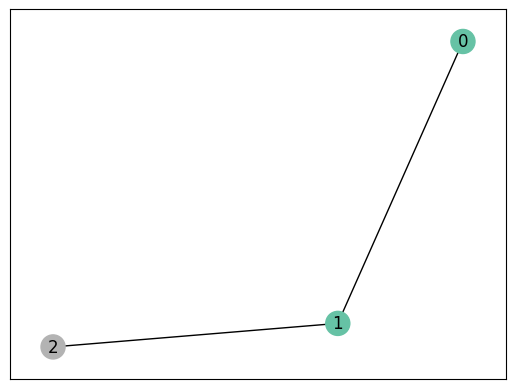

In [7]:
# Example graph visualisation
from torch_geometric.utils import to_networkx
import networkx as nx

# First, convert torch_geometric graph to a networkx graph:
G = to_networkx(data, to_undirected = True) # can use to_undirected as our graph is undirected

# Define graph layout; this is random with constraints to ensure the graph looks nice
layout = nx.spring_layout(G, seed = 0)

# Plot the graph
# Color nodes based on the class of the node
nx.draw_networkx(G, pos = layout, node_color = data.y, cmap = 'Set2', with_labels = True)

Because this code just plots the graph on a matplotlib `Axis` object, we can then add any other kinds of plot formatting we want to in the same way we have done matplotlib plotting before. 

Generally this works fine for small graphs, but plots can of course become very crowded if we have large graphs.

<div style="background-color:#0000">

### Example

Using the PyTorch Geometric `Data` constructor, define a graph in Python with the following nodes and edges:

* 10 nodes, each with 12 features:
    * 10 features are one-hot encoded node IDs i.e. node 1 has the first feature equal to 1 and all others 0, node 2 has first node equal to 0, second to 1, rest 0, etc.
    * Last 2 features are randomly generated values between 0 and 1

* Each node should have 1 of 3 classes, randomly assigned

* Edges given by this adjacency matrix:

$$\begin{pmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 1 & 1 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0
\end{pmatrix}$$

Remember that to instantiate a `Data` object you need a list of edge indices, i.e. node index pairs for each edge. This graph is symmetric and so each edge should be represented twice in your edge index list, once for each direction.


Data(x=[10, 12], edge_index=[2, 22], y=[10])


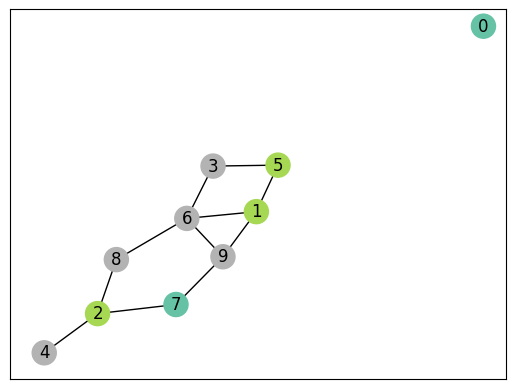

In [8]:
# Your code here
from torch_geometric.data import Data

x = torch.zeros(10, 12)  # 10 nodes with 12 features each
for i in range(10):
    x[i,i] = 1.0 # One-hot encoding for node features

x[:, 10:] = torch.rand(10,2) # Last two features are random

#create edge index pairs
edge_pairs = [
    (1,5), (5,1), (1,6), (6,1), (1,9), (9,1),
    (2,4), (4,2), (2,7), (7,2), (2,8), (8,2),
    (3,5), (5,3), (3,6), (6,3), (6,8), (8,6),
    (6,9), (9,6), (7,9), (9,7)
]

#convert to tensor
edge_index = torch.tensor(edge_pairs).t().contiguous()

y = torch.randint(0, 3, (10,))  # Random class 0,1,2 for each node 

data = Data(x=x, edge_index=edge_index, y=y)

print(data)

nx.draw_networkx(to_networkx(data, to_undirected=True), pos=nx.spring_layout(to_networkx(data, to_undirected=True), seed=0), node_color=data.y, cmap='Set2', with_labels=True)

# (1,5), (5,1)
# (1,6), (6,1)
# (1,9), (9,1)
# (2,4), (4,2)
# (2,7), (7,2)
# (2,8), (8,2)
# (3,5), (5,3)
# (3,6), (6,3)
# (6,8), (8,6)
# (6,9), (9,6)
# (7,9), (9,7)


## Datasets

Much like in PyTorch, when we come to actually set up our data for any kind of machine learning we want to collate it into some convenient structure for loading training, validation, and test data. 

In keeping with the PyTorch definitions, PyTorch Geometric also calls this object the `Dataset`. To see how this works, we will use a couple standard benchmarking datasets for graph learning problems, namely one where we want to learn a property of a whole graph, and one where we want to classify nodes. These are available in PyTorch Geometric in the `torch_geometric.datasets` module. 

We will start with the ENZYMES dataset from the [TUDataset collection](https://chrsmrrs.github.io/datasets/). This is derived from the [BRENDA database of enzymes](https://pubmed.ncbi.nlm.nih.gov/14681450/) where the graph for each enzyme describes the structural, sequential and chemical information in the same manner as first proposed [here](https://pubmed.ncbi.nlm.nih.gov/15961493/). The target to predict is what chemical reaction is catalysed by the enzyme.



In [11]:
from torch_geometric.datasets import TUDataset

# This will download the ENZYMES dataset
dataset = TUDataset(root='data', name = 'ENZYMES')

The PyG `Dataset` in general has similar syntax to the `Dataset` class in PyTorch, with some of the added features we have for `Data` objects in PyG and some other utility functions:

In [12]:
# Get number of graphs in the dataset
print(f"Dataset contains {len(dataset)} graphs")

# Get number of classes
print(f"Dataset contains {dataset.num_classes} classes")

# Get number of node features
print(f"Dataset has {dataset.num_node_features} node features")

Dataset contains 600 graphs
Dataset contains 6 classes
Dataset has 3 node features


We can index the dataset to get individual graphs:

In [13]:
graph = dataset[0]
print(graph)

# Check if graph is directed
print(f"Is graph undirected: {graph.is_undirected()}")

Data(edge_index=[2, 168], x=[37, 3], y=[1])
Is graph undirected: True


From this we know that this graph:

* Has 37 nodes, each with 3 features
* Is undirected, so has 168/2 = 84 undirected edges
* Is assigned to exactly 1 class

Also, we know that this data object is holding only 1 graph-level target, no node or edge-level targets.

Unlike the PyTorch `Dataset`, where we have to access `Dataset.data` and `Dataset.target` (or manually create `Subset` objects, see [the documentation](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Subset)) to take slices of the dataset, we can instead take slices straight from the `Dataset` in PyTorch Geometric. Let's define train, validation, and test datasets in a 80:10:10 ratio:

In [14]:
train_set = dataset[:480]
valid_set = dataset[480:540]
test_set = dataset[540:]

print(f"Train set has {len(train_set)} graphs")
print(f"Validation set has {len(valid_set)} graphs")
print(f"Test set has {len(test_set)} graphs")

Train set has 480 graphs
Validation set has 60 graphs
Test set has 60 graphs


If we want to shuffle the dataset, we can use the `shuffle` method. We can check this by comparing the first graph in the shuffled dataset with the first graph we defined earlier:

In [15]:
dataset_shuffled = dataset.shuffle()
graph_shuffled = dataset_shuffled[0]

print(graph)
print(graph_shuffled)

Data(edge_index=[2, 168], x=[37, 3], y=[1])
Data(edge_index=[2, 86], x=[24, 3], y=[1])


As we can see, these two must be different graphs as they have a different number of nodes and edges. 

Now we will try looking at a dataset for a semi-supervised node classification: the [Cora dataset](https://link.springer.com/article/10.1023/A:1009953814988). This dataset is a citation graph of 2708 computer science papers, with 7 different classes. Each publication is described by a word vector with values of 1 or 0, indicating the presence or absence of the correspdoning word in a dictionary of 1433 unique words. If a given publication has $N$ 1s in its node feature vector, it means it has $N$ words from the dictionary in the publication.

The Cora dataset was one of the datasets used in a paper describing a semi-supervised learning framework with node embeddings called [Planetoid (Predicting Labels And Neighbors with Embeddings Transductively Or Inductively from Data)](https://arxiv.org/abs/1603.08861); we will talk about **embeddings** in the context of graph neural networks in the next section.

<center>
<img src="plots/cora_vis.png" width=500 align="center">
</center>
<div style="text-align:center;">
<div style='width:600px;display:inline-block;vertical-align:top;margin-top:10px;'>

*Visualisation of the structure of the Cora dataset [[source](https://graphsandnetworks.com/the-cora-dataset/)].*
</div></div>

As before, this dataset can be downloaded & loaded easily using PyG:

In [17]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='data', name = 'Cora')

We will examine the dataset now:

In [19]:
print(f"Dataset contains {len(dataset)} entries")
print(f"Dataset has {dataset.num_classes} classes")
print(f"Dataset has {dataset.num_node_features} node features")

Dataset contains 1 entries
Dataset has 7 classes
Dataset has 1433 node features


We can see that this dataset has only 1 graph in it; we can look at this in more detail:

In [20]:
data = dataset[0]
print(data)

print(f"Is the graph undirected: {data.is_undirected()}")
print(f"Does the graph have any self loops: {data.has_self_loops()}")
print(f"Any isolated nodes: {data.has_isolated_nodes()}")


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Is the graph undirected: True
Does the graph have any self loops: False
Any isolated nodes: False


Some key observations:

* The graph has 2708 nodes
* The graph is undirected
* No self loops in the graph
* No isolated nodes in the graph

We also have some other attributes in this `Data` object that we haven't seen before - namely, `train_mask`, `val_mask`, and `test_mask`. This is because we are looking at a node-level problem here - so we need to separate the **nodes** into training, validation, and test datasets. This is done by having a boolean array for each of these, hence why each of `train_mask`, `val_mask`, and `test_mask` is an array of length 2708, the number of nodes in the graph.

We can find the number of nodes in each of the subsets:

In [21]:
print(f"Number of training nodes: {data.train_mask.sum().item()}")
print(f"Number of validation nodes: {dataset.val_mask.sum().item()}")
print(f"Number of test nodes: {data.test_mask.sum().item()}")


Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


Note that the sum of the training, validation, and test datasets is not equal to the total number of graphs in the dataset; in general we may not want to use the default training/validation/test masks defined for a dataset loaded in PyG.

## DataLoaders

As in PyTorch, we can use a `DataLoader` object in PyTorch Geometric to more efficiently load data for training. This also has some additional subtleties we will discuss. The general syntax for `torch_geometric.loader.DataLoader` is similar to the equivalent in PyTorch, which we will show with the ENZYMES dataset:

In [22]:
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='data', name = 'ENZYMES', use_node_attr = True)
loader = DataLoader(dataset, batch_size = 32, shuffle = True)

for idx, batch in enumerate(loader):
    if idx==0:
        print(batch)
        print(f"Number of graphs in batch: {batch.num_graphs}")

DataBatch(edge_index=[2, 4176], x=[1069, 21], y=[32], batch=[1069], ptr=[33])
Number of graphs in batch: 32


The `DataBatch` class inherits from the `Data` class, but adds an additional attribute `batch`; this maps each node to its respective graph in the batch. Otherwise `DataBatch` essentially aggregates the nodes and edges from all of the graphs in the batch; `batch.num_nodes` is equal to the sum of the number of nodes across all graphs in the batch.

You can also then apply functions across the batch from `torch_scatter`:

In [23]:
from torch_geometric.utils import scatter

for idx, batch in enumerate(loader):
    if idx == 0:
        print(data)
        print(f"Number of graphs in batch: {batch.num_graphs}")
        x = scatter(batch.x, batch.batch, dim = 0, reduce = 'mean')
        print(f"Shape of batched result: {x.size()}")

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of graphs in batch: 32
Shape of batched result: torch.Size([32, 21])


We can see the output has shape $(N_{\text{batch}},\,N_{\text{node features}})$. We have calculated the mean of each node feature per graph. For more operations that can be applied in this way, see the `torch_scatter` [documentation](https://pytorch-scatter.readthedocs.io/en/latest/).

There are also a number of other types of loader functions in PyTorch Geometric, for different sampling methods and handling of very large graphs to batch nodes in subgraphs. You can read about this in the [`torch_geometric.loader` documentation](https://pytorch-geometric.readthedocs.io/en/stable/modules/loader.html).

## Data Transforms

As we saw for CNNs, it is useful to be able to apply transforms to our data as we load it in; this could be to augment our dataset such as adding noise, normalising feature scales, or converting input data into the type of data we need for our ML method. 

<!-- for some reason can't get torch_cluster to work so can't do point cloud -> graph example -->

Much like `torchvision.transforms`, we can use `torch_geometric.transforms` for graph data. For example, consider our London Underground example, and let us assign a position to each node based on the position of the station relative to Imperial College. Some transformations we could then apply include:

* `RandomJitter` : add random translations to all nodes

* `NormalizeFeatures` : normalise the node features

* `Distance` : add a feature to all edges corresponding to the Euclidean distance between the nodes that edge links

We can also combine a chain of transformations like in PyTorch using `Compose`, and we can pass these to `Dataset` objects to transform our data as it is read in. There are many options for transforms, which you can read more about in the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html).

## Summary

In this section, we have covered the basics of using graphs in Python with PyTorch Geometric, including:

* How graphs are represented in PyTorch Geometric

* `Datasets` and `DataLaoders` for graph data

* Transforms for pre-processing our data

In the next section, we will discuss how we structure graph neural networks for graph data tasks.

<hr style="border:2px solid gray">

## Intro to GNNs <a id='embeddings'></a>[^](#index)


Now we have an understanding of how we define graph data and what we want to achieve with graph learning, we can get to how we actually tackle these problems. 

We have **a lot** of information in a graph, but not all of it may be useful, and often in machine learning we have to come up with features from our data which can be difficult and time-consuming, with no guarantee you come up with the "best" features to solve your problem. Instead, for graph data, we try to skip any feature engineering and instead learn a **representation** of the graph. 

What does this mean? The basic idea is as follows:

* If nodes are similar in the graph, node labels should be similar or the same

* It is hard to make features from a network, and can take a lot of time

* If instead we map each node and its local structure to some $d$-dimensional vector, we can summarise information more effectively

We call these $d$-dimensional vectors **node embeddings**, and we refer to the $d$-dimensional space they occupy as the **embedding space**. 

We can make an analogy with the neural networks we have looked at previously:

* After we apply our linear or convolutional layers but before we reach the output layer, our data is in some hidden state

* The embedding space is the graph equivalent of this hidden state


If two nodes are "similar" in structure and features in the graph, then they should be geometrically close in the embedding space.

How can we determine what the embeddings for our graph should be? That is where the **encoder-decoder** structure comes in.

## Encoder-Decoder structure

What do we mean by encoder-decoder? We want to define two operations that we chain together to act on our graph nodes:

* **encoder** : transforms a given node to the embedding space, depending on the features of the node and its structure

* **decoder** : maps a pair of node embeddings to some similarity score in the original graph

The operation of the decoder is typically fixed, e.g. taking a dot product between the two embeddings. As a result, we want to optimize the encoder such that the decoder output is approximately equal to the similarity measure we consider. 

A graphic illustrating the action of an encoder can be seen below.

<center>
<img src="plots/node_embeddings.png" align="centre" width=600></img>
</center>

<div style="text-align:center;">
<div style='width:500px;display:inline-block;vertical-align:top;margin-top:10px;'>
<div style="text-align:justify;">

*A schematic illustrating an encoder mapping nodes from a graph into an embedding space [[source](https://snap-stanford.github.io/cs224w-notes/machine-learning-with-networks/node-representation-learning)].*
</div></div></div>

We can define our embeddings in a number of ways, starting from so-called **shallow embeddings** where we learn a single embedding for every node, which are discussed in more detail in [Appendix C](#appendix-c). However, like we saw with neural networks a single layer can only perform so well. Instead, for better performance in graph learning tasks we turn to **deep embeddings**.

### Deep embeddings

The basic idea of a deep encoder is similar to the idea that motivates deep neural networks: if we have several consecutive layers of non-linear operations, we should be able to approximate any function and so find an optimal embedding for our problem. 

You might think that we could just go straight to applying a standard fully-connected neural network or a CNN, but we encounter an issue unique to graph data: graphs have no "true" ordering. This means two things:

* Any representation of the whole graph should be independent of the graph ordering

* Any representation of a node should be independent of the graph ordering

This leads to two separate but equally important characteristics for any function that we apply to our graph data to learn an embedding: **permutation-invariance** and **permutation-equivariance**. Any of the graph layers we will use from PyTorch Geometric will be one of these so we don't need to worry about it too much here. More details about these properties can be found in [Appendix D](#appendix-d).

The layers we have used so far in fully-connected and convolutional neural networks do not satisfy this condition; instead, we must define new layers for graph neural networks which rely on so-called **message passing** and **aggregation** of information from neighbours.

## GNN layers: message passing and aggregation

Now we understand the requirements for layers in a deep encoder, we need to work out how to put this together into something that can learn node embeddings for our graph. 

A general GNN layer defines two main parts:

* how we summarise information from a node, referred to as the **message** from that node

* how we combine the messages from neighbouring nodes to calculate an embedding for the node of interest, referred to as **aggregation**

We can define either of these in almost whatever way we like, so long as all of our operations are either permutation-invariant or permutation-equivariant. 

For fully-connected NNs and CNNs, we used linear layers and convolutional layers to combine inputs to produce an output. For graphs, we use message passing followed by aggregation to combine information from neighbouring nodes to produce an embedding for a given node. This is illustrated in the following schematic.

<div style="display: flex; justify-content: center; gap: 80px; align-items: flex-start;">
<div style="display: flex; flex-direction: column; align-items: flex-start; width: 500px; margin: 0;">
<img src='plots/message-pass-agg-graph.png' width=500 style="align-self: center;"/>
<div style="margin-top: 10px; text-align: justify; max-width: 500px; font-style: italic; line-height: 1.2;">

<strong>Left</strong>: The graph to be considered, where we want to find an embedding for node B.
</div>
</div>
<div style="display: flex; flex-direction: column; align-items: flex-start; width: 500px; margin: 0;">
<img src='plots/message-pass-agg-flow.png' width=500 style="align-self: center;"/>
<div style="margin-top: 10px; text-align: justify; max-width: 500px; font-style: italic; line-height: 1.2;">

<strong>Right</strong>: To calculate an embedding for node B, first we find the message from each its neighbouring nodes and then aggregate them.
</div>
</div>
</div>

<div style="text-align:center;">
<div style='width:500px;display:inline-block;vertical-align:top'>
<div style="text-align:justify;">

*Illustration of the message passing procedure to find an embedding for a given node.*
</div></div></div>

We can think about this process in analogy with convolutional layers in CNNs:

* In a CNN, we "slide" our kernel across the image and find the convolution of the kernel and the image pixels it covers

* In a GNN, when we do message passing from a node's neighbourhood, we effectively find the convolution of the neighbouring nodes and the layer weights

This comparison is illustrated in the schematic below. Please note that while we call the operation across the neighbouring nodes a convolution, it is not necessarily a convolution in general; we will see this for the first example GNN layer we discuss.

<center>
<img src='plots/image-vs-graph-conv.png' width = 1000/>
</center>

<div style="display: flex; justify-content: center; gap: 80px; align-items: flex-start;">
<div style="display: flex; flex-direction: column; align-items: flex-start; width: 400px; margin: 0;">
<div style="margin-top: 10px; text-align: justify; max-width: 400px; font-style: italic; line-height: 1.2;">

<strong>Left</strong>: example of a convolutional kernel on an image from the CIFAR10 dataset, to show how image pixels are aggregated in a convolutional layer.
</div>
</div>
<div style="display: flex; flex-direction: column; align-items: flex-start; width: 400px; margin: 0;">
<div style="margin-top: 10px; text-align: justify; max-width: 400px; font-style: italic; line-height: 1.2;">

<strong>Right</strong>: example of graph message passing, to show how neighbouring nodes are aggregated for a graph convolution.
</div>
</div>
</div>

<div style="text-align:center;">
<div style='width:500px;display:inline-block;vertical-align:top'>
<div style="text-align:justify; margin-top: 10px">

*Comparison of input aggregation in an image convolution and a graph convolution.*

</div></div></div>

We will illustrate the general GNN principle by way of example with the simplest GNN layer, based on the original GNN models proposed by [Merkwirth and Lengauer (2005)](https://pubs.acs.org/doi/10.1021/ci049613b) and [Starselli et al. (2009)](https://ieeexplore.ieee.org/document/4700287).

### An example GNN layer

As discussed, we need to define the message we pass from a node, and how we aggregate messages from nodes. We will start with the functional form of the embedding update, and then discuss how each component works.

<div style="background-color:#0000">

Let the embedding at layer $k$ for node $v$ and node $u$ be denoted as $\mathbf{h}_v^{(k)}$ and $\mathbf{h}_u^{(k)}$ respectively. We also define the following:

* $\mathbf{h}_v^0$ = $\mathbf{x}_v$ i.e. the first layer embedding for node $v$ is the vector of node features for node $v$

* $\text{N}(v)$ denotes the neighbourhood of $v$ i.e. the set of nodes that are directly connected to $v$

The embedding for node $v$ in layer $k+1$ is given according to:

$$\mathbf{h}_v^{(k+1)} = \sigma\left(\sum_{u\,\in\,\text{N}(v)} \left[\mathbf{W}_{\text{neigh}}^{(k)} \mathbf{h}_u^{(k)}\right] + \mathbf{W}_{\text{self}}^{(k)} \mathbf{h}_v^{(k)} + \mathbf{b}^{(k)}\right),$$


where all symbols are defined as follows:

* $\sum_{u\,\in\,\text{N}(v)}$ denotes a sum over all nodes in the neighbourhood of $v$

* $\mathbf{W}_{\text{neigh}}^{(k)}$ and $\mathbf{W}_{\text{self}}^{(k)} \in \mathbb{R}^{d_k \times d_{k\,-\,1}}$ are the layer $k$ weight matrices for neighbouring nodes and the node of interest respectively; $d_k$ and $d_{k\,-\,1}$ denote the dimension of the embedding space at layer $k$ and $k - 1$ respectively

* $\mathbf{b}^{(k)} \in \mathbb{R}^{d_k}$ denotes a learnable bias vector for layer $k$

* $\sigma$ denotes a nonlinear activation function like ReLU, sigmoid, etc. to add non-linearity to our operation

So from this, we can see the process of a single layer for a given node goes as follows:

* Calculate the message for each node in the neighbourhood of the relevant node

* Sum the neighbourhood messages

* Add the message of the relevant node from its previous layer embedding and a bias vector

* Apply a non-linear activation function to the aggregated messages

We can chain layers of this kind together in order to produce a deep graph neural network. Like in a CNN, as we go deeper in our GNN our embeddings become more and more abstract and are influenced by nodes further and further away. 

A schematic illustrating how we find the second layer embedding for a given node in an example graph is shown below.

<div style="display: flex; justify-content: center; gap: 30px; align-items: flex-start;">
<div style="display: flex; flex-direction: column; align-items: flex-start; width: 450px; margin: 0;">
<img src='plots/feat-init-graph-pass.png' width=450 style="align-self: center;"/>
<div style="margin-top: 10px; text-align: justify; max-width: 450px; font-style: italic; line-height: 1.2;">
<div style="height: 1.5px;"></div>
<strong>Left</strong>: the graph considered to derive a second layer embedding for node B.
</div>
</div>
<div style="display: flex; flex-direction: column; align-items: flex-start; width: 500px; margin: 0;">
<img src='plots/hidden2-embed-pass.png' width=500 style="align-self: center;"/>
<div style="margin-top: 10px; text-align: justify; max-width: 500px; font-style: italic; line-height: 1.2;">

<strong>Right</strong>: contributions to the 2nd layer embedding $h^{(2)}_B$ from the 1st layer embeddings $h^{(1)}_i$ of its neighbouring nodes. Each node 1st layer embedding has contributions from the node features $X_i$ from their neighbouring nodes.
</div>
</div>
</div>

<div style="text-align:center;">
<div style='width:500px;display:inline-block;vertical-align:top'>

*Illustration of the message passing procedure to find an embedding for a given node.*
</div></div>

<div style="background-color: #0000">

Note: sometimes, rather than explicitly defining self weight matrix $\mathbf{W}_{\text{self}}^{(k)}$, we may instead change the summation from over $u \in \text{N}(v)$ to $u \in \text{N}(v) \cup v$ i.e. we sum over the union of the neighbourhood of $v$ and $v$ itself. This has the following consequences: 

* Effectively this adds self-loops to the adjacency matrix of our graph

* We can then use the same weight parameters for both the neighbourhood and the node's own embedding

* This reduces the number of parameters we need to learn and can make training more efficient. 

However, we can lose information doing this as we can no longer separately learn contributions from the neighbourhood and the node's previous embedding, so this may not always be the best approach and it is in general problem-dependent.



While here we have only considered our messages being the output of a linear layer applied to our node embeddings, in general we could include any of the layers in our neural network toolbox, including:

* Dropout

* Batch normalisation

* Activation functions

We group these methods and the linear layer we have considered already as transformations of the node embedding, and then we apply whatever aggregation function we have chosen across the transformed node embeddings in the neighbourhood. 

In fact, if can even be worth replacing our simple single linear layer with an MLP, if we need more capacity in our network. This becomes more necessary for complex problems where a few GNN layers is not enough - see the next section.

The parameters we learn in training our GNN are the parameters of the message passing network, which are reused for every node. We could in general make this network as deep as we like to improve the performance of our GNN, using everything we have learned so far about building neural networks.

## Stacking GNN layers

For both fully-connected and convolutional neural networks, we know that increasing the depth increases the complexity of the functions we can model with the network. However, this principle does not apply to graph neural networks - specifically, if we stack too many GNN layers, we encounter an issue referred to as the **oversmoothness problem**. This is explained as follows:

* For $k$ GNN layers, each node embedding has contributions from nodes $k$
    * In the first layer, contributions from neighbouring nodes are just the node features
    * In the second layer the contributions from neighbouring nodes are the 1st layer embeddings, which are determined by node features from their neighbouring nodes; this means our node of interest has contributions from the features of nodes of next-nearest neighbours (i.e. a 2 hop neighbourhood)
    * This continues as we add more layers

* As $k$ increases, the **receptive field** of each node increases - this is the set of nodes that contribute to the $k^{\text{th}}$ layer embedding at our node

* For large $k$ (relative to the size of the graph), each node can have contributions from most of the rest of the graph

* As a result, with many GNN layers all embeddings can converge to the same value

The schematic below shows two nodes of interest, and their overlapping neighbours as we increase the number of hops i.e. as we add more layers to our GNN. With just 3 GNN layers, the two nodes already overlap on nearly all of the nodes in the graph!

<center>
<img src='plots/oversmoothness.png' width=800></img>
</center>

<div style="text-align:center;">
<div style='width:760px;display:inline-block;vertical-align:top'>
<div style="text-align: justify;">

*An example 50 node network with two nodes of interest, illustrating what nodes are neighbours shared between the nodes of interest for increasing number of hops. While for a 1 hop neighbourhood they only have 1 node in common, by the time we have a 3 hop neighbourhood nearly every node in the network is a common neighbour for our two nodes of interest.* 

</div></div></div>

This isn't to say we can't or shouldn't chain GNN layers together, but we need to be careful how many we use. There are a few methods we can use to mitigate this:

* Increase the complexity of individual layers, e.g. replace message linear layer with a full multilayer perception

* Add non-GNN layers before/after the GNN layers, e.g. MLPs to preprocess node features to a lower dimension

* Add **skip connections**: routes by which embedding values can be passed to the next layer without applying the function in between; we can interpret this as instead of applying a function $F$ to an input $\mathbf{x}$ and just returning $F(\mathbf{x})$, we instead return $F(\mathbf{x}) + \mathbf{x}$ 
    
    * This is motiviated by observations that embeddings in earlier layers can sometimes be more informative for e.g. classification than those in later layers

    * This essentially creates a mixture of models, of shallow and deep GNNs

    * We can even have skip connections from every layer to the end, so the final prediction is based on the embeddings output at every layer rather than just the final layer embeddings

    * GCN layers implicitly do this by adding the relevant node's previous layer embedding


## Training and prediction with GNNs

So far we have talked about how we can define a GNN, but how can we train it, and how can we make predictions to solve the kinds of tasks we want to solve? To start with, let's recap a few types of task we might be trying to solve:

* node-level prediction: classification, regression, clustering

* edge-level prediction: classification, regression, predicting edge existence

* graph-level prediction: classification, regression

As you can imagine, there is not one single method by which we can do all of these tasks. Instead, we have to consider different kinds of **prediction head**. 



### Prediction heads

A prediction head is the part of our GNN that goes from the node embeddings output by the encoder to whatever it is we want to predict, e.g. a node class, if an edge exists or not, or some property of the whole graph. To consider each of these in turn: 

* Node-level tasks: use the node embeddings as the input to a model to perform the task we desire, e.g. for $N$-class classification can use a linear layer from $d$ embedding features to $N$ classes

* Edge-level tasks: edges link pairs of nodes, so we must somehow aggregate the pair of node embeddings e.g. using standard linear algebra methods to combine two vectors such as dot products etc.

* Graph-level tasks: we need to aggregate over all of the node embeddings to get a single embedding for the whole graph, e.g. via some global pooling like mean pooling.

For both edge and graph tasks, we can apply standard methods to the aggregated edge or graph embeddings. The schematics below illustrate each type of prediction head.

<div style="display: flex; justify-content: center; gap: 30px; align-items: flex-start;">
<div style="display: flex; flex-direction: column; align-items: flex-start; width: 330px; margin: 0;">
<img src='plots/node-prediction-head.png' width=330/>
<div style="margin-top: 10px; text-align: justify; max-width: 320 px; font-style: italic; line-height: 1.2;">

<strong>(a)</strong>: a node prediction head - we can directly use the node embeddings for predicting individual node properties.
</div></div>
<div style="display: flex; flex-direction: column; align-items: flex-start; width: 330px; margin: 0;">
<img src='plots/edge-prediction-head.png' width=330/>
<div style="margin-top: 10px; text-align: justify; max-width: 320 px; font-style: italic; line-height: 1.2;">

<strong>(b)</strong>: an edge prediction head - we aggregate pairs of node embeddings to get an edge embedding, used to make predictions for edge-level tasks.
</div></div>
<div style="display: flex; flex-direction: column; align-items: flex-start; width: 330px; margin: 0;">
<img src='plots/graph-prediction-head.png' width=330/>
<div style="margin-top: 10px; text-align: justify; max-width: 320 px; font-style: italic; line-height: 1.2;">

<strong>(c)</strong>: a graph prediction head - we aggregate all nodes across the graph to get a single graph embedding, which is used for prediciton of graph-level values.
</div></div>
</div>
<div style="text-align:center;">
<div style='width:500px;display:inline-block;vertical-align:top'>

*Illustration of various types of prediction head.*
</div></div>



There are some more subtleties for the aggregation for edges or graphs, which you can read more about in [Appendix E](#appendix-e).
    

To put this in the context of the encoder-decoder structure, we can think of whatever operation we apply to the deep node embeddings (or edge embeddings, or graph embedding) to get to our target, be that a class, continuous value, or cluster ID, as the decoder. 

For example, for node classification our decoder could be a fully-connected neural network that outputs the class of the node. The parameters of this neural network are trained at the same time as the encoder parameters, creating a complete GNN. 


### How to train a GNN

When it comes to training a GNN, the general procedure is much the same as all of the different ML techniques we have looked at so far:

* Define a (differentiable) loss function that measures how close our prediction is to what we want to get

* Separate data into training, validation, and test datasets

* Pass training data through the GNN, record the predictions and calculate the loss

* Update all the parameters of the GNN according to some optimisation algorithm e.g. gradient descent

When we consider our loss function for supervised learning problems we can use the same functions we have seen before:

* Regression: mean squared error, mean absolute error, etc

* Classification: cross entropy, negative log likelihood, etc

<!-- <div style="background-color: #FFF8C6"> -->

### Transductive vs inductive training

When we are considering graph learning tasks, are working with either an **inductive** or a **transductive** setting. These are defined as follows:

<br>

* **inductive setting**: exactly what we have done for ML so far: training, validation, and test datasets are strictly separated

    * This prevents any learning on the validation or test datasets, with the aim of generalising beyond the training dataset

    * In the context of graphs, we can consider two different scenarios:

        * A graph-level task: each graph is independent of the other graphs, so it is easy to have completely separate sets for training, validation, and testing

        * A node or edge task: in GNNs, predictions for nodes and edges implicitly depend on any other nodes or edges they are connected to, via the message-passing framework - so we have to make sure any non-training objects are *removed entirely from the graph*

            * For a node-level example, for an inductive scenario we must break any edges linking non-training nodes to training nodes, so they cannot influence the learning on the training nodes

            * No structure from non-training set nodes is included

            * This lets us generalise to new nodes added to the graph, but may have worse general performance
            
<br></br>

* **transductive setting**: training, validation, and test sets are not entirely separate: non-training nodes are kept in the graph but with no labels

    * Non-training nodes can still inform prediction on training nodes through message passing

    * The model parameters **do not** learn labels for non-training nodes, just for training nodes

    * Training node learning is implicitly informed by the node features of its neighbours, even if they aren't training nodes
    
    * Some properties of this include:

        * Generally improved performance within the same graph

        * Cannot generalise to new nodes added to the graph
        
        * Not possible for e.g. graph-level classification as each graph is independent of the other graphs



Often, we might find that transductive learning is good for tasks where we have very few labelled instances, as we can make use of other data whereas an inductive approach would be stuck with just the labelled data. You will see examples of both types in the exercises later in this notebook.

### Graph manipulation

Sometimes the graph we want to do some task with simply is not the optimal graph to use, and instead requires some manipulation. This is just another way to say sometimes our graph needs preprocessing, but at the graph level rather than just the feature level. This can include feature augmentation, but also handling of graphs that are either too sparse or too dense. For more details, see [Appendix F](#appendix-f).



## Summary

In this section, we have covered:

* What node embeddings are and how they can be found with the encoder-decoder structure

* How we build GNN layers to find deep node embeddings

* How to go from node embeddings to different kinds of prediction for our graph learning tasks

* Some issues that can be encountered with GNNs and graph data, and how they can be mitigated

In the following section, we will discuss how we build and train GNNs in Python using PyTorch Geometric.

<hr style="border:2px solid gray">

## Building and training GNNs in PyTorch Geometric <a id='pyg-gnn'></a>[^](#index)


Now we have discussed what GNNs are and how we can train them, we will cover how to actually build and train a GNN using PyTorch Geometric. We will first step through the main things we need to consider, and then put it all together as an example with a simple but classic graph dataset: [Zachary's karate club network](https://www.journals.uchicago.edu/doi/abs/10.1086/jar.33.4.3629752).

## GNN layers in PyTorch Geometric

PyTorch Geometric has many different GNN layers pre-defined for you, to make building and training GNNs as easy as possible. Because PyG is built on top of regular PyTorch, the syntax and structure for building models is also much the same as we have seen before. 

The most basic layer implemented in PyG is called `GCNConv`, which is the graph convolutional operator as defined in [this paper](https://arxiv.org/abs/1609.02907). This layer is very similar to the basic GNN layer we introduced above with self-loops added (so a single trainable weight matrix), but with normalisation factors based on the number of node neighbours added. We can instantiate this easily for a layer with 10 input dimensions and 3 output dimensions:

In [24]:
import torch_geometric.nn as gnn

gcn = gnn.GCNConv(10, 3)

It is exactly as simple as that; however, evaluating the output of the layer requires more than just our node features $\mathbf{x}$ and instead also requires our list of edge indices, so we can find the neighbourhood of each node. We can illustrate this with a simple example with node feature values randomly generated between 0 and 1:


In [25]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]])
x = torch.rand(size = (3, 10), dtype = torch.float)
data = Data(x = x, edge_index = edge_index)

output = gcn(data.x, data.edge_index)

print(output.shape)
print(output)

torch.Size([3, 3])
tensor([[0.0467, 0.5555, 0.1090],
        [0.0982, 0.4439, 0.2303],
        [0.0536, 0.2142, 0.1744]], grad_fn=<AddBackward0>)


We can see that the output of our layer now has 3 node features per node, and a standard gradient function assigned so we can train the layer parameters using standard gradient-based methods. We can examine the linear weight matrix and the bias vector:

In [27]:
print(f"Linear layer: {gcn.lin}, weights = {gcn.lin.weight}\n")
print(f"Bias vector: {gcn.bias}")

Linear layer: Linear(10, 3, bias=False), weights = Parameter containing:
tensor([[-0.1820, -0.1834, -0.3053, -0.0180, -0.1303,  0.4751,  0.4472,  0.2458,
         -0.4936,  0.4321],
        [ 0.6581,  0.6245, -0.2824, -0.4688,  0.4204, -0.1247, -0.0434, -0.6353,
          0.5767,  0.5469],
        [-0.4566,  0.2466, -0.3069,  0.2828,  0.5824, -0.3281,  0.4391,  0.2941,
         -0.3220,  0.1692]], requires_grad=True)

Bias vector: Parameter containing:
tensor([0., 0., 0.], requires_grad=True)


We can see the general structure of the parameters is very similar to `Linear` layers in regular PyTorch, but we have separated out the weights and the bias to apply the weights to determine our message and then apply the bias after aggregation. 


Of course, some of the more complex GNN layers that have been proposed and are defined in PyG can have more complicated syntax, but in general the syntax is very similar to regular PyTorch.

 The types of layers in PyG range from convolutional, like `GCNConv`, to aggregation, normalisation, pooling and more. For a full list of available layers, see the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html).

## Models in PyG

Because PyTorch Geometric is built on top of PyTorch, the way we put together models is very similar to all the neural networks we have looked at so far but often needs some extra syntax to account for graph data. 

Putting models together can either be done with `torch_geometric.nn.Sequential`, or by subclassing `torch.nn.Module` and manually specifying the `forward` method. We will put together a simple three layer GNN with both of these methods in the cells below.

We are going to prepare models with 34 inputs, hidden layer sizes of 4, 4, and 2, and an output size of 4 to correspond to the number of classes. We have selected 2 as the number of dimensions for the final hidden layer so we can easily visualise the embedding space at this layer.


<div style="background-color: #0000">

While here we have chosen our final hidden layer to have 2 output features so we can visualise the final layer embeddings in a 2D plot, in general we may want more features for our final embeddings to properly capture the full information in the graph. In this case, we can instead use dimensionality reduction techniques such as [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) or [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to project our embedding space down to 2 dimensions for visualisation. 

For an example of this, see [this PyG Colab tutorial for node classification](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX).


Because the inputs for PyG are more complicated than for regular PyTorch, if we use `Sequential` we have to declare at the start what our inputs are, and then for each layer we have to declare both the inputs and what it maps to:

In [28]:
import torch.nn as nn

model_sequential = gnn.Sequential('x, edge_index', [
                                  (gnn.GCNConv(34, 4), 'x, edge_index -> x'),
                                  (nn.LeakyReLU(), 'x -> x'),
                                  (gnn.GCNConv(4, 4), 'x, edge_index -> x'),
                                  (nn.LeakyReLU(), 'x -> x'),
                                  (gnn.GCNConv(4, 2), 'x, edge_index -> x'),
                                  (nn.LeakyReLU(), 'x -> x'),
                                  nn.Linear(2, 4)
                                  ])

This model will take an input graph with 34 node features, finding 4, 4, and 2 dimensional embeddings at layers 1, 2, and 3 respectively, and then applies a linear layer at the end to get to a four outputs corresponding to four possible classes. We have used a leaky ReLU as our activation function throughout.

The advantage of the PyG `Sequential` compared to the standard PyTorch `Sequential` is that because of this input declaration setup, we can more easily pass additional information into our model or add in skip connections without needing to exactly specify all the details of a `forward` method. 

Now we will try reproducing the same model by subclassing `torch.nn.Module`:

In [29]:
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = gnn.GCNConv(34, 4)
        self.conv2 = gnn.GCNConv(4, 4)
        self.conv3 = gnn.GCNConv(4, 2)
        self.lin = nn.Linear(2, 4)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv3(x, edge_index)
        x = F.leaky_relu(x)
        x = self.lin(x)
        return x
    
model_module = GCN()

As we have seen before the `forward` function is called when we pass data to the model. Because the `Batch` object returned by a `DataLoader` in PyG is a subclass of the `Data` object, we need to make sure we explicitly get the node features and edge index from the `Batch` in our `forward` method, as well as any other attributes of the data we might need for our model.

One other key kind of layer we need to be aware of are global pooling layers; this are necessary to aggregate our node embeddings to compute a whole graph embedding, for graph-level learning tasks. We can chain these with other GNN or normal NN layers - the following cell shows an example for both a `Sequential` and a subclassed `nn.Module` for a graph-level classification task, for some hypothetical data with 5 node features and 3 possible graph classes:

In [30]:
# define Sequential version
model_graph_sequential = gnn.Sequential('x, edge_index, batch', [
    (gnn.GCNConv(5, 20), 'x, edge_index -> x'),
    (nn.LeakyReLU(), 'x -> x'),
    (gnn.GCNConv(20, 20), 'x, edge_index -> x'),
    (nn.LeakyReLU(), 'x -> x'),
    (gnn.global_mean_pool, 'x, batch -> x'),
    nn.Linear(20, 3),
])

class GCN_graph(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = gnn.GCNConv(5, 20)
        self.conv2 = gnn.GCNConv(20,20)
        self.lin = nn.Linear(20, 3)

    def forward(self, data):
        # get node embeddings
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)
        # pool node embeddings to get graph embedding
        x = gnn.global_mean_pool(x, batch)
        x = self.lin(x)

        return x

model_graph_module = GCN_graph()

The internal batching procedure of PyTorch Geometric concatenates all the nodes across the graphs in the batch together, and the `batch` attribute of a `Batch` object identifies which nodes belong to which graph. As a result, to get accurate graph-level pooling of embeddings, we need to pass this attribute to the global pooling we use, in this case `global_mean_pool`. For a `Batch` called `data`, we can get this attribute with `data.batch`. 

There are many different options for pooling of node embeddings, which you can read more about in [the documentation](https://pytorch-geometric.readthedocs.io/en/2.5.3/modules/nn.html#pooling-layers).

## Zachary's karate club

As a brief aside, we need to load in our data before we can train a GNN. To do this, we will use the karate club dataset originally described in 1977. The social network of a karate club was studied by Wayne W. Zachary for a period of three years, who documented links between the 34 members of the club based on interactions outside the club. Eventually, the club split into two after a conflict between the instructor and the administrator, and with the data he had collected Zachary assigned all but one member to the correct group after the split.

For the purposes of machine learning on graphs, however, two classes is generally considered too simple to be interesting; instead, the [paper introducing Graph Convolutional Networks](https://arxiv.org/abs/1609.02907) demonstrated their performance by first clustering the karate club graph to find 4 classes, and then trained and predicted on the data. It is this version of the dataset that is saved in PyTorch Geometric.

Like in regular PyTorch, PyTorch Geometric has a separate module for many benchmark datasets for graph learning methods. We can import the dataset using `KarateClub`, and do the same inspections we have done so far for other datasets:

In [31]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

# Get number of graphs in the dataset
print(f"Dataset contains {len(dataset)} graphs")

# Get number of classes
print(f"Dataset contains {dataset.num_classes} classes")

# Get number of node features
print(f"Dataset has {dataset.num_node_features} node features")

data = dataset[0]

print(data)

print(f"Is the graph undirected: {data.is_undirected()}")
print(f"Does the graph have any self loops: {data.has_self_loops()}")
print(f"Any isolated nodes: {data.has_isolated_nodes()}")


Dataset contains 1 graphs
Dataset contains 4 classes
Dataset has 34 node features
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Is the graph undirected: True
Does the graph have any self loops: False
Any isolated nodes: False


As expected we can see that we have 1 graph with 4 classes. Each node has 34 features, which are not inherent to the original observations made by Zachary but instead are a one-hot encoding of the node IDs to allow application of GNNs (as discussed in the feature augmentation section previously). Most of the other properties of the graph are simple, with no self loops, no directed edges, and no isolated nodes.

Crucially, we can also look at how many nodes are in the training set by summing the train_mask:

In [34]:
print(f"Number of training nodes = {data.train_mask.sum()}")

Number of training nodes = 4


We have just 4 nodes in our training set, which corresponds to about 12% of all of our data. It is not uncommon to have significantly smaller proportions of training data in graph datasets, as it can be difficult to accurately label a large amount of data e.g. in social media networks to classify users as bots or not, it can be very time consuming to manually classify accounts.

We will use `networkx` here to visualise the graph, including some of our matplotlib formatting:

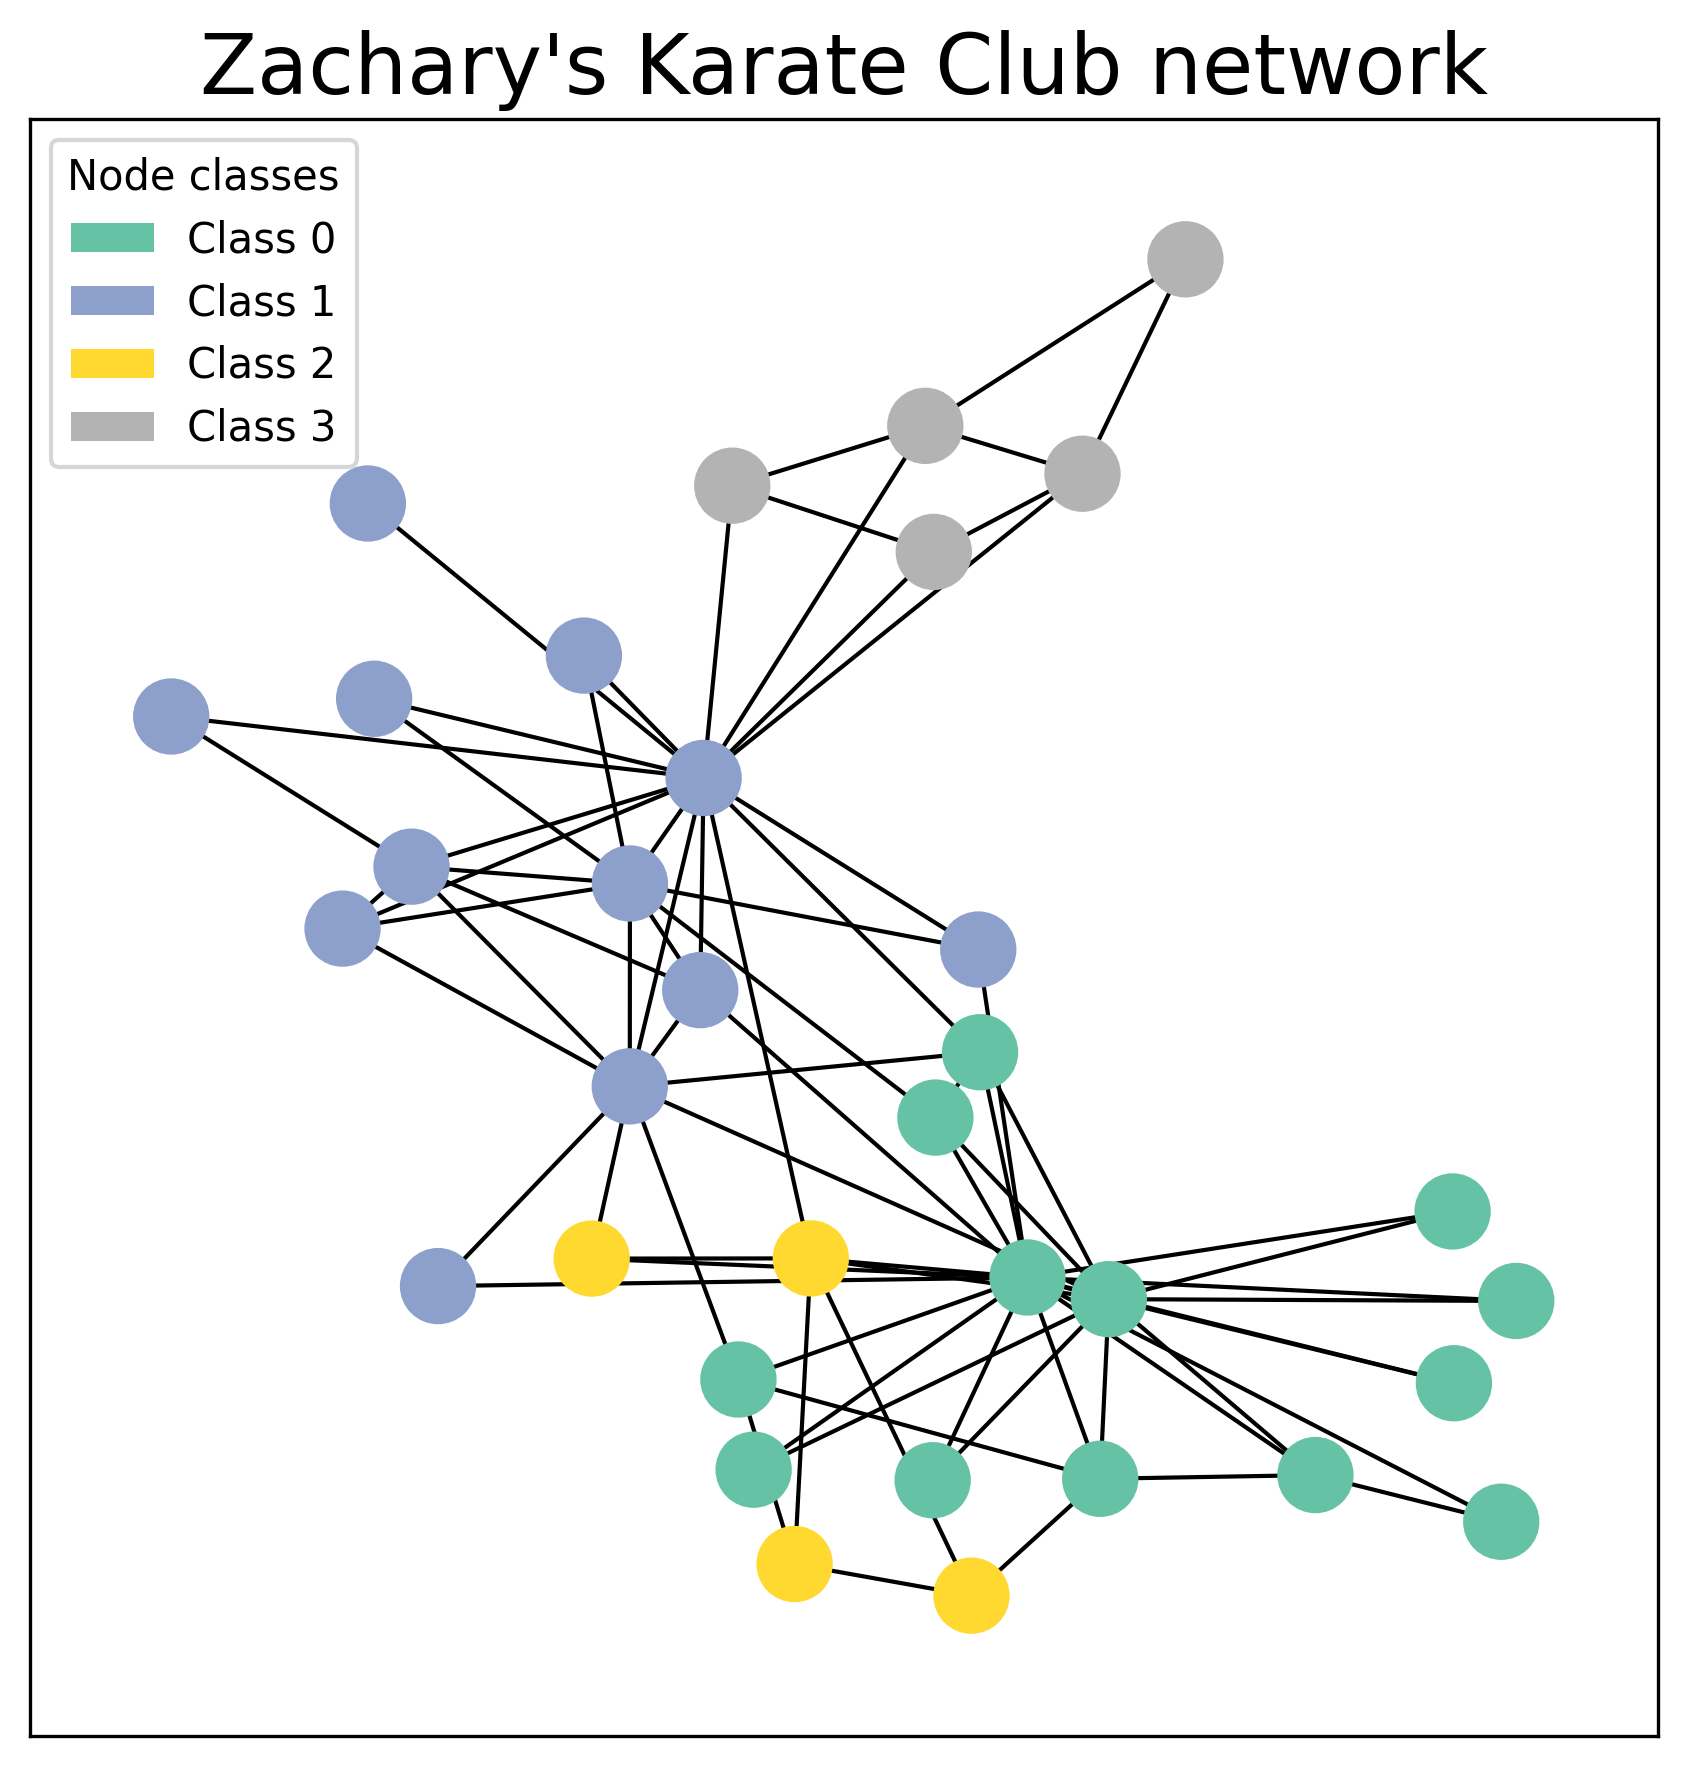

In [32]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

G = to_networkx(data, to_undirected = True)
fig = plt.figure(figsize = (7, 7), dpi = 300)
plt.xticks([])
plt.yticks([])
nx.draw_networkx(G, pos = nx.spring_layout(G, seed = 1), with_labels = False,
                 node_color = data.y, cmap = "Set2")
plt.title("Zachary's Karate Club network",fontsize = 20)

# Manually make a legend
from matplotlib.patches import Patch

Set2 = plt.get_cmap('Set2')
classes = data.y.unique()
legend_elements = [Patch(facecolor=Set2(i/(len(classes) - 1)), label = f'Class {i}') for i in data.y.unique()]
plt.legend(handles = legend_elements, title='Node classes', loc='upper left')

Because of the simplicity of this data, only a training mask is provided and then all other nodes are assumed to be test nodes.

We will now detail how we can train our previous GNN model setups on this data.

## Training GNNs

Because PyTorch Geometric is built on top of PyTorch, we train GNNs with the same steps we use for regular or convolutional neural networks: 

* Feed training data through the network to get the output

* Calculate loss between the output and the target values

* Calculate the gradient of the loss with respect to each parameter in the network

* Use the gradients to perform a step with the optimiser


Before we actually start training the GNN, let us define a model instance and then let us see what the final embeddings *for all nodes* look like without any training; we will redefine our module version of our model to allow it to return the embeddings as well as the final classifier outout:

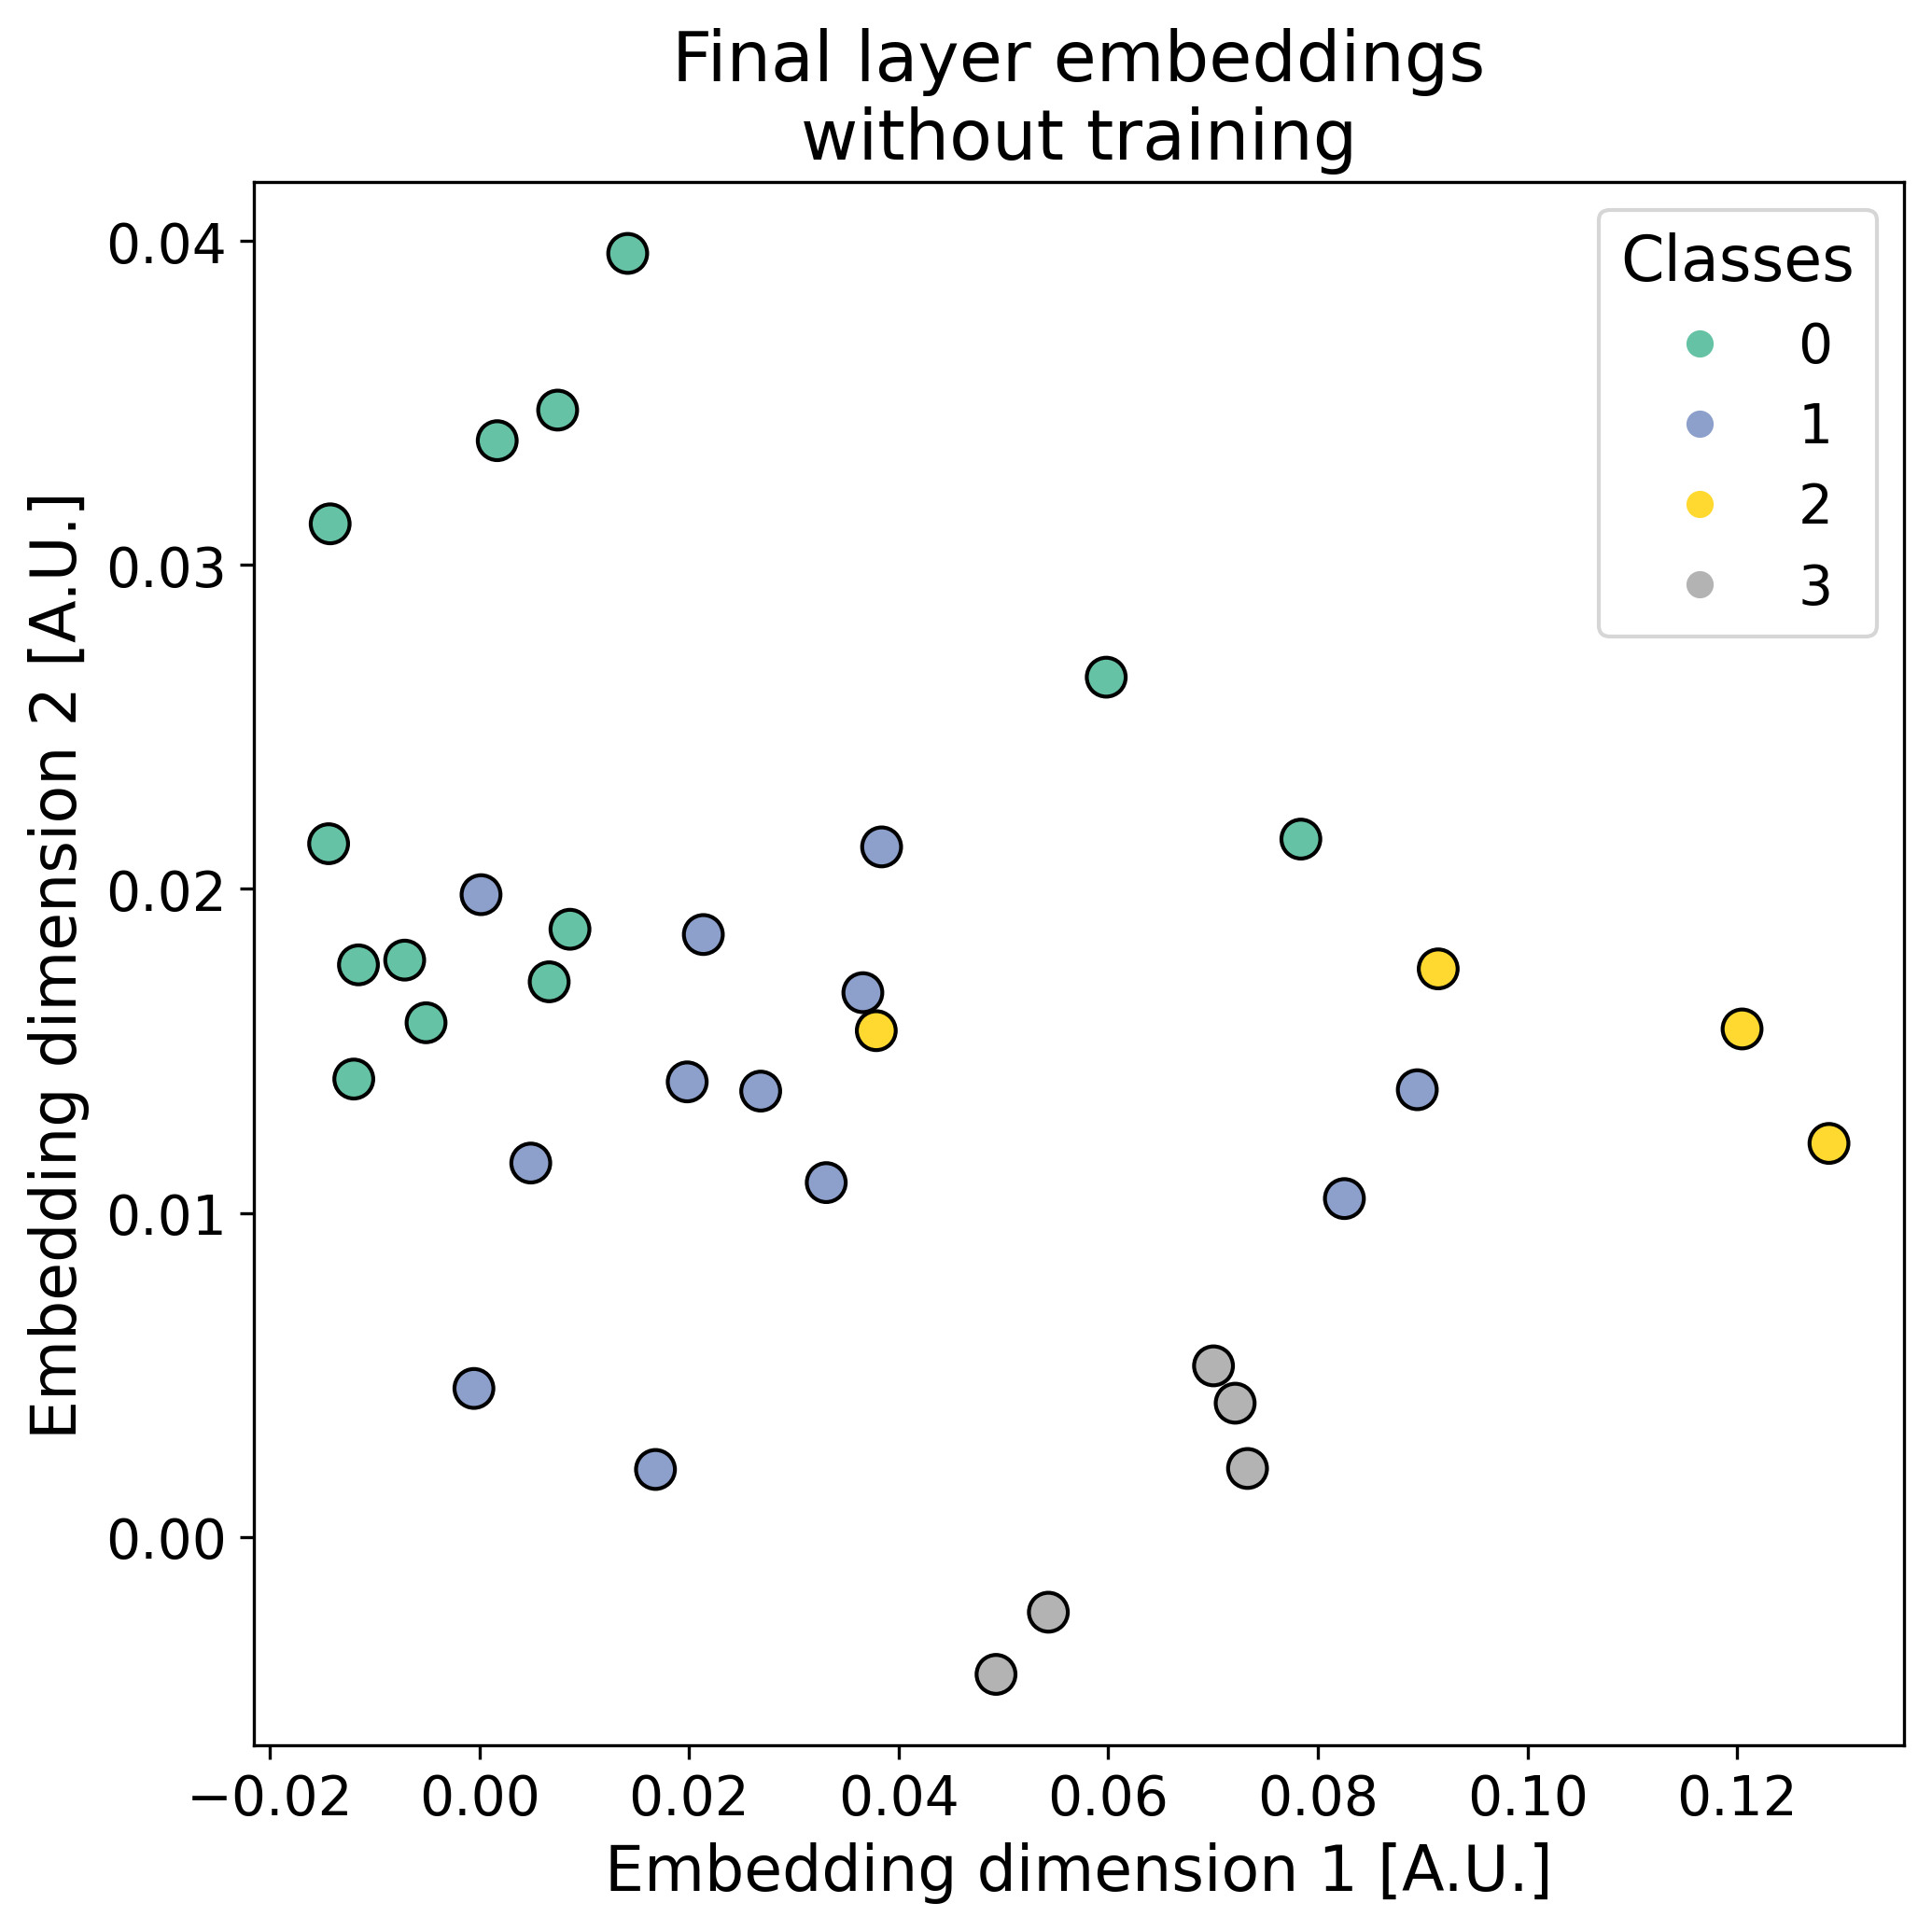

In [39]:
class GCN(nn.Module):
    def __init__(self, seed):
        super().__init__()
        torch.manual_seed(seed)
        self.conv1 = gnn.GCNConv(34, 4)
        self.conv2 = gnn.GCNConv(4, 4)
        self.conv3 = gnn.GCNConv(4, 2)
        self.lin = nn.Linear(2, 4)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = self.conv1(x, edge_index)
        h = F.elu(h)
        h = self.conv2(h, edge_index)
        h = F.elu(h)
        h = self.conv3(h, edge_index)
        h = F.elu(h)
        output = self.lin(h)
        return output, h
    
model = GCN(seed=1234)

output, embedding = model(data)

def plot_embedding(embedding, epoch_loss = None, ax = None, markersize = 100, legend = False):
    embedding = embedding.detach().cpu().numpy()
    if ax is None:
        fig = plt.figure(figsize=(7,7),dpi = 300)
        ax = fig.add_subplot(111)
    scatter = ax.scatter(embedding[:,0], embedding[:,1], s = markersize, c = data.y, cmap="Set2",edgecolor='black',lw=1)
    if epoch_loss is not None:
        ax.set_title(f"Epoch: {epoch_loss[0]}, Loss: {epoch_loss[1]:.4f}",fontsize = 18)
        # ax.set_xticks([])
        # ax.set_yticks([])
    else:
        ax.set_title('Final layer embeddings\nwithout training',fontsize = 18)
    ax.set_xlabel('Embedding dimension 1 [A.U.]',fontsize = 16)
    ax.set_ylabel('Embedding dimension 2 [A.U.]',fontsize = 16)
    ax.tick_params(axis = 'both',labelsize=14)
    if legend:
        ax.legend(*scatter.legend_elements(),loc='best',title='Classes',fontsize = 14,title_fontsize=16)
    ax.get_figure().tight_layout()


plot_embedding(embedding, legend = True)


We can see that while we don't immediately have something that looks like 4 distinct clusters, we can that nodes with the same label seem to have similar embedding coordinates, suggesting we can do a good job even with an untrained GNN to represent the graph in a lower dimensional space. We'll now try training this GNN and see how the prediction evolves as a function of time.

<div style="background-color: #0000">


**Note**: you can see we have used the `ELU` function to start with here, rather than `ReLU`; because the node features are just one-hot encodings of the node ID, we can very easily end up with the message from each node being 0 immediately, which means we become *very* dependent on our starting weights and in many cases our model can't learn at all as we end up with many dead neurons.  

Because the network we are working with here only has 4 nodes in the training set, we can completely skip the `DataLoader` and simply pass all of the training data to the network in each epoch, with no need for batching. In general with graphs we will need to use batches for graph-level tasks, or for when we have large networks with many nodes used for training. 

The code cell below shows how we can train and evaluate this model, including evaluating the loss for the training data and calculating the performance on the test data after training. We will also visualise the final layer embedding every 50 epochs of training, for 400 epochs. We will also record the loss both for the training dataset and the test dataset, so we can plot loss curves.

Total training time: 1.35 seconds


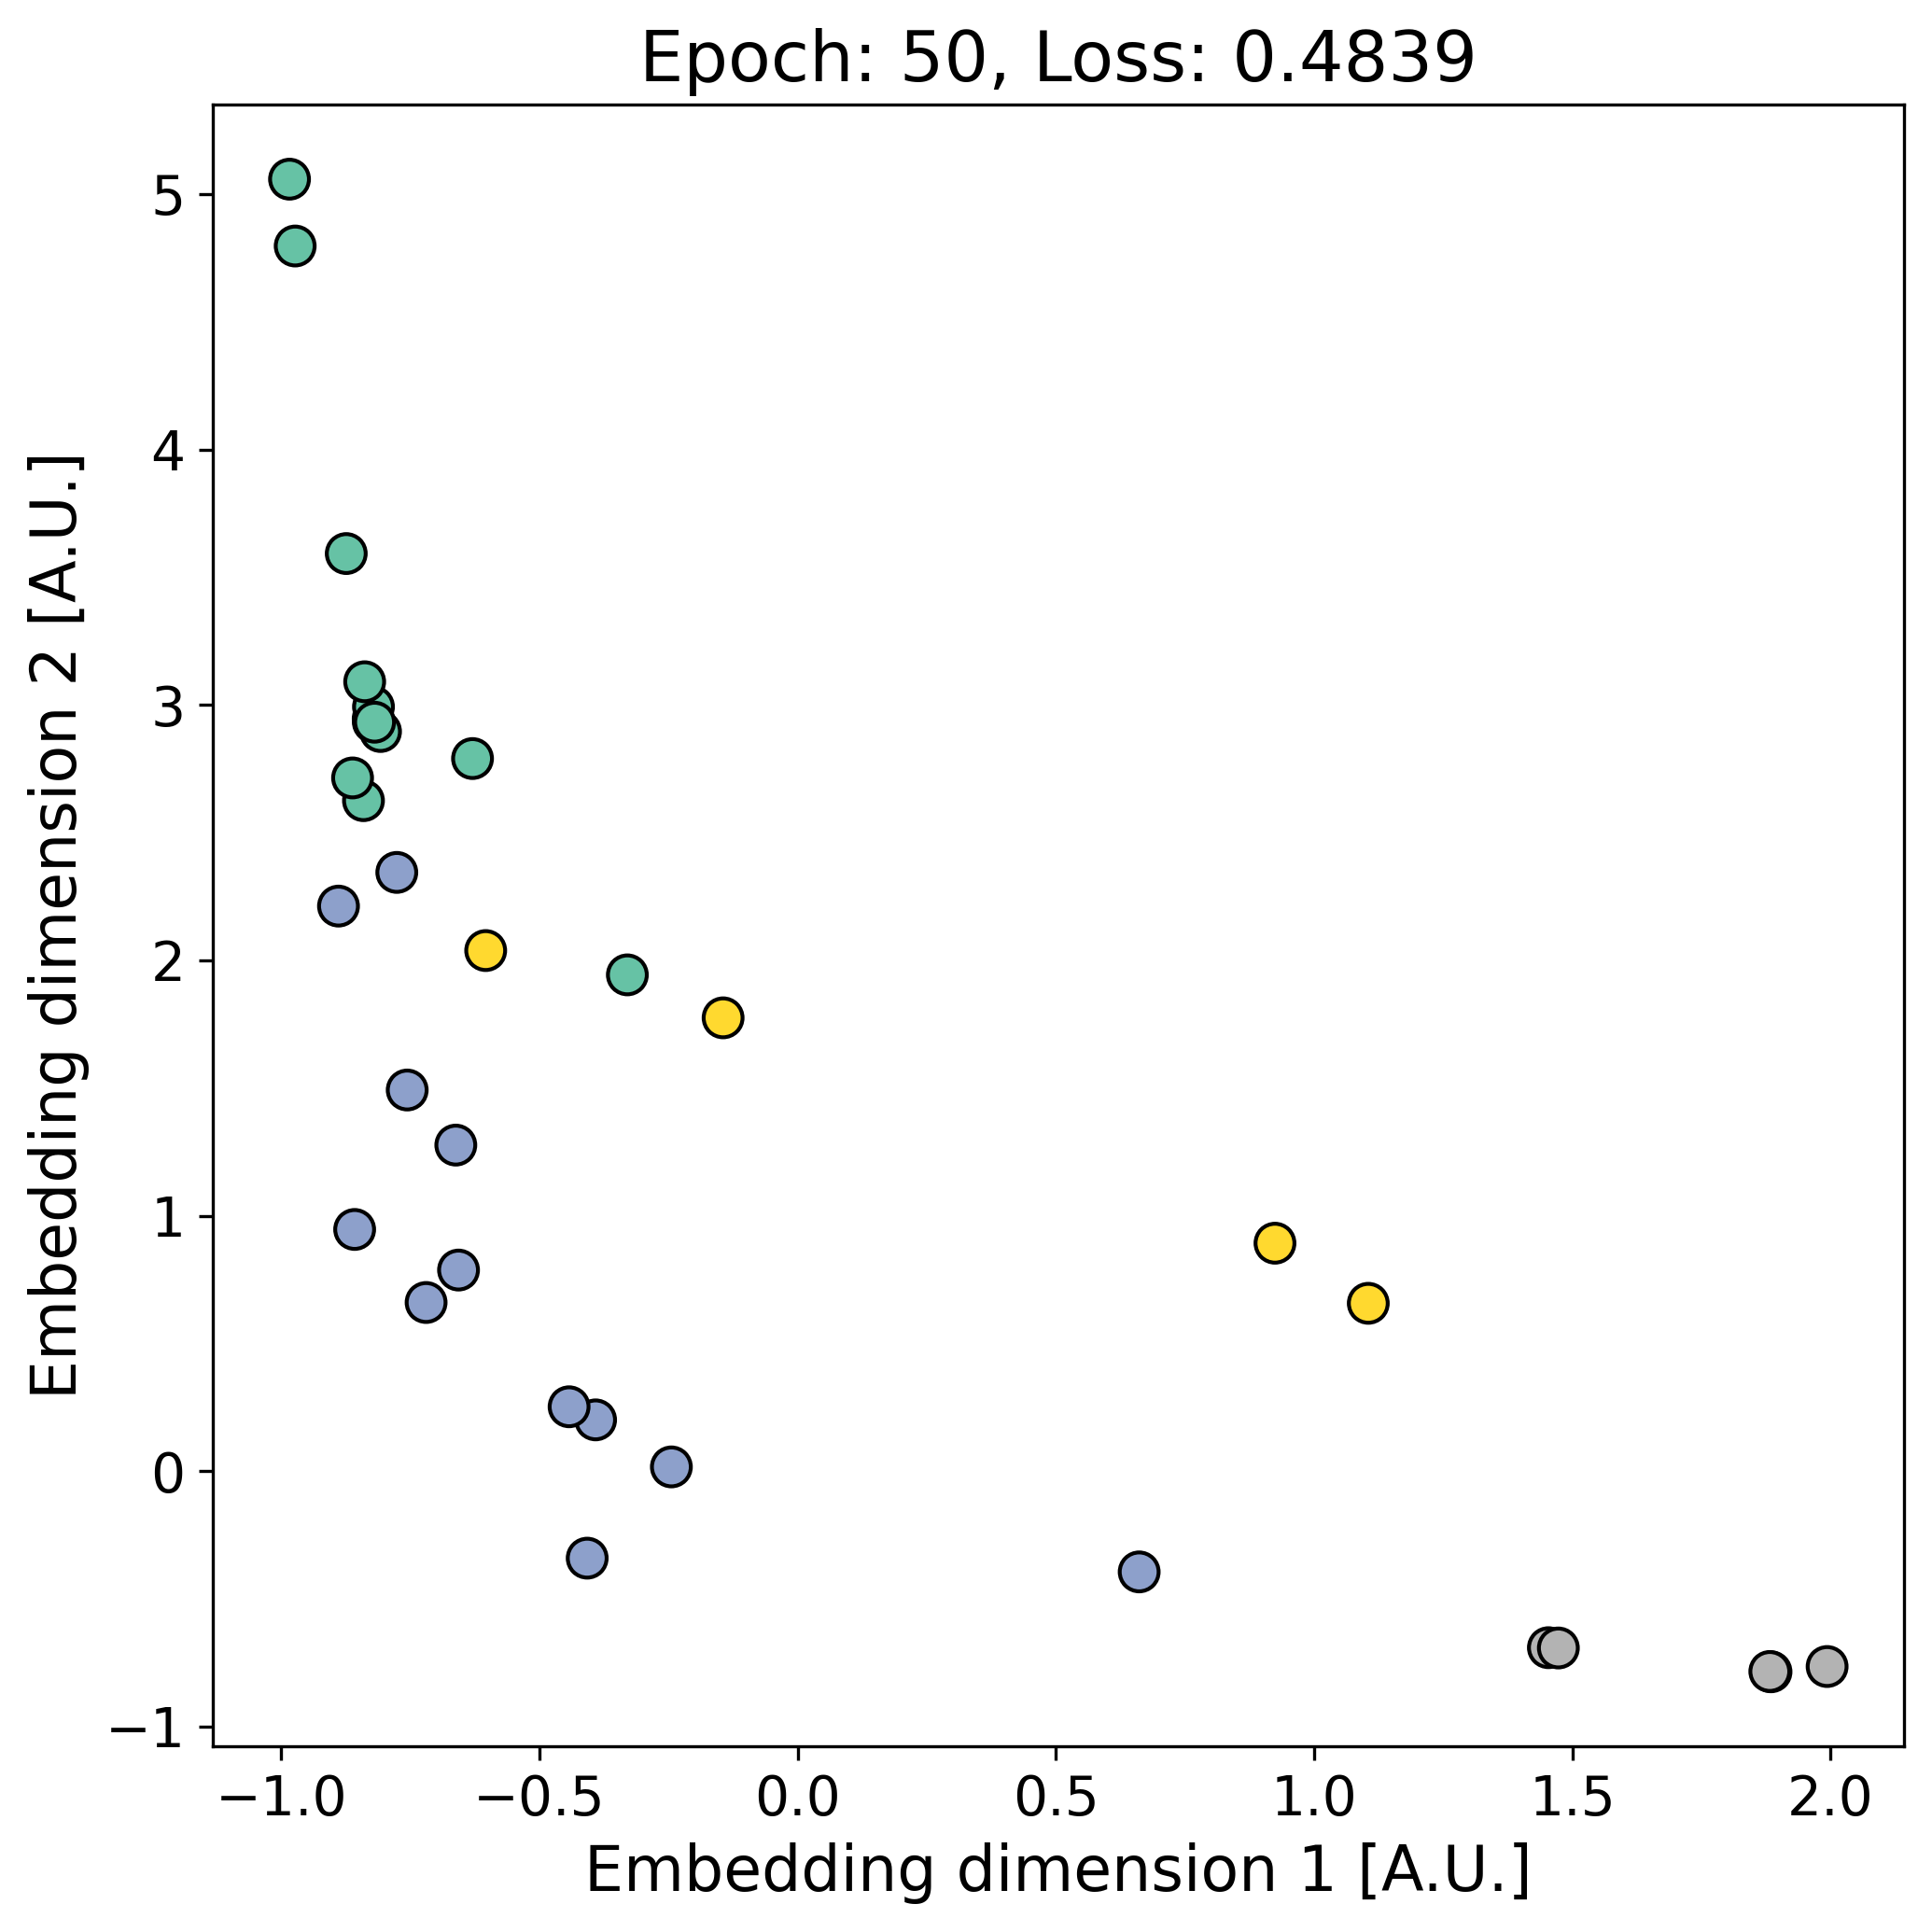

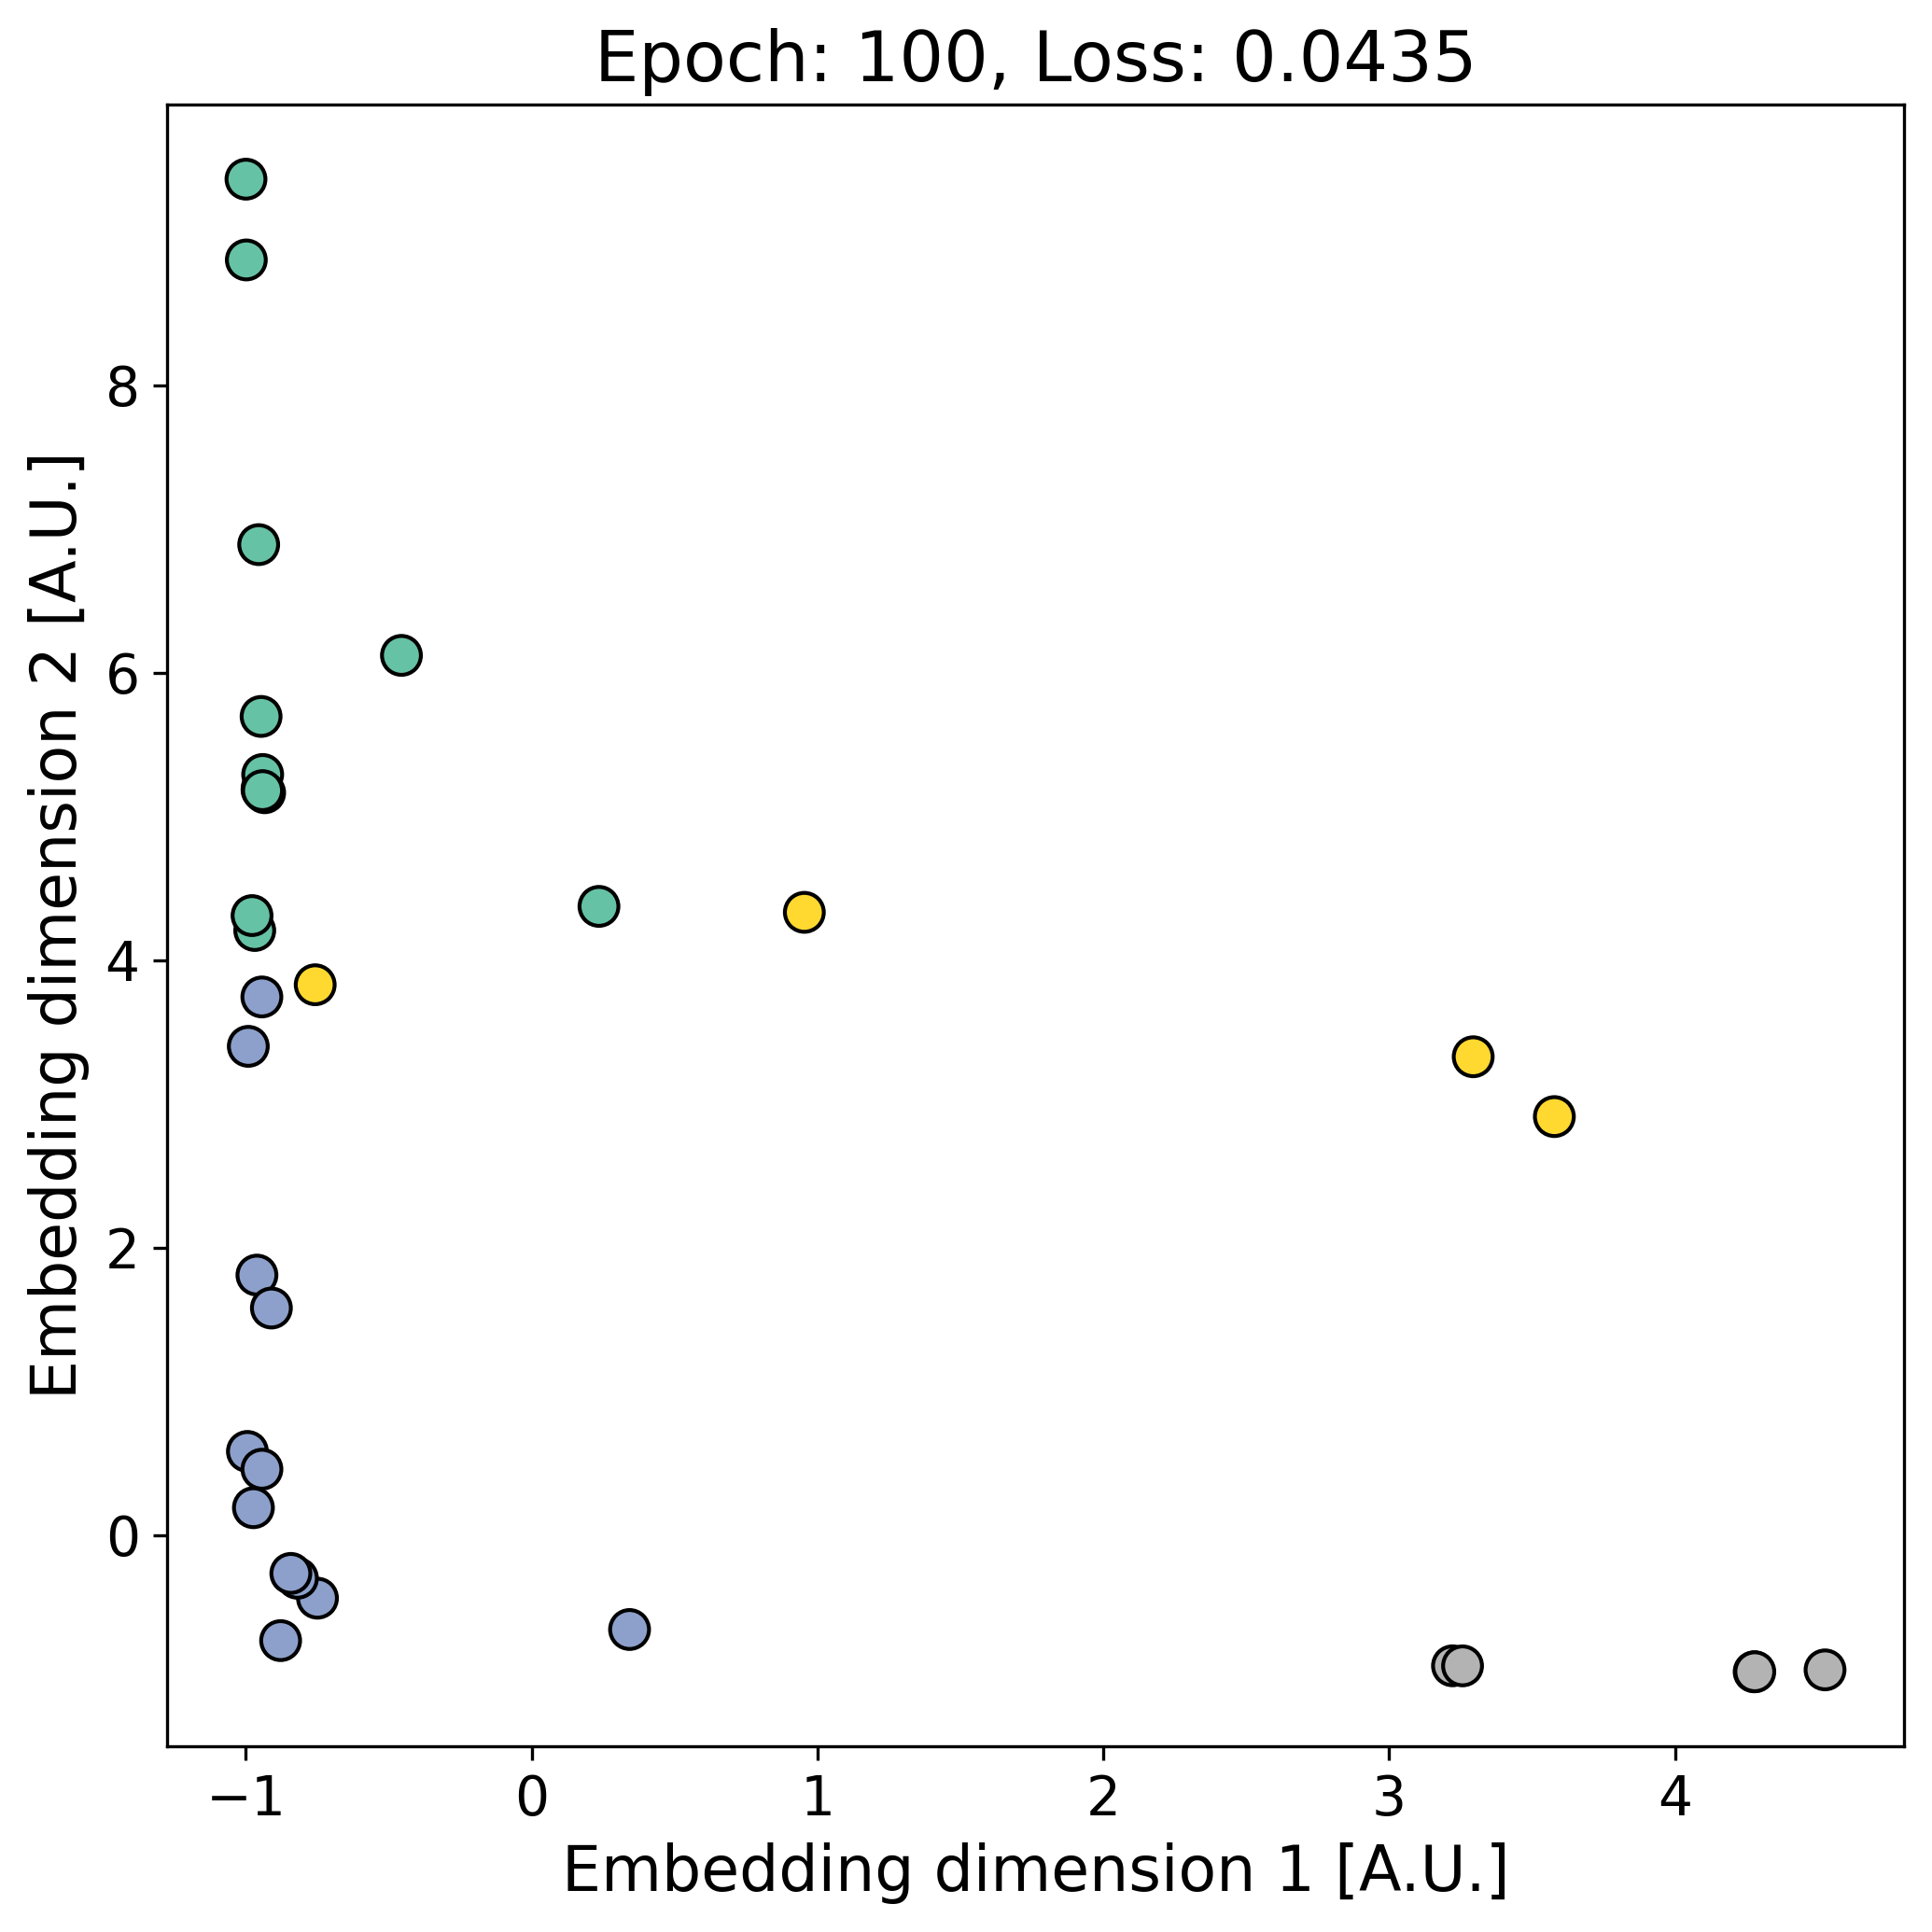

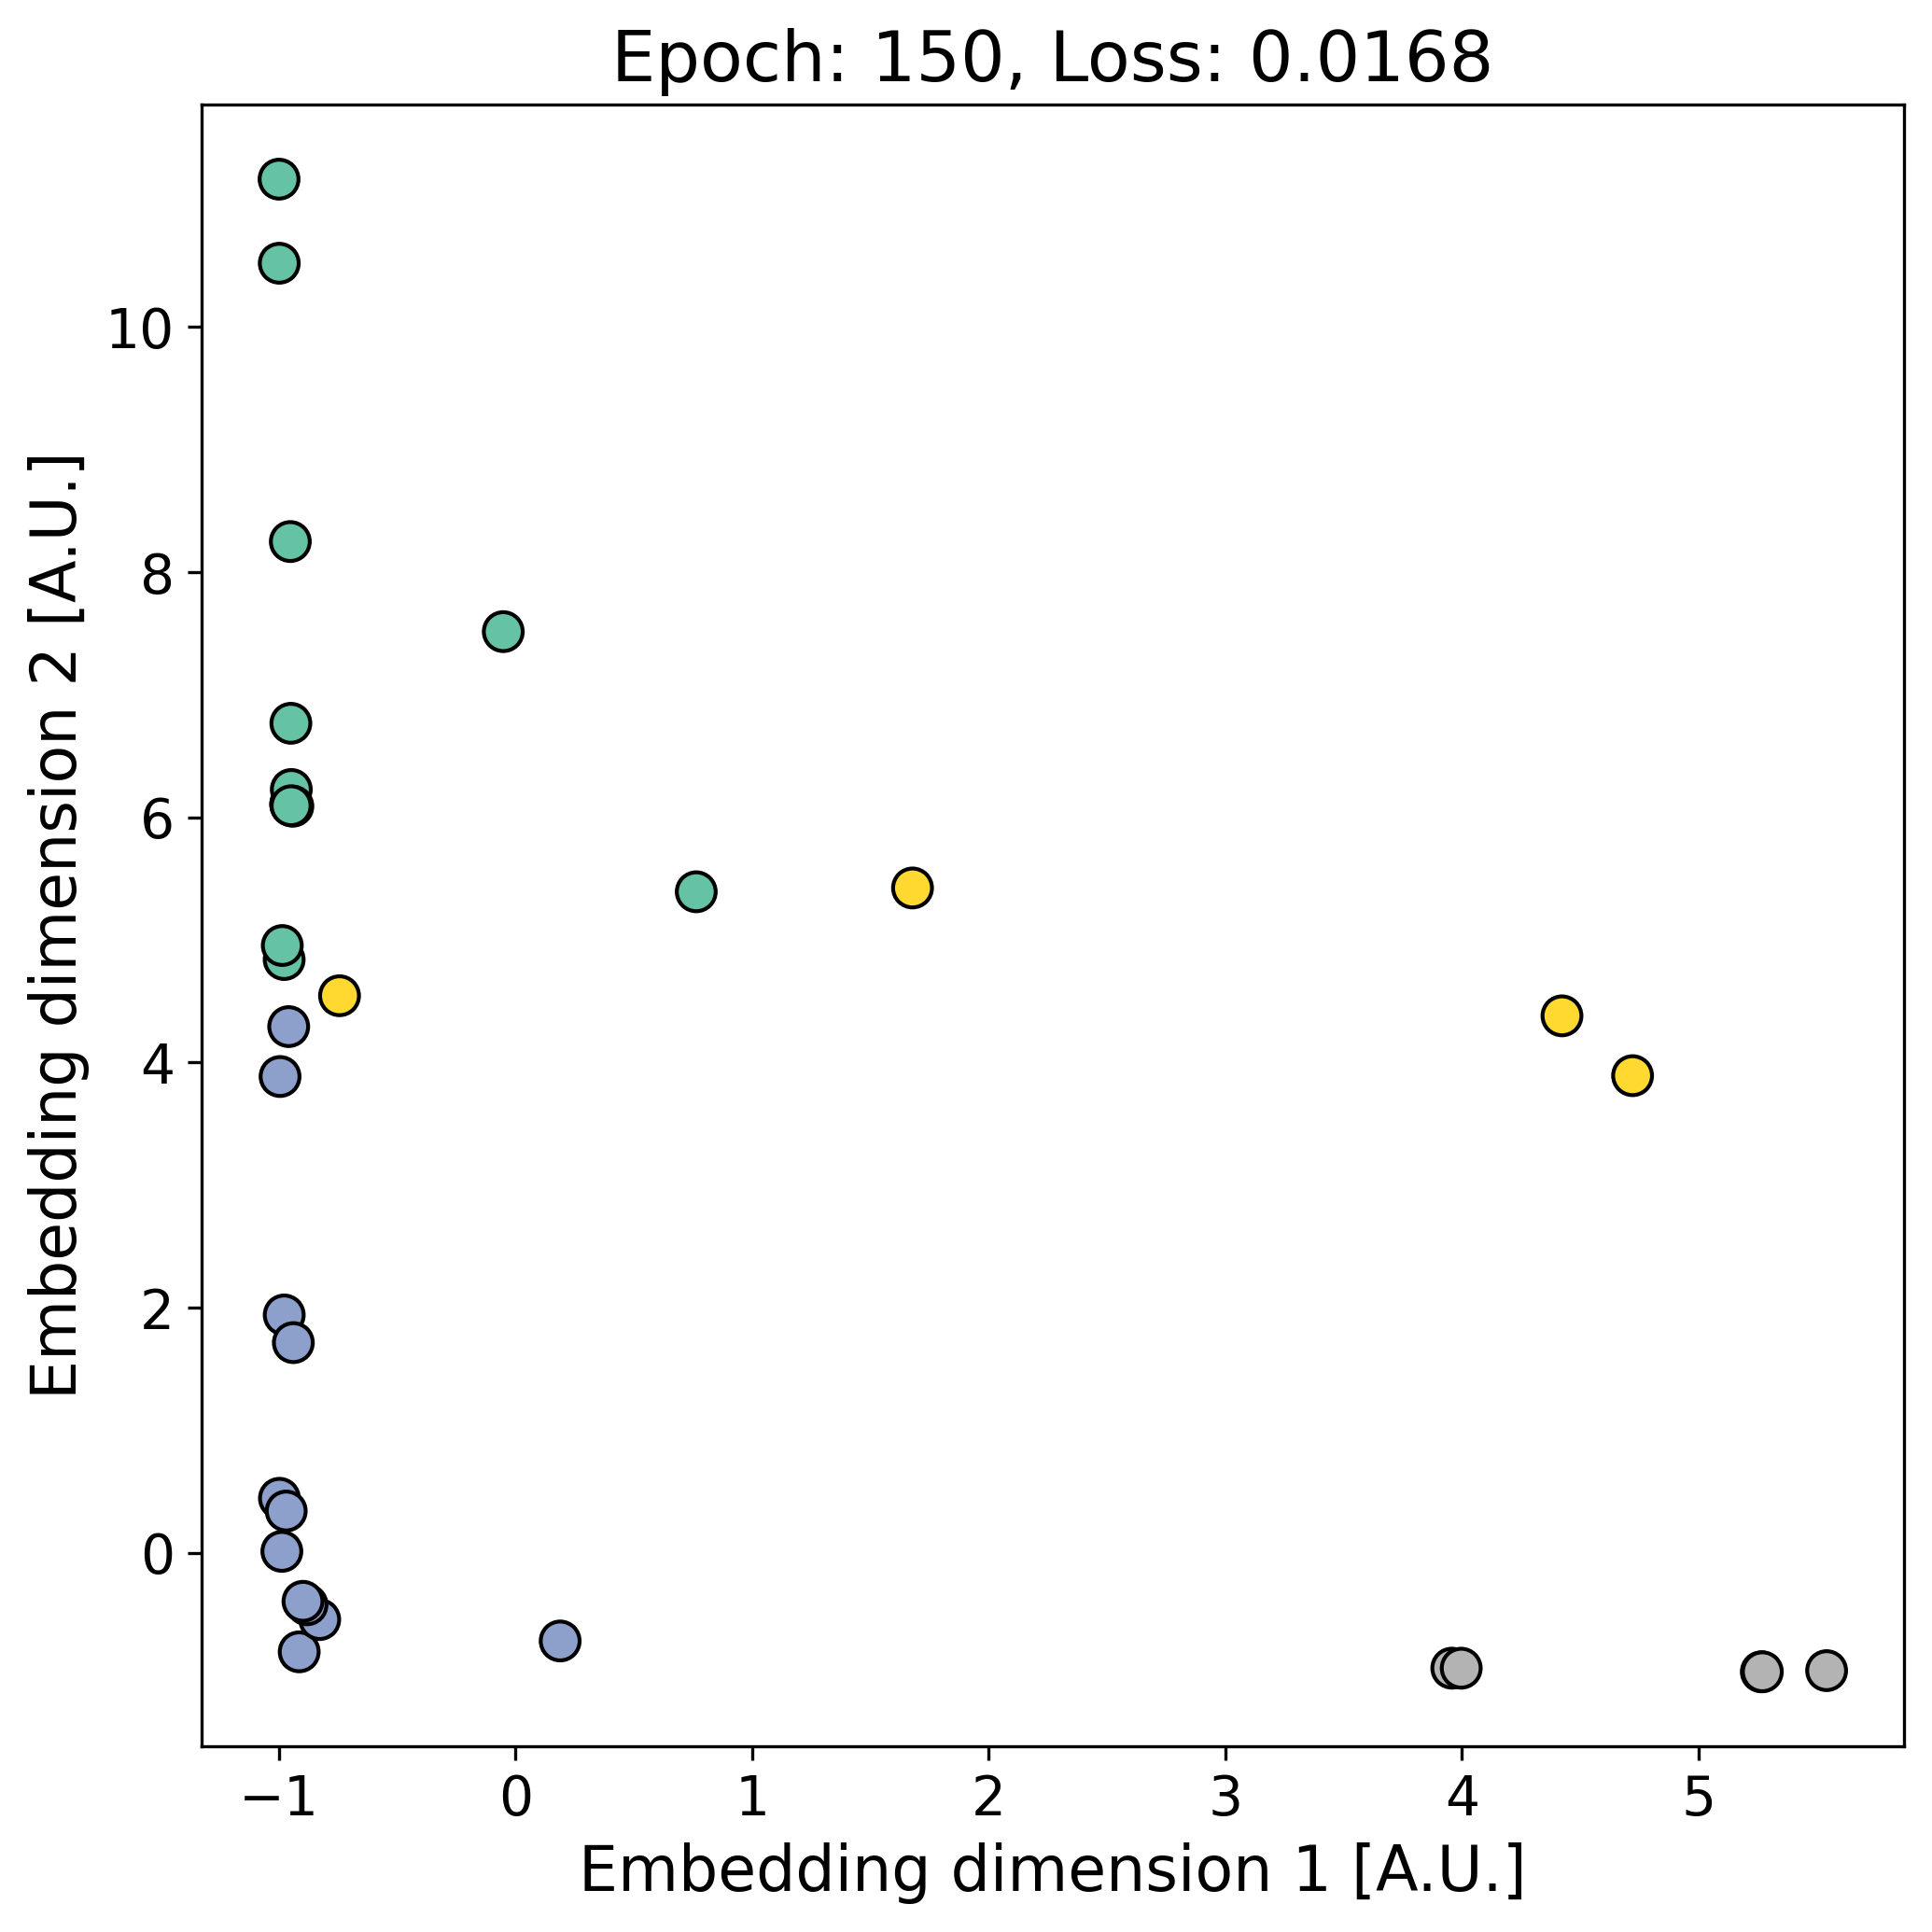

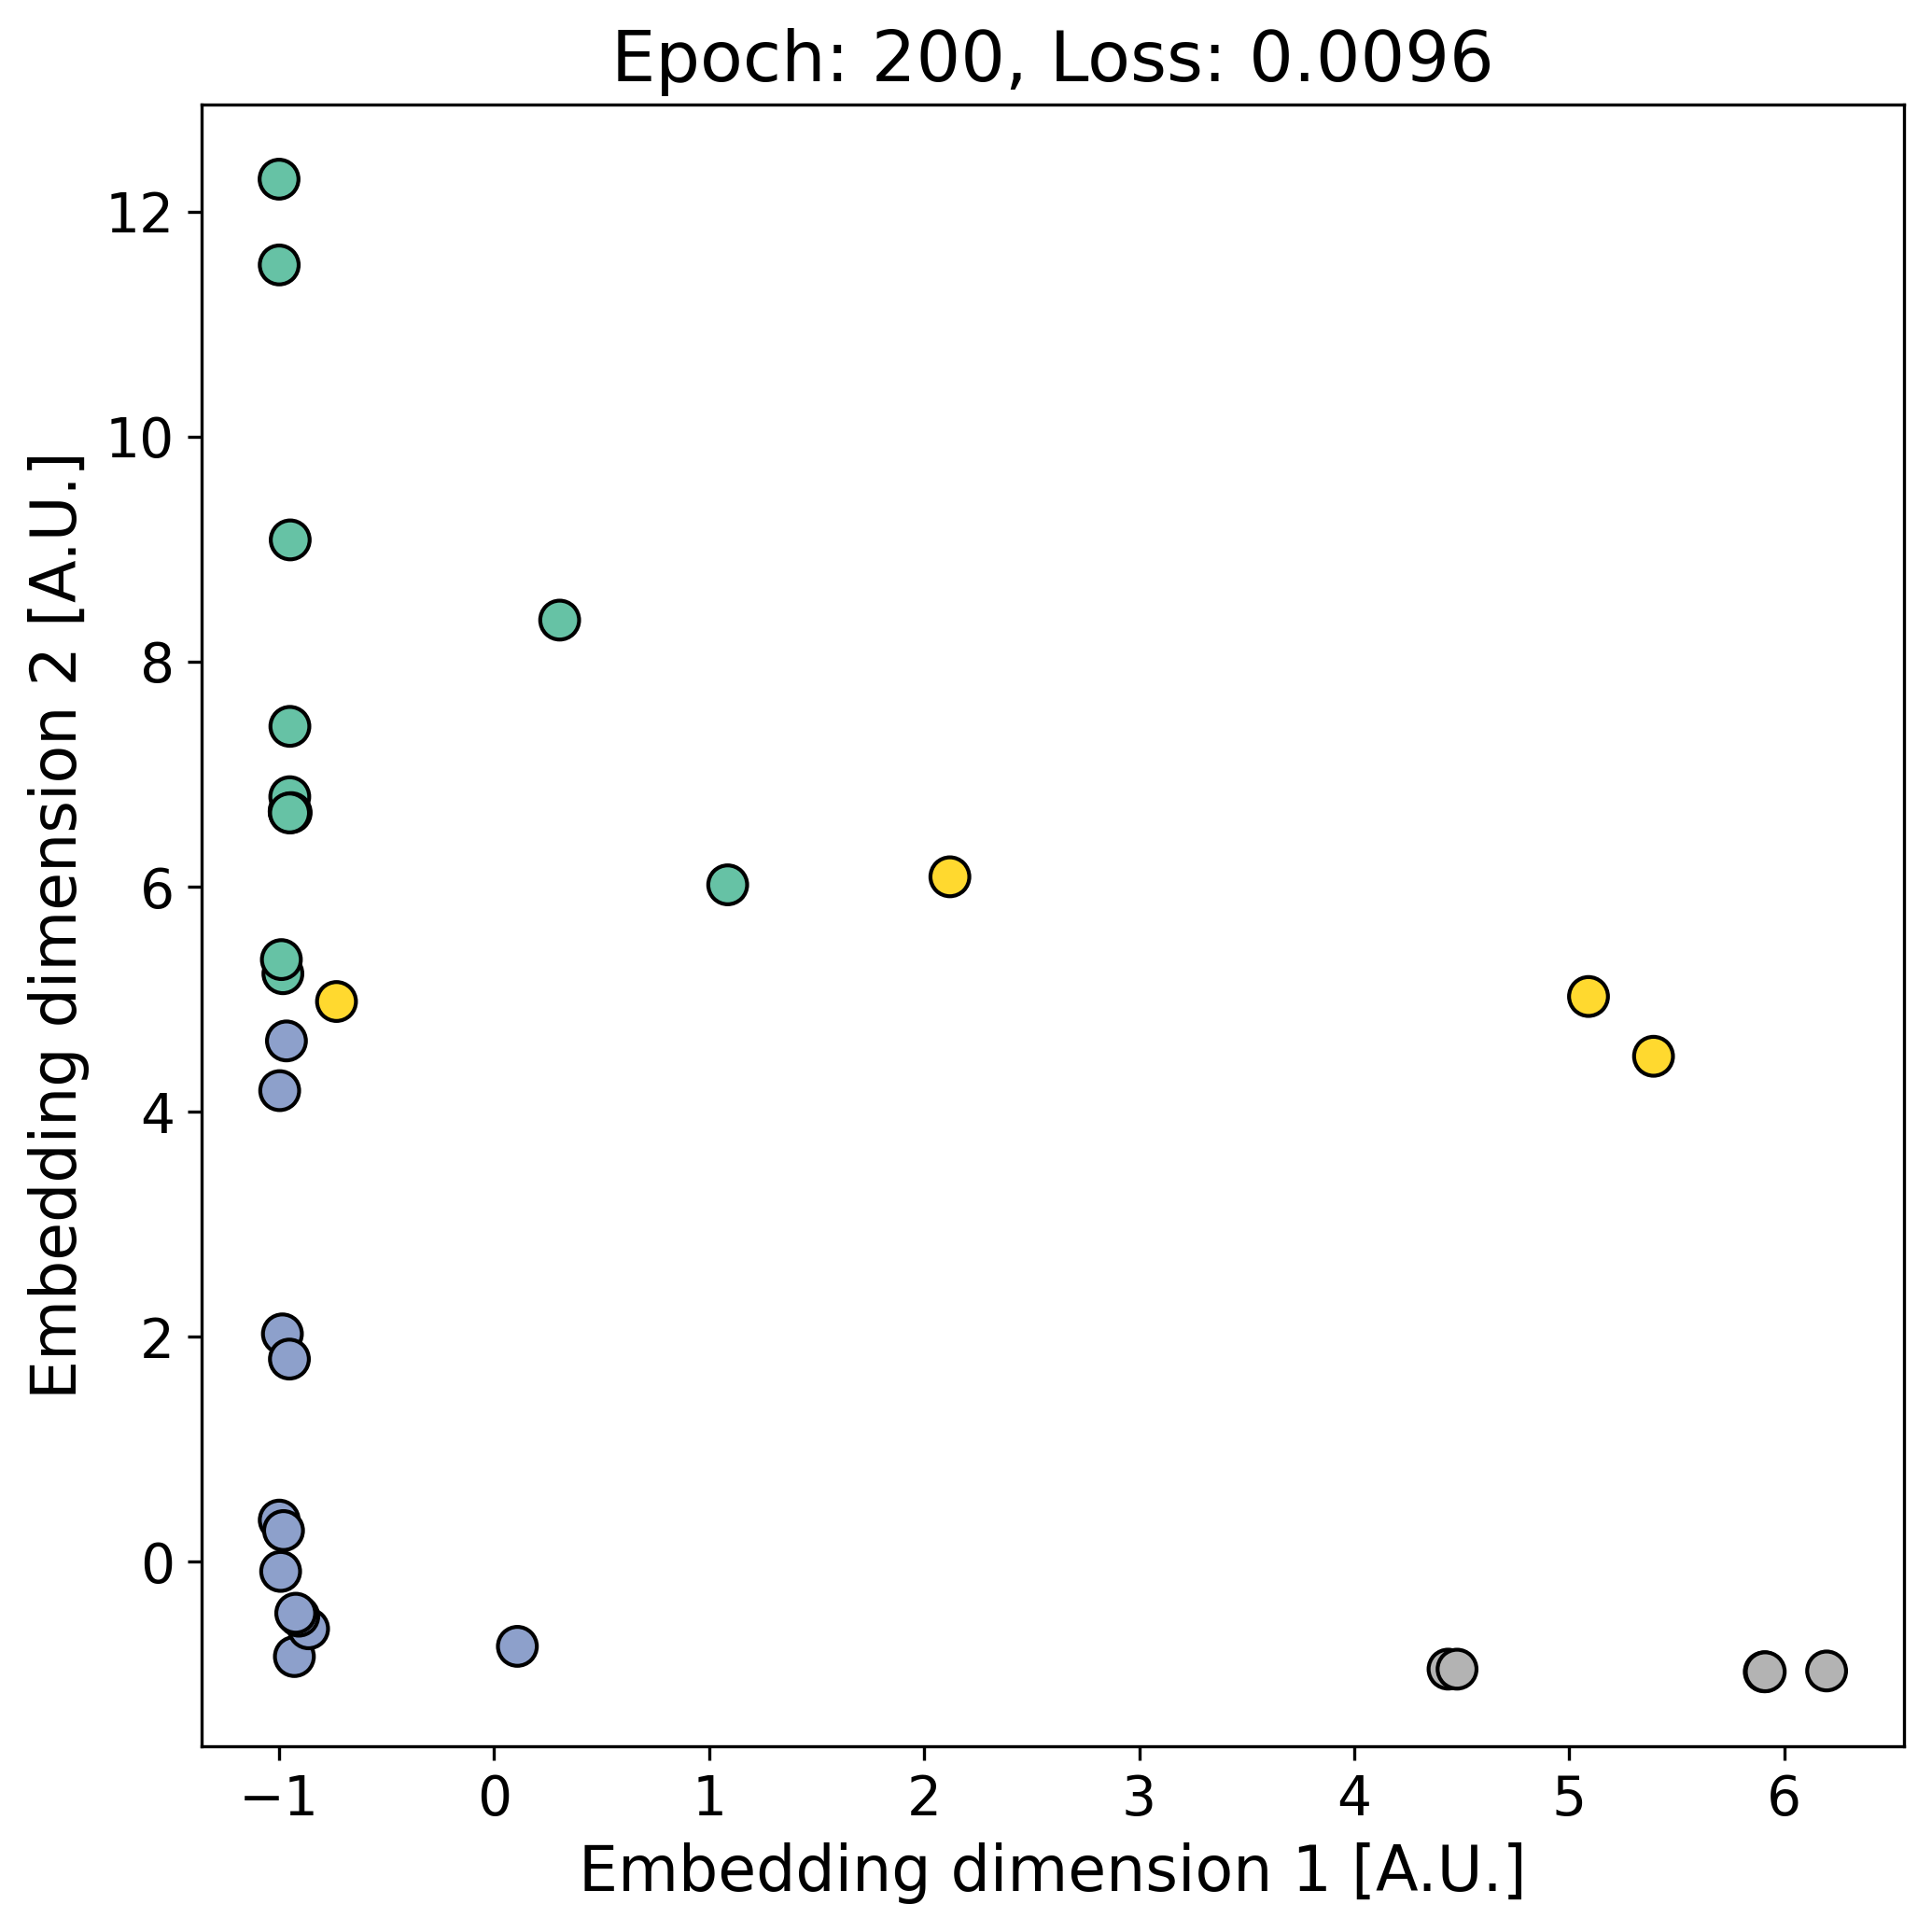

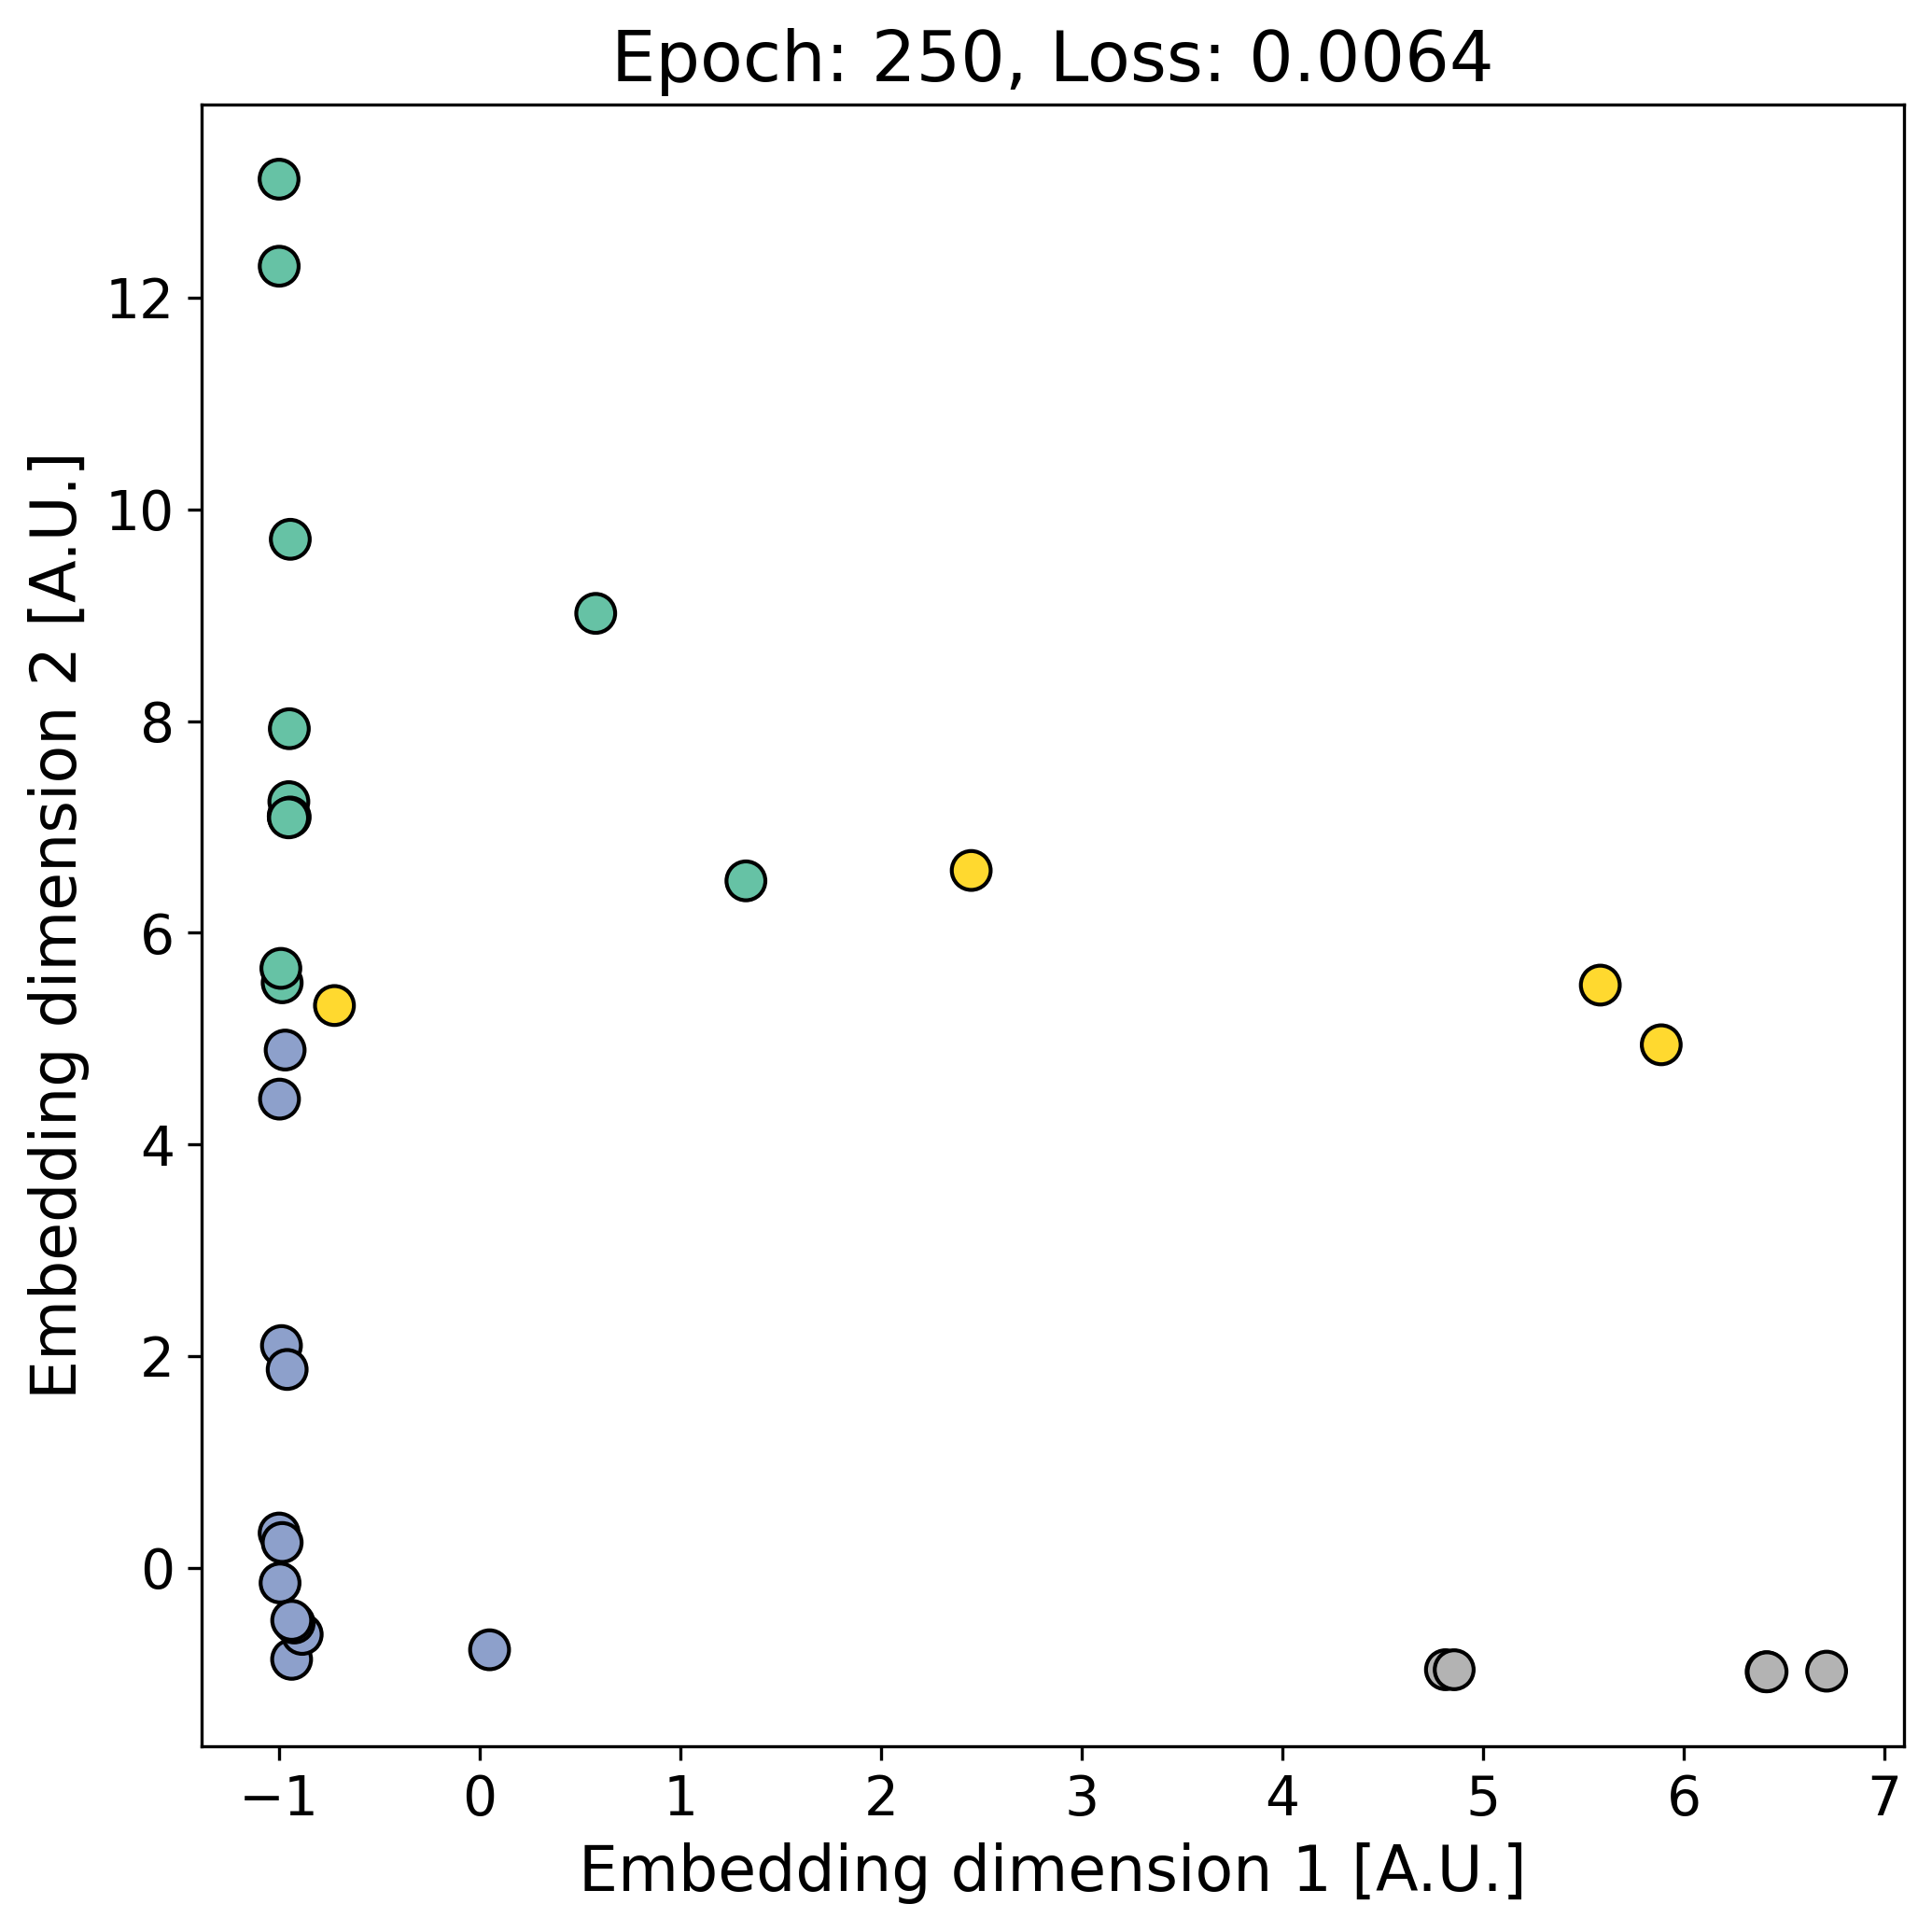

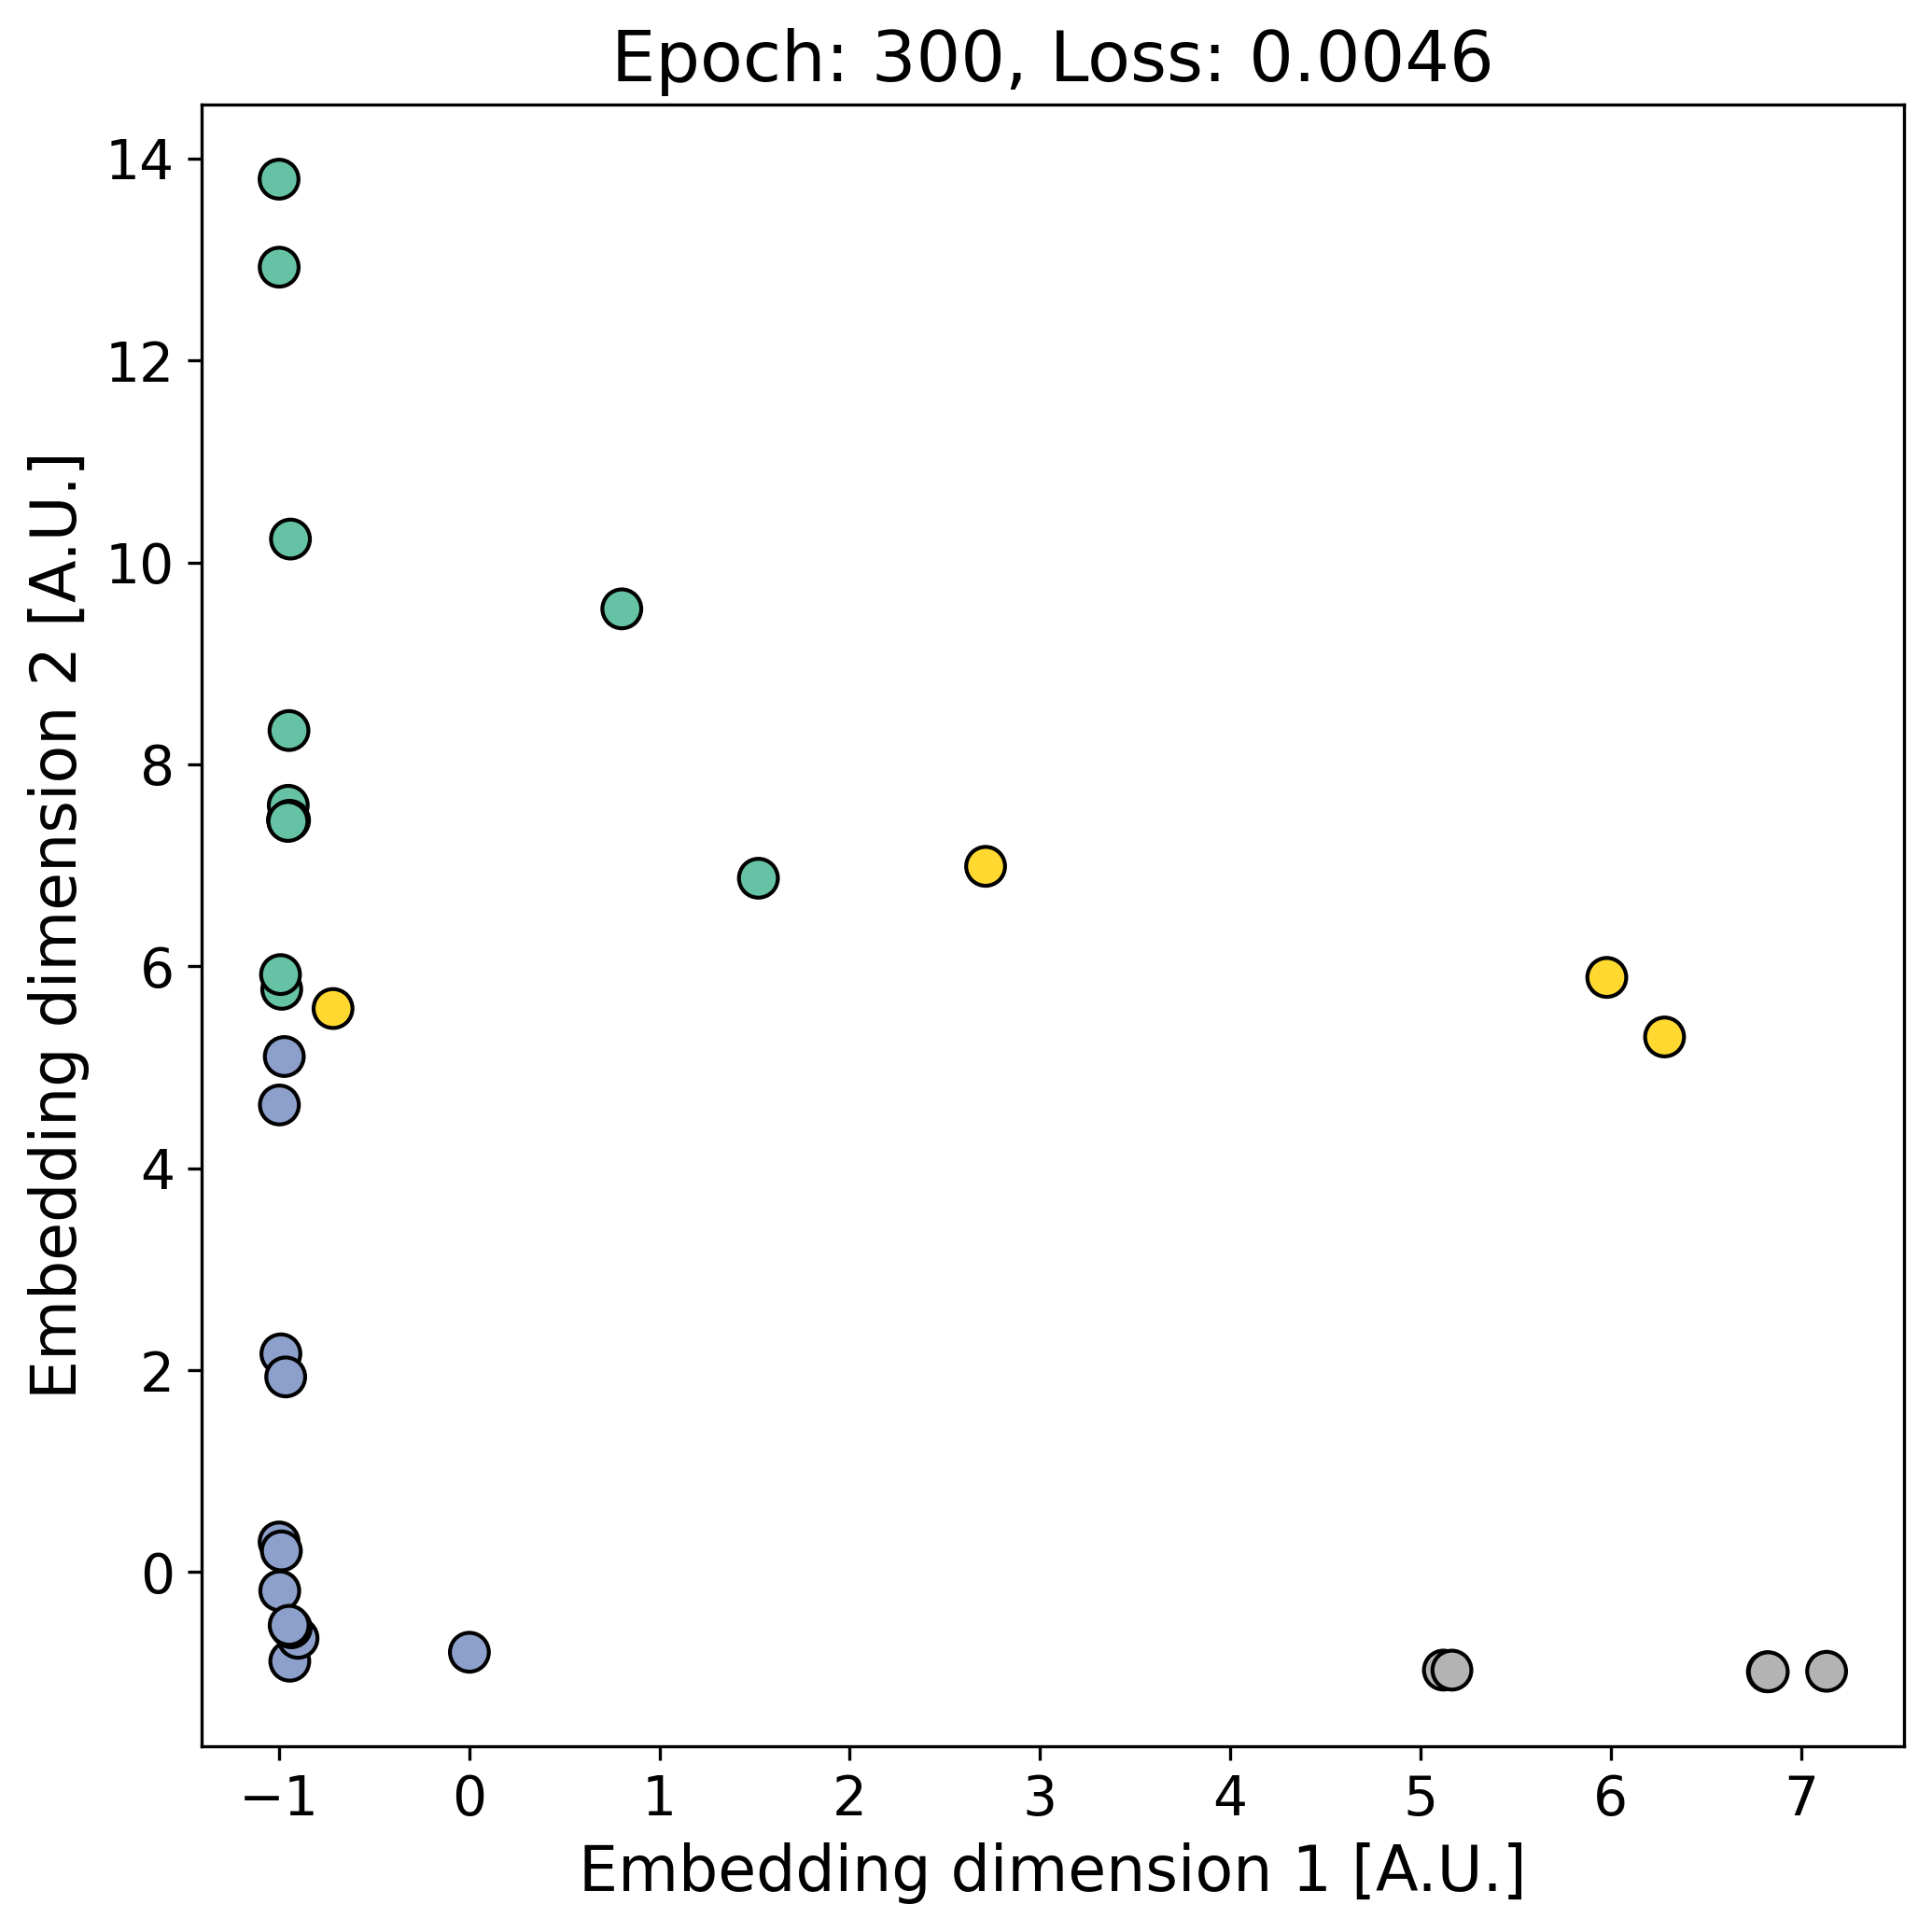

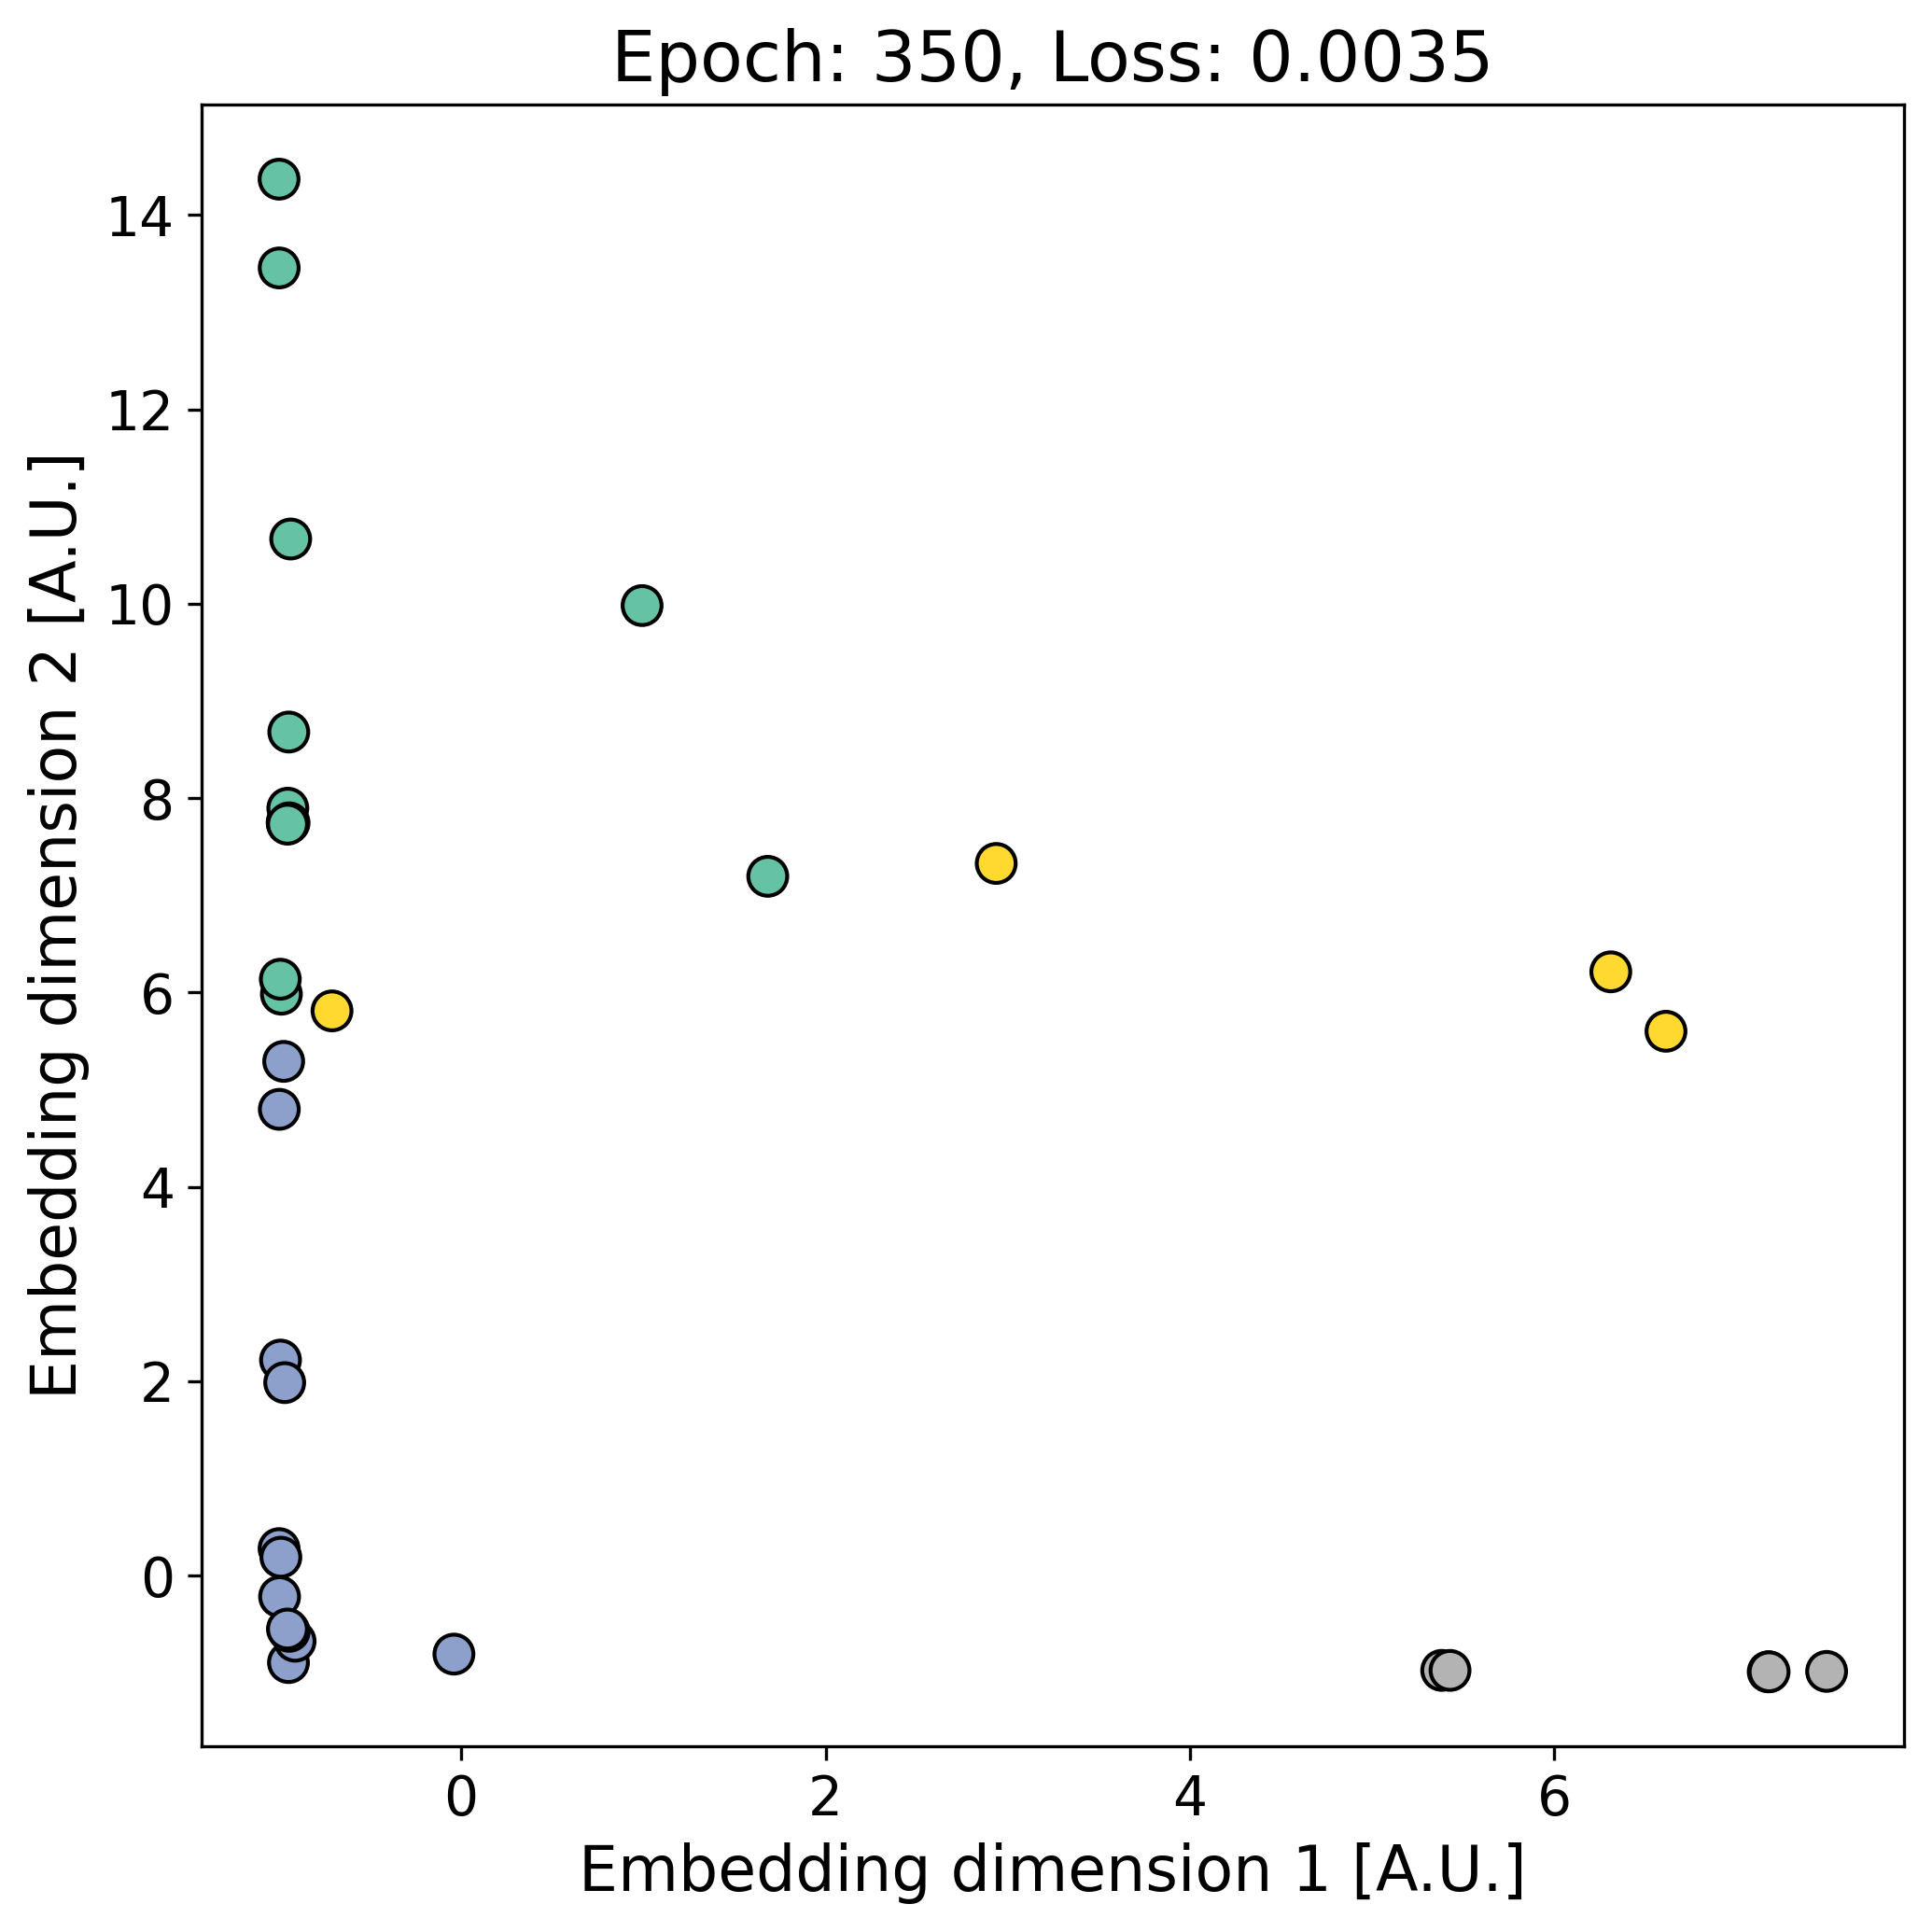

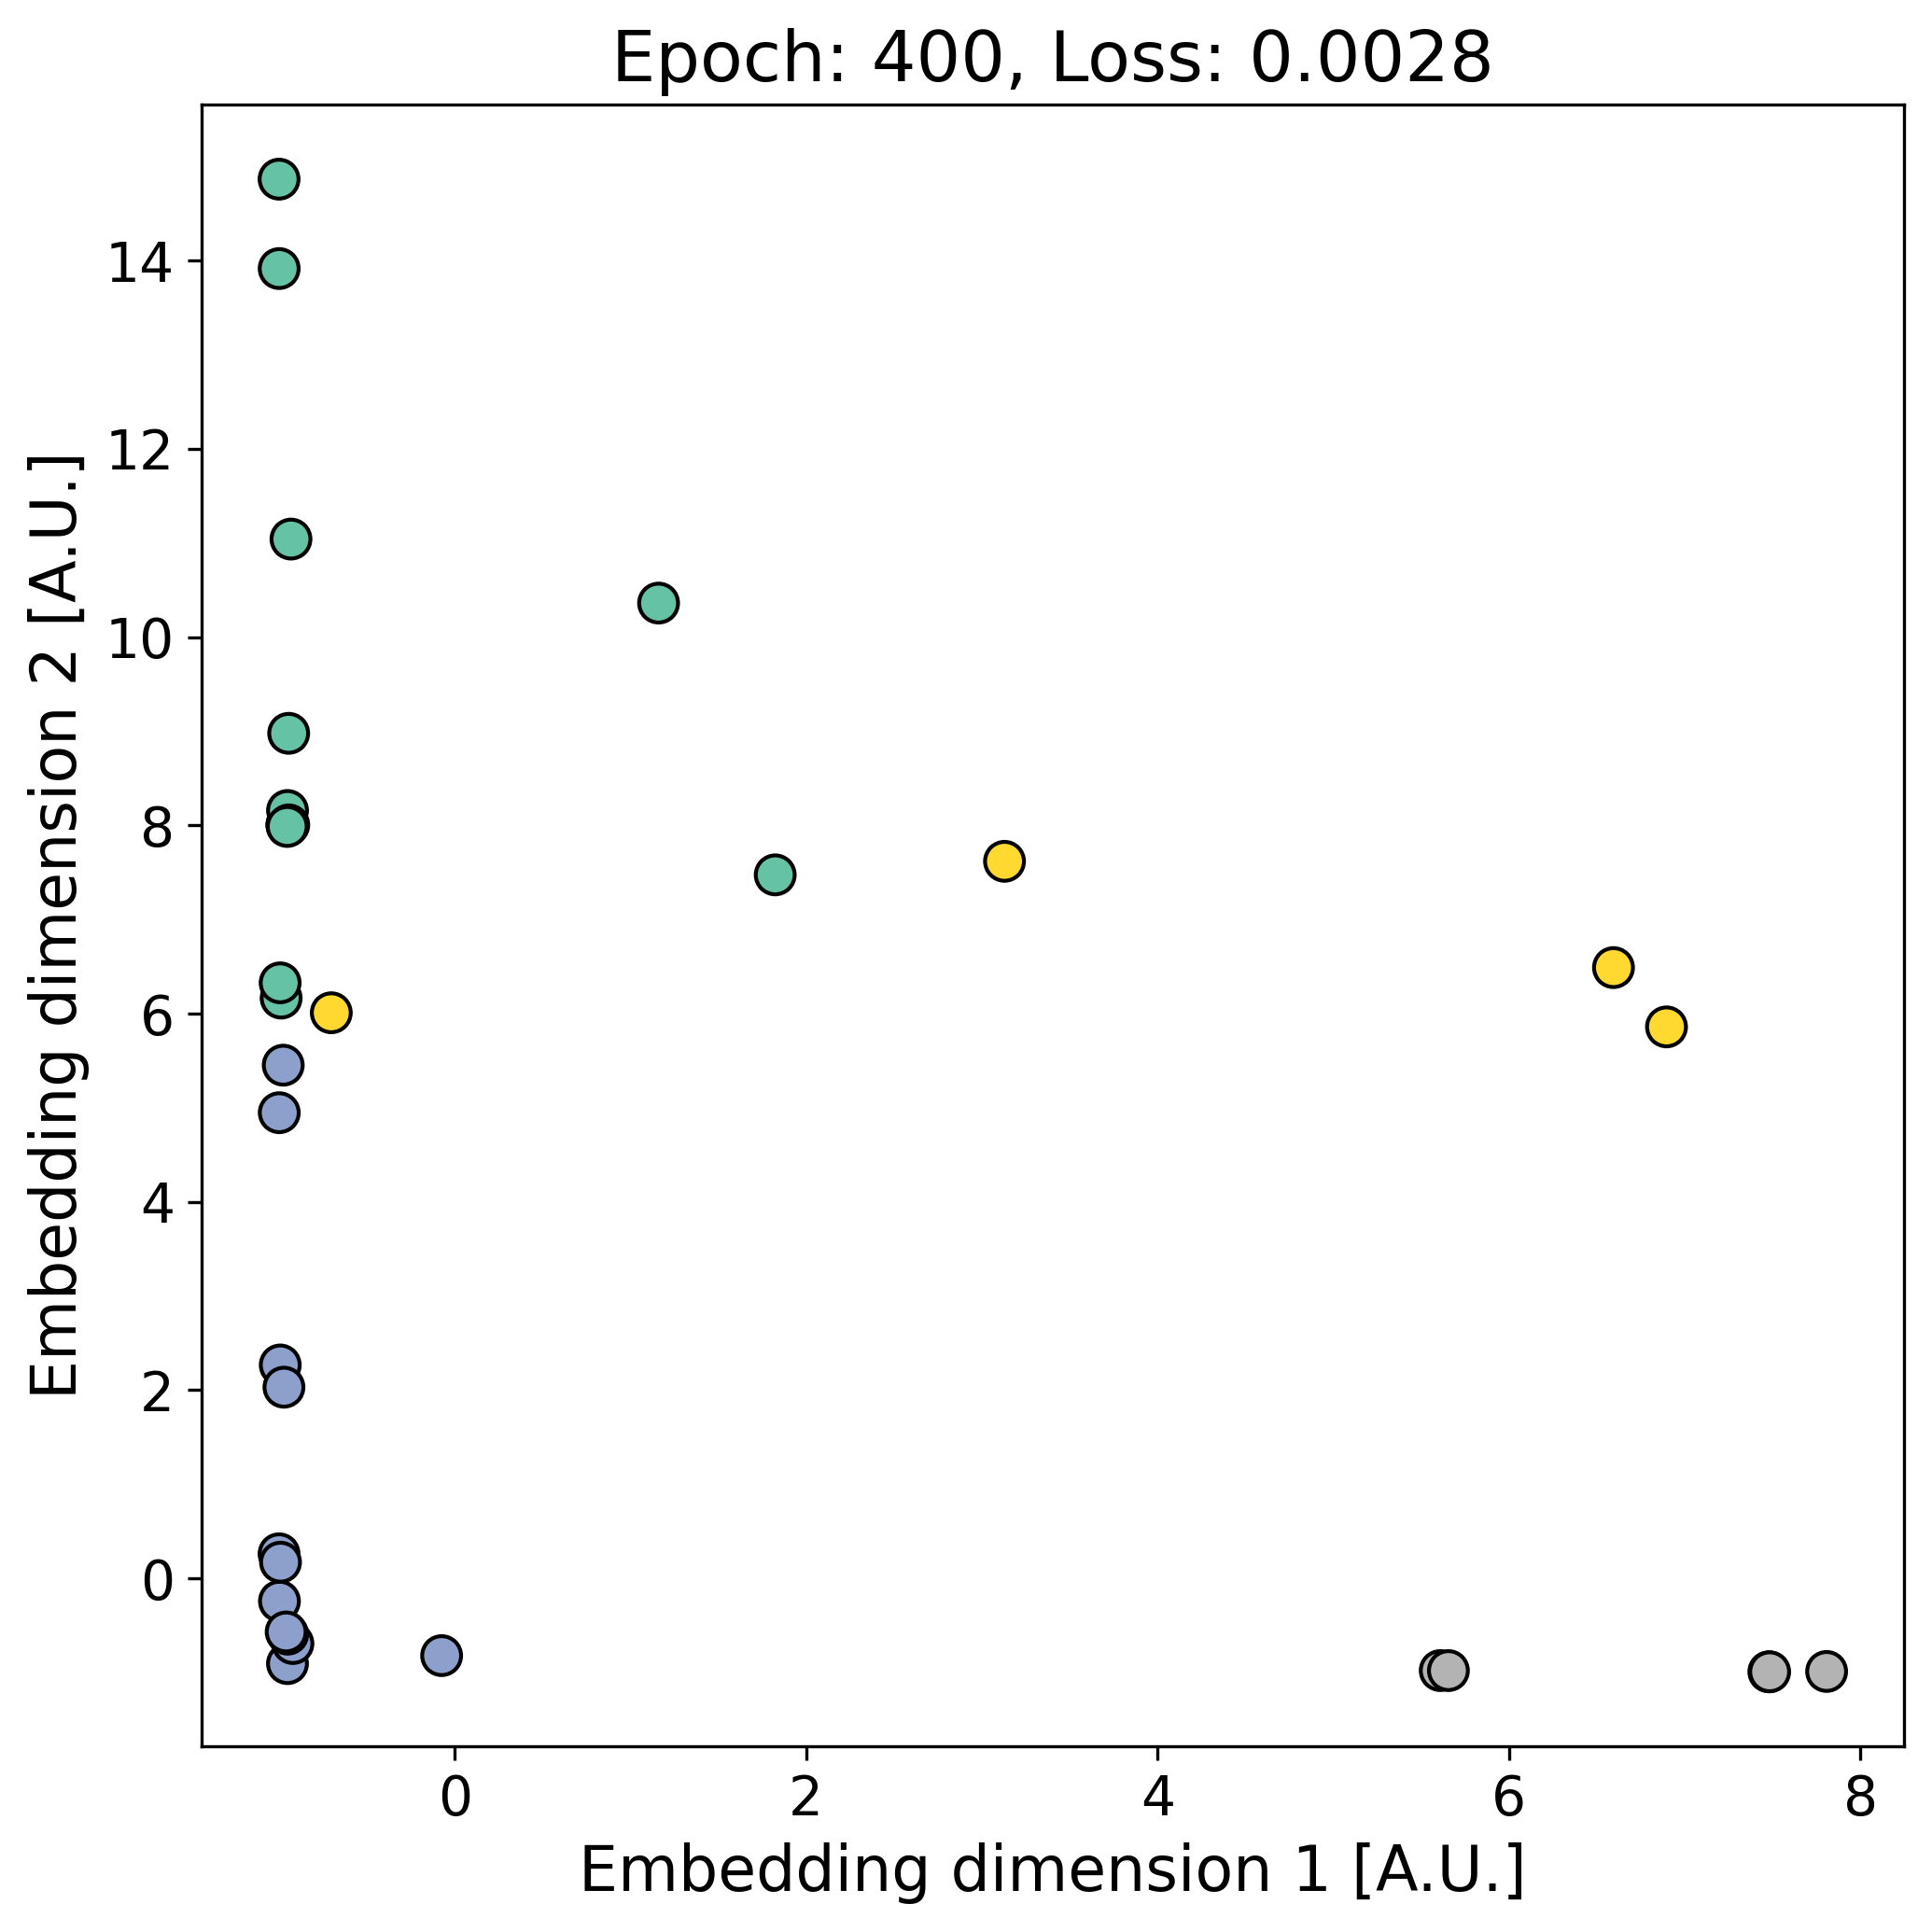

In [40]:
import torch.optim as optim
import time # Measure training time

n_epochs = 400

loss_fcn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

train_losses, test_losses = [], []
start_time = time.time()
for epoch in range(1,n_epochs+1):
    model.train()
    optimizer.zero_grad()
    out, h  = model(data)
    loss = loss_fcn(out[data.train_mask], data.y[data.train_mask]) # get training outputs & labels
    loss.backward()
    optimizer.step()
    if epoch%50 == 0:
        plot_embedding(h, (epoch, loss))
    train_losses.append(loss.item())
    vloss = loss_fcn(out[~data.train_mask],data.y[~data.train_mask])
    test_losses.append(vloss.item())
end_time = time.time()
print(f'Total training time: {end_time-start_time:.2f} seconds')

By the end of the training, we've done a pretty reasonable job of producing linearly-separable clusters per label in the embedding space. Let us check the loss curves:

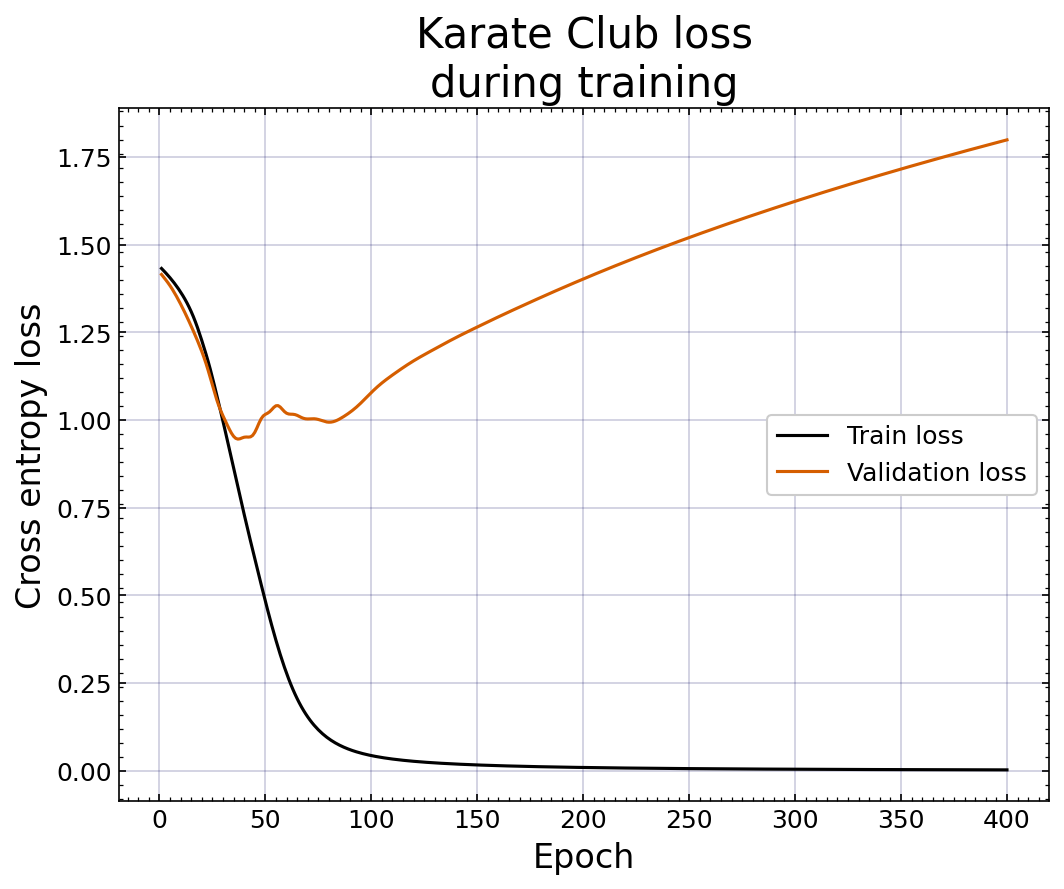

In [41]:
# Evaluate test performance

# Plot loss
import numpy as np
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(8,6),dpi = 150)
ax = fig.add_subplot(111)
ax.plot(np.arange(1,n_epochs+1),train_losses,label='Train loss',color='black')
ax.plot(np.arange(1,n_epochs+1),test_losses,label='Validation loss',color='#D55E00')
ax.set_xlabel('Epoch',fontsize = 16)
ax.set_ylabel('Cross entropy loss',fontsize = 16)
ax.set_title('Karate Club loss\nduring training',fontsize = 20)
ax.tick_params(labelsize=12, which='both', top = True, right = True, direction='in')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(0.04))
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.legend(loc='center right',fontsize = 12,framealpha = 1)

We can clearly see we are overfitting here - this is hardly surprising, given we only have 4 training samples, but certainly something we would need to be careful of in general. 

Now we can check the final classification accuracy; we will assume the largest output neuron corresponds to the class we should select for a given node.

In [42]:
from sklearn.metrics import accuracy_score

out, h = model(data)

preds = out.max(dim = 1)[1].numpy() # Get predicted class for all of the nodes
true = data.y.detach().cpu().numpy()

accuracy_test = accuracy_score(true[~data.train_mask], preds[~data.train_mask]) # calculate accuracy for test set nodes
print(f"Classification accuracy across the test nodes: {accuracy_test:.1%}")

accuracy = accuracy_score(true, preds) # calculate accuracy across the whole graph
print(f"Classification accuracy across the whole graph: {accuracy:.1%}")



Classification accuracy across the test nodes: 80.0%
Classification accuracy across the whole graph: 82.4%


We can see that even using only 4 of the nodes in our training set, we can achieve a 80.0% accuracy across the test set and 82.4% across the whole graph; clearly, we have learned a lot from just the structure of the graph and these four nodes. 

Please note that in our training code, although we only compute the loss based on the nodes in the training set, we do still pass the whole graph through the network so while we don't learn the labels of the test nodes, their presence in the graph still contributes to the learning of our training nodes. 

In other words, we have performed **transductive learning** here. If we wanted to train in an **inductive** fashion, we might first randomly select nodes to split the graph into two subgraphs, set one as the training subgraph and one as the test, then solely train on the training subgraph and evaluate on the test subgraph.

We have done some simple GNN setups here; we will do some more complicated things in the exercises, but there is also a series of Colab Notebooks with some other tutorials in the documentation [here]((https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html)), and the PyTorch Geometric Git repository has a series of other examples available [here](https://github.com/pyg-team/pytorch_geometric/tree/master/examples).

<div style="background-color:#0000">

### Example

Now we will try to improve our performance for this task, by varying the hyperparameters of our GNN. To do this, we will use two different architectures. The steps are as follows:

* Define two different GCN models: make sure both of them have 34 input features, 2 embedding features in the final embedding space, and 4 output values for multiclass classification. Make sure to use the same seed for both models.

    1. Increasing the size of the embedding layers: first hidden layer with 16 output features and second hidden layer with 16 output features

    1. Add an additional `GCNConv` layer: use the same set of hidden sizes, but add an additional layer with 4 input features and 4 output features. The final GNN layer should still have 2 inputs and 4 outputs

* Write a function to train a model for a single epoch, where it takes the model and optimizer as inputs to the function

* Train each model for 400 epochs, using `CrossEntropyLoss` and the `Adam` optimizer

* For each trained model, plot:
    * The training and validation loss as a function of epoch

    * The final layer embeddings

* Also calculate the validation node classification accuracy for each model

Use the same activation function for both models; you can use `ELU`, as we have used above, or you could choose another activation function you have learned about on this course.

In [44]:
# Your model definitions

# Model 1: Increasing the size of the embedding layers (16, 16, 2)
class GCN_1(nn.Module):
    def __init__(self, seed):
        super().__init__()
        torch.manual_seed(seed)
        self.conv1 = gnn.GCNConv(34, 16)  
        self.conv2 = gnn.GCNConv(16, 16) 
        self.conv3 = gnn.GCNConv(16, 2)   
        self.lin = nn.Linear(2, 4)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = self.conv1(x, edge_index)
        h = F.elu(h)
        h = self.conv2(h, edge_index)
        h = F.elu(h)
        h = self.conv3(h, edge_index)
        h = F.elu(h)
        output = self.lin(h)
        return output, h

# Model 2: Add an additional GCNConv layer (4, 4, 4, 2)
class GCN_2(nn.Module):
    def __init__(self, seed):
        super().__init__()
        torch.manual_seed(seed)
        self.conv1 = gnn.GCNConv(34, 4)
        self.conv2 = gnn.GCNConv(4, 4)
        self.conv3 = gnn.GCNConv(4, 4)   # Additional layer
        self.conv4 = gnn.GCNConv(4, 2)   # Final layer with 2 outputs
        self.lin = nn.Linear(2, 4)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = self.conv1(x, edge_index)
        h = F.elu(h)
        h = self.conv2(h, edge_index)
        h = F.elu(h)
        h = self.conv3(h, edge_index)
        h = F.elu(h)
        h = self.conv4(h, edge_index)
        h = F.elu(h)
        output = self.lin(h)
        return output, h

# Initialize models
model_1 = GCN_1(seed=1234)
model_2 = GCN_2(seed=1234)

In [43]:
# Training/testing functions
def train_epoch(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out, h = model(data)
    loss = nn.CrossEntropyLoss()(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item(), h

def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        out, h = model(data)
        test_loss = nn.CrossEntropyLoss()(out[~data.train_mask], data.y[~data.train_mask])
        
        # Calculate accuracy
        preds = out.max(dim=1)[1]
        test_acc = (preds[~data.train_mask] == data.y[~data.train_mask]).float().mean()
        
    return test_loss.item(), test_acc.item(), h

In [45]:
# Train models
n_epochs = 400

# Train Model 1
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.01)
train_losses_1, test_losses_1 = [], []

print("Training Model 1 (Wider layers: 16, 16, 2)...")
for epoch in range(1, n_epochs + 1):
    train_loss, h = train_epoch(model_1, optimizer_1, data)
    test_loss, test_acc, _ = evaluate_model(model_1, data)
    
    train_losses_1.append(train_loss)
    test_losses_1.append(test_loss)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}, Test Acc = {test_acc:.3f}")

# Train Model 2
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.01)
train_losses_2, test_losses_2 = [], []

print("\nTraining Model 2 (Additional layer: 4, 4, 4, 2)...")
for epoch in range(1, n_epochs + 1):
    train_loss, h = train_epoch(model_2, optimizer_2, data)
    test_loss, test_acc, _ = evaluate_model(model_2, data)
    
    train_losses_2.append(train_loss)
    test_losses_2.append(test_loss)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}, Test Acc = {test_acc:.3f}")

Training Model 1 (Wider layers: 16, 16, 2)...
Epoch 100: Train Loss = 0.0210, Test Loss = 0.7399, Test Acc = 0.800
Epoch 200: Train Loss = 0.0067, Test Loss = 0.9455, Test Acc = 0.800
Epoch 300: Train Loss = 0.0036, Test Loss = 1.0682, Test Acc = 0.800
Epoch 400: Train Loss = 0.0023, Test Loss = 1.1564, Test Acc = 0.800

Training Model 2 (Additional layer: 4, 4, 4, 2)...
Epoch 100: Train Loss = 0.3718, Test Loss = 0.9337, Test Acc = 0.633
Epoch 200: Train Loss = 0.3531, Test Loss = 1.0695, Test Acc = 0.633
Epoch 300: Train Loss = 0.3500, Test Loss = 1.1465, Test Acc = 0.700
Epoch 400: Train Loss = 0.3487, Test Loss = 1.2032, Test Acc = 0.700


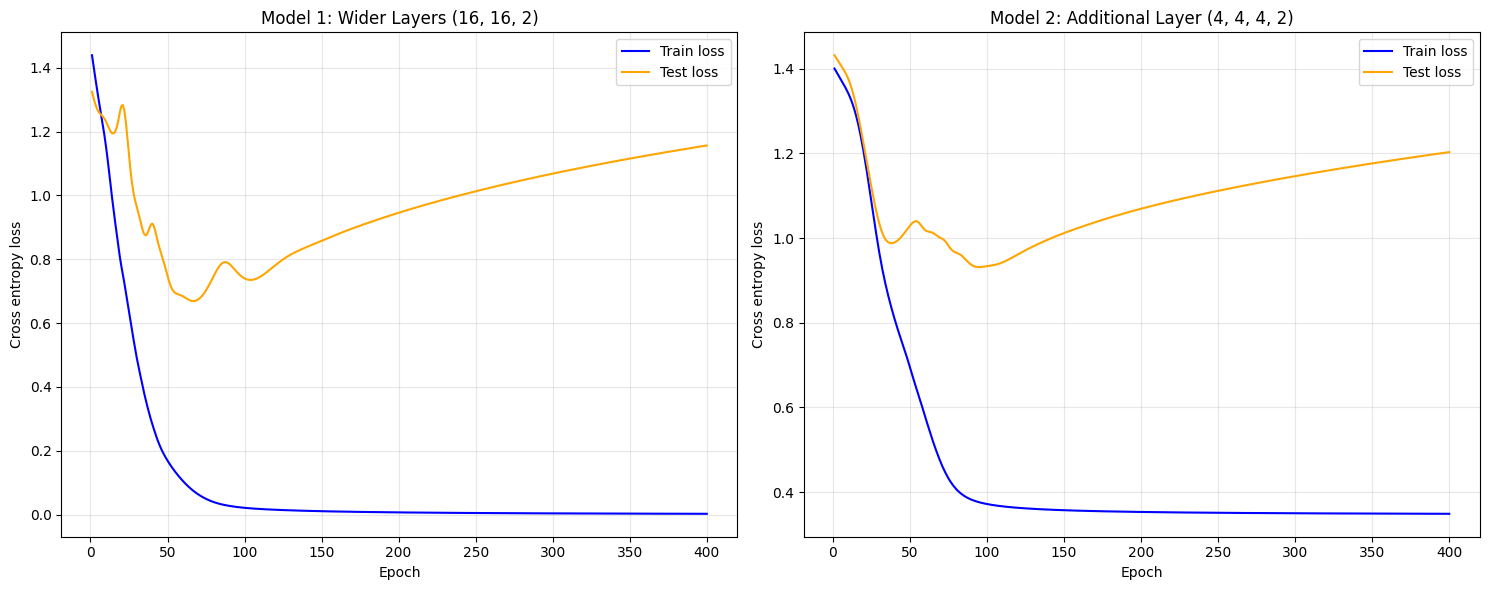

In [46]:
# Examine/plot results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss curves for Model 1
axes[0].plot(np.arange(1, n_epochs+1), train_losses_1, label='Train loss', color='blue')
axes[0].plot(np.arange(1, n_epochs+1), test_losses_1, label='Test loss', color='orange')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Cross entropy loss')
axes[0].set_title('Model 1: Wider Layers (16, 16, 2)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss curves for Model 2
axes[1].plot(np.arange(1, n_epochs+1), train_losses_2, label='Train loss', color='blue')
axes[1].plot(np.arange(1, n_epochs+1), test_losses_2, label='Test loss', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Cross entropy loss')
axes[1].set_title('Model 2: Additional Layer (4, 4, 4, 2)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

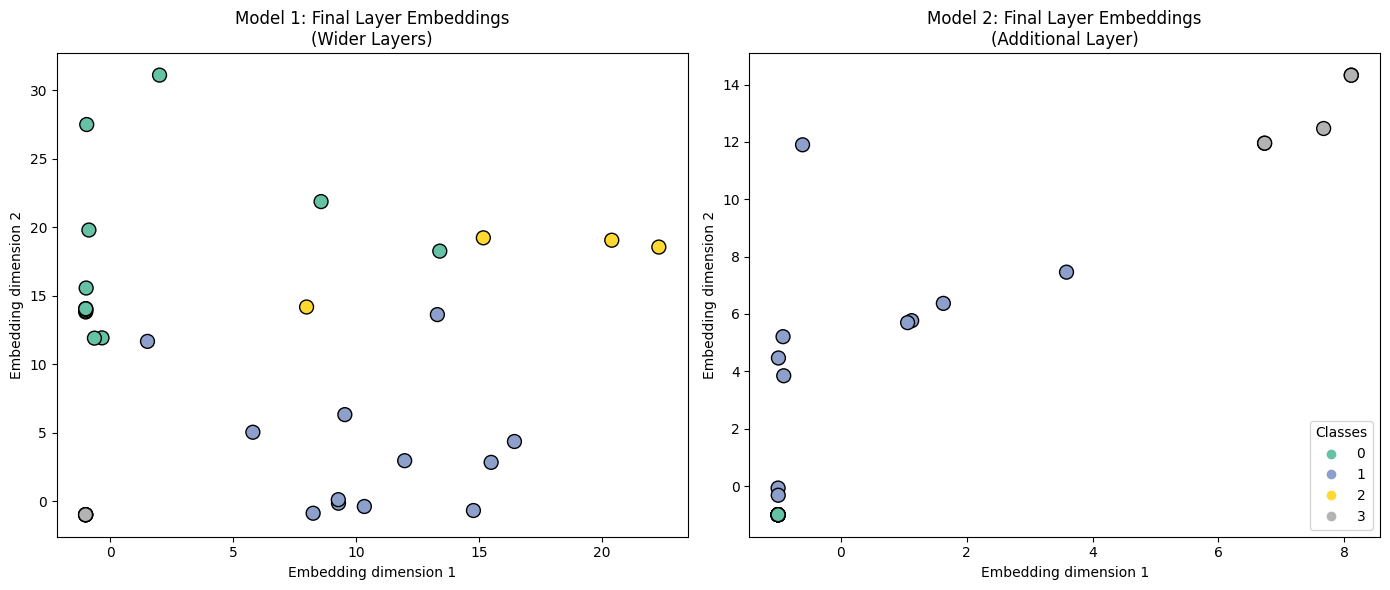

In [47]:
# Plot final layer embeddings
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Get final embeddings for both models
_, embedding_1 = model_1(data)
_, embedding_2 = model_2(data)

# Plot embeddings for Model 1
embedding_1_np = embedding_1.detach().cpu().numpy()
scatter1 = axes[0].scatter(embedding_1_np[:,0], embedding_1_np[:,1], 
                          c=data.y, cmap="Set2", s=100, edgecolor='black', lw=1)
axes[0].set_title('Model 1: Final Layer Embeddings\n(Wider Layers)')
axes[0].set_xlabel('Embedding dimension 1')
axes[0].set_ylabel('Embedding dimension 2')

# Plot embeddings for Model 2
embedding_2_np = embedding_2.detach().cpu().numpy()
scatter2 = axes[1].scatter(embedding_2_np[:,0], embedding_2_np[:,1], 
                          c=data.y, cmap="Set2", s=100, edgecolor='black', lw=1)
axes[1].set_title('Model 2: Final Layer Embeddings\n(Additional Layer)')
axes[1].set_xlabel('Embedding dimension 1')
axes[1].set_ylabel('Embedding dimension 2')

# Add legend to the second plot
axes[1].legend(*scatter2.legend_elements(), loc='best', title='Classes')

plt.tight_layout()
plt.show()

In [48]:
# Get classification accuracy
print("Final Model Performance:")
print("="*50)

# Model 1 accuracy
_, test_acc_1, _ = evaluate_model(model_1, data)
out_1, _ = model_1(data)
preds_1 = out_1.max(dim=1)[1].numpy()
true = data.y.detach().cpu().numpy()
train_acc_1 = accuracy_score(true[data.train_mask], preds_1[data.train_mask])
overall_acc_1 = accuracy_score(true, preds_1)

print(f"Model 1 (Wider Layers - 16, 16, 2):")
print(f"  Training Accuracy: {train_acc_1:.1%}")
print(f"  Test Accuracy: {test_acc_1:.1%}")
print(f"  Overall Accuracy: {overall_acc_1:.1%}")

# Model 2 accuracy
_, test_acc_2, _ = evaluate_model(model_2, data)
out_2, _ = model_2(data)
preds_2 = out_2.max(dim=1)[1].numpy()
train_acc_2 = accuracy_score(true[data.train_mask], preds_2[data.train_mask])
overall_acc_2 = accuracy_score(true, preds_2)

print(f"\nModel 2 (Additional Layer - 4, 4, 4, 2):")
print(f"  Training Accuracy: {train_acc_2:.1%}")
print(f"  Test Accuracy: {test_acc_2:.1%}")
print(f"  Overall Accuracy: {overall_acc_2:.1%}")

print(f"\nComparison:")
print(f"Better model: {'Model 1 (Wider)' if test_acc_1 > test_acc_2 else 'Model 2 (Deeper)'}")

Final Model Performance:
Model 1 (Wider Layers - 16, 16, 2):
  Training Accuracy: 100.0%
  Test Accuracy: 80.0%
  Overall Accuracy: 82.4%

Model 2 (Additional Layer - 4, 4, 4, 2):
  Training Accuracy: 75.0%
  Test Accuracy: 70.0%
  Overall Accuracy: 70.6%

Comparison:
Better model: Model 1 (Wider)


<div style="background-color:#C2F5DD">


End of example

## Summary

In this section, we have discussed how we can build and train GNNs using PyTorch Geometric, including:

* How to instantiate a simple GNN layer using PyG, specifically `GCNConv`

* Different methods of constructing GNN models using `torch_geometric.nn.Sequential` and by subclassing `torch.nn.Module`, including the specific syntax necessary for both

* Details of Zachary's karate club dataset, a simple but classic dataset for graph-based learning

* How we put everything together and perform a node classification task

In the next section, you will work through some exercises for node classification and graph classification, using the Cora and ENZYMES datasets respectively.


<hr style="border:2px solid gray">

## Exercises <a id='exercises'></a>[^](#index)

In this section, we will look at a couple different graph datasets and see the differences needed for graph classification, as well as try a couple other types of GNN layer from PyTorch Geometric.


<div style="background-color:#0000">

## Exercise 1

So far we have talked about how we cannot use fully-connected neural networks for graph datasets, but how well can we do if we did try using a simple multilayer perceptron? To investigate this, we will use the Cora dataset mentioned in [Section 2](#python-graphs) of this notebook. 

This will be a **transductive** training scenario, as although we will only use the training nodes for training, we effectively only mask the non-training nodes when it comes to calculating the training loss to update our model parameters. They still contribute to finding the output for our training nodes because they are still in the graph and can still pass messages based on their features.

To start with, we will load in the dataset. Note that we apply a transform as we load the data in, to normalise the node features. Without this, the feature vector for each node will just sum to how many of the dictionary words are contained in the corresponding paper.

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data', name = 'Cora', transform = NormalizeFeatures())

<div style="background-color:#0000">

First, a few questions about the dataset:

* How many nodes are in the graph?

* How many features does each node have?

* How many different classes are there?

* How many training, validation, and test samples are there?

In [ ]:
# Your code here


<div style="background-color:#0000">

Now, train a simple 2-layer MLP on the node features from the training nodes of the Cora dataset, using an activation function of your choice. Remember the following:

* Use 16 hidden channels in the MLP, as well as a dropout layer with your choice of value for `p`

* Apply NN layers in the order linear, activation, dropout

* Use an `Adam` optimizer with your choice of `lr` and `weight_decay`, and the `CrossEntropyLoss` loss function

* You can get the number of node features and classes from the dataset using `dataset.num_node_features` and `dataset.num_classes` respectively

* You must extract the node features array from the `Dataset` object, which contains a single `Data` object representing the graph

* Use the graph `train_mask` attribute to select just the training nodes for training and `val_mask` to select the validation nodes. 

* When evaluating performance on the validation nodes, make sure to put the model into evaluation mode by running `model.eval()`

* Keep the test set to one side for now; we will use it at the end of the Cora exercises to evaluate performance from all of our models.

* Be sure to track the train and validation loss as you train

Train the MLP for 200 epochs, and then evaluate the training and validation classification accuracy. Select the prediction class for each model output by finding the maximum value output, as we did in the `KarateClub` example. Also, plot the training and validation loss as a function of epoch.

In [ ]:
# Your code here

<div style="background-color:#C2F5DD">

You should find that while you can get some performance, you probably don't do very well on this data as we have in no way leveraged connections between different nodes. Instead, to do this we will need to use our GNN structures.

<div style="background-color:#0000">

## Exercise 2

Now we will attempt the same node classification again, but this time using a 2-layer GNN. Remember the following points:

* Define a GNN with 2 `GCNConv` layers, with 16 hidden channels like our MLP; don't use any linear layers, and instead have the final GNN have `num_classes` output channels

* Include an activation function and dropout layer after your first GNN layer, like in the MLP; use the same activation function and value of `p` for the dropout layer

* Use either `Sequential` or a `nn.Module` subclass to define your model; make sure you correctly pass the node features and edge indices to the `GCNConv` layers

* Use a `CrossEntropyLoss` loss function and the `Adam` optimizer, with the same parameters as for the MLP training

* Make sure to train only on the training set nodes, and evaluate the performance only on the validation set nodes

Train the GNN for 200 epochs. How does the validation accuracy compare with your MLP results? Comment in the Markdown cell below.

In [ ]:
# Your code here

Your answer here

<div style="background-color:#0000">

## Exercise 3

Now we have tried a GNN, we will try varying some parameters of this GNN to see if we can improve our performance; specifically, try:

1. Increasing the number of hidden channels, e.g. to 32

1. Adding an additional `GCNConv` layer with associated activation and dropout layers, with 10 hidden channels

The procedure for building and training these is otherwise the same as in the previous exercise. How do these results compare with your previous results? Are either of these approaches better than the other? Answer in the Markdown cell below.

In [ ]:
# Your code here

Your answer here

<div style="background-color:#0000">

## Exercise 4

Finally, we are going to try using a different type of GNN layer to see if we can improve our performance further - specifically, we will use the `GATConv` layer, which implements the graph attentional operator from [this paper](https://arxiv.org/abs/1710.10903). This makes use of so-called **attention mechanisms**, which allow us to pay more or less attention to different nodes for a given node. We will see attention mechanisms in more detail when we discuss transformers.

This layer has a couple additional parameters that we will specify, namely `heads` and `dropout`. `heads` refers to the number of attention heads used, i.e. how many different ways we can attend to nodes. `dropout` refers to the `p` parameter of a dropout layer, which is applied to the attention calculation. Full details of this layer can be seen in the [documentation](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html#torch_geometric.nn.conv.GATConv).

Build a GNN with 2 `GATConv` layers using the `CoraGAT` class defined in the cell below. Use 8 hidden channels in this model.

The training and testing procedure is the same as the other models we have trained. Remember the following:

* Use the same loss function, optimizer, and optimizer parameters as before

* Train on the training set nodes and evaluate on the validation set

Train for 200 epochs and calculate the validation set performance. Does this perform better than your other models? Answer in the Markdown cell below.



In [ ]:
# Your code here

Your answer here

<div style="background-color:#C2F5DD">

Finally, now evaluate the performance of all of your MLP, all three GCN models, and the GAT model, on the **test** dataset, which you can get using `data.test_mask`. Which performs best? Answer in the Markdown cell below.

In [ ]:
# Your code here


Your answer here

<div style="background-color:#0000">

## Exercise 5

<!--Now start looking at ENZYMES; do graph classification, brief comment on how to go from node embeddings to graph embeddings, then eventually use `GraphConv` to mention skip connections-->

Now we are going to do a graph classification exercise, instead of the node classification exercises we have done so far. To do this, we will use a different dataset from the `TUDataset` class, called MUTAG. This is another molecular classification task, where each graph represents a molecule and they are classified based on their effect on a given type of bacteria. This specifically is an **inductive** training scenario, as we will have completely separate training, validation and test datasets consisting of different graphs.

First, we will load in the data:

In [ ]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data', name = 'MUTAG')

<div style="background-color:#0000">

Now, inspect the data: 

* How many graphs are in the dataset?

* How many node features are there?

* How many classes are there?


In [ ]:
# Your code here

<div style="background-color:#C2F5DD">

Split the dataset into training, validation, and test datasets, with a 50:25:25 split. Define `DataLoader` objects for these datasets using `torch_geometric.loader.DataLoader`, with a batch size of 32. We will keep the test data to one side and use it to evaluate performance across all of our models at the end of these graph classification exercises.

Note: because PyTorch Geometric is built on top of PyTorch, you can use the same utility functions we have seen previously for other types of neural network.



In [ ]:
# Your code here

<div style="background-color:#C2F5DD">

Now we will train a simple GNN to classify these graphs. 

Build a GNN that does the following steps:

* Uses three `GCNConv` layers, with 64 output features for each

* ReLU activation functions after the first 2 `GCNConv` layers

* Apply a global pooling to the node embeddings using one of the global pooling functions in `torch_geometric.nn`, e.g. `global_mean_pool`, `global_add_pool`, etc

* Include a dropout layer after global pooling, with your choice of value for `p`

* Finally, apply a linear layer to convert the graph embedding to a class vector, as we have done before for multiclass classification




In [ ]:
# Your code here


<div style="background-color:#C2F5DD">

Finally, train your GNN for 200 epochs using the training data, and evaluate your final performance on the test data. As before, use a `CrossEntropyLoss` loss function and the `Adam` optimizer, with a learning rate of 0.01.

How well do you do? Calculate any metrics you feel are appropriate based on what you have learned in the course so far.

In [ ]:
# Your code here

Your answer here

<div style="background-color:#C2F5DD">

## Exercise 6

Like before we will now try varying the architecture of our GNN to see if we can improve our performance. Try the following two changes in **two separate models**:

1. Add an additional `GCNConv` layer with `ReLU` activation after it, before the final `GCNConv` layer, with 64 output channels

1. Increase the number of output channels of your existing `GCNConv` layers from 64 to 128.

Otherwise, use the same parameters in your previous model. Make sure you implement these changes in two separate models, not in the same model, and use a different optimizer instance for each model. Train each model for 200 epochs.

How does the performance compare to your previous model? Does one method perform better, and does this agree with the results you observed for the Cora dataset in Exercise 3, i.e. does a wider or deeper GNN improve results in both cases or do you see somethign different? Write your answers in the Markdown cell below.


In [ ]:
# Your code here

Your answer here

<div style="background-color:#C2F5DD">

## Exercise 7

Once again, we will now try using a different kind of GNN layer to see if we can improve our performance further. As mentioned in [Section 3](#embeddings), if we have added self-loops to our adjacency matrix then we can share weights for message calculation for both a node's neighbourhood and its own message, which we can incorporate into the next layer embedding value. 

However, in this setup we cannot separate the contributions of the node itself from its neighbourhood, and we can lose information as a result of normalising over the neighbourhood. One way to mitigate this is to instead define a second matrix of weights that is used exclusively for calculating the message from a node's own previous layer embedding, and omitting the neighbourhood normalisation included in `GCNConv`. This is implemented in PyTorch Geometric as `GraphConv`. 

Reimplement any (or all, if you have time) of the GNN models you have trained on the MUTAG dataset, only this time replacing all `GCNConv` layers with `GraphConv`. Remember the following:

* Keep all other parameters the same as your previous training

* Train for 200 epochs and evaluate final performance on the validation dataset

How does the performance compare to your previous results? Which GNN layer performs better? Answer in the Markdown cell below.

In [ ]:
# Your code here

Your answer here

<div style="background-color:#C2F5DD">

Finally, evaluate the classification accuracy on the test set for all of the models you have trained on the MUTAG dataset and compare the results. Which model performed the best? Is this consistent with your validation set performance?

In [ ]:
# Your code here



Your answer here

<div style="background-color:#C2F5DD">

### End of exercises

<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

# Appendices <a id='appendices'></a> [^](#index)

## Appendix A: More complex types of graph <a id='appendix-a'></a> [^](#index)

There are other, more complex types of graph that can exist that still have very interesting problems to solve. Some examples include:

* **Multirelational graphs**: these are graphs with multiple types of edges that connect nodes, and a given node can be connected by multiple types of edge.

    * In the London Underground example where we say edges represent train routes, the edge type could be which train line the route corresponds to, e.g. both the Circle and District Line run between Gloucester Road and South Kensington
<br></br>

<div style="display: flex; justify-content: center; gap: 80px; align-items: flex-start;">
<div style="display: flex; flex-direction: column; align-items: flex-start; width: 400px; margin: 0;">
<div style="height: 30px;"></div>
<img src='plots/tube-selection.png' width=400 style="align-self: center;"/>
<div style="height: 30px;"></div>
<div style="margin-top: 10px; text-align: justify; max-width: 400px; font-style: italic; line-height: 1.2;">

<strong>Left</strong>: a section of the London underground map ([source](https://www.tubemaplondon.org/#sirv-viewer-284230498900)).
</div>
</div>
<div style="display: flex; flex-direction: column; align-items: flex-start; width: 400px; margin: 0;">
<img src='plots/multirelational-graph-fitted.png' width=400 style="align-self: center;"/>
<div style="margin-top: 10px; text-align: justify; max-width: 400px; font-style: italic; line-height: 1.2;">

<strong>Right</strong>: the same section of the London underground tube map, represented as a multirelational graph.
</div>
</div>
</div>

* **Heterogeneous graphs**: graphs where we have different types of nodes, so we can separate nodes into distinct sets. Edges in heterogeneous graphs typically satisfy some conditions based on the types of nodes they connect, e.g. they may only connect one type of node to another, or may only connect one type to the same type. We then often have multiple types of edges in these graphs. 

    * For example, we could have a biomedical graph where the three types of nodes are diseases, medications, and proteins. Edges between disease and medication nodes could represent treatment, whereas edges between two medication nodes might represent interactions between the two drugs. 
<br></br>

<center>
<img src='plots/heterogeneous-graph.png' width=600 align='center'></img>
<div style='width:600px'>

*An example heterogeneous graph, for an e-commerce application. Node types include users, products and reviews, and edge types are user-buy-product, user-write-review, and review-on-product ([source](https://research.google/blog/teaching-old-labels-new-tricks-in-heterogeneous-graphs/)).*

</center>

* **Bipartite graphs**: a specific type of heterogeneous graphs where the nodes can be separated into 2 disjoint and independent sets, such that nodes in set A only connect to nodes in set B and vice versa. This means there are at least two edges between any two nodes in one set. This can generalise to N sets where edges are only between sets, which are referred to as **multiplex graphs**.

    * An example of this type of graph could be found in looking at paper authorship, where we group nodes as authors and papers. An author is linked to the papers they have authored, and so author-author links can be found by edges going to the same node in the paper set. 

<center>
<img src='plots/bipartite-graph.png' width=400 align='center'></img>
<div style='width:400px'>

*An example bipartite graph mapping three authors A0, A1, and A2 to a set of 5 papers authored between them.*
</div>
</center>

As before, for the purposes of this notebook we will focus solely on simple graphs, but it is useful to be aware of the wide range of possible types of graph data.


<div style="background-color:#efdff2">


## Appendix B: Data assumptions with graphs <a id='appendix-b'></a> [^](#index)

While on the face of it node classification and relation prediction seem like supervised learning and clustering seems like unsupervised learning, with graph data we in general break a fundamental assumption we have made about our data so far: that data points are **independent** and **identically distributed**. We can will these assumptions in turn: 

* data points are **independent**: the value at one data point has no dependence on the values of any other data point

* data points are **identically distributed**: the underlying distribution determining the value at a given data point is the same for all data points

However, for graph data:

* each node is not independent; instead, it is connected to other nodes, and the feature values of the nodes in the neighbourhood (and indeed more widely across the graph) are assumed inform the values at the node of interest

* nodes are not identically distributed: nodes are assumed to be affected by or similar to nodes in their neighbourhood, but each node has a different neighbourhood and so has a different underlying distribution determining the feature values at the node

In fact, one of the things that makes graph node classification approaches successfully is *exploiting* relationships between nodes in order to improve our predictions. For example, there are several different ideas we can exploit: 

* **homiphily**: assuming that nodes have a tendency to share attributes with neighbours

* **structural equivalence**: assuming that nodes with a similar local structure (with regards to number of edges, cycles in the graph, etc.) will have similar labels

* **heterophily**: assuming that nodes are preferentially connected to other nodes with *different* labels

Regardless of what kind of structure we assume or even observe in our data, the key to good performance in graph tasks is in exploiting these relationships.


<div style="background-color:#efdff2">


## Appendix C: Shallow embeddings <a id='appendix-c'></a> [^](#index)

### Shallow embeddings

An encoder is be some function that maps a node $v$ into some $d$ dimensional embedding space. The simplest possible such encoder is a basic lookup table. We represent this as follows:

* For a node $v$, define an indicator vector $\mathbf{v}$ that is 1 at the index of node $v$ and 0 elsewhere. By definition, $|\mathbf{v}|$ is equal to the number of nodes in the graph.

* Define some embedding matrix $\mathbf{Z}$ with $d$ rows and a column for every node, where $d$ is the dimensionality of the embedding space, i.e. $\mathbf{Z}\,\in\mathbb{R}^{d\times|\mathbf{v}|}$

* The function of the encoder is then given as 

$$\text{ENCODER}(v) = \mathbf{Z}\mathbf{v}$$

Effectively, for every node in the graph we individually learn an embedding for that node. This means:

* Each node embedding is optimised directly

* Node embeddings are optimised to ensure the node pair decoder output is close to the similarity of the two nodes

* We must define the similarity function to learn our embeddings

There are many ways we can define similarity between nodes, e.g. a simple example could be we say two nodes are similar if they have an edge joining them. One common way of defining node similarity is as the probability that the two nodes co-occur on some random walk across the graph.

A key point about shallow embeddings is that they don't care about node features or node labels - they only use the structure of the graph to embed the nodes. This is essentially an unsupervised learning of the node embeddings, although this may also be referred to as **self-supervised** as the "labels" are from the graph structure.
<br></br>

However, there are some key issues with shallow embeddings:

* By definition we don't use node features, so our embeddings are independent of node features, whereas we generally want to include this information

* Two nodes can have very similar local structures e.g. number & type adjacent nodes, graph cycles, etc., but may not be likely to be both reached in a random walk - these will still have very different embeddings in a shallow framework

* We *cannot generalise to unseen nodes* - each embedding is learned for the node, so we would have to manually learn a new embedding for a new node. 

**For a more comprehensive discussion of shallow embeddings, please see Section I of *Graph Representation Learning* (link to prepublication pdf available at the start of this notebook).**



<div style="background-color:#efdff2">

## Appendix D: Permutation invariance and equivariance <a id='appendix-d'></a> [^](#index)

* For some function $f$ that maps a graph $G$ to a *vector*, if for any permutation of $G$ the output of $f$ is unchanged, we say $f$ is a **permutation-invariant** function

* For some function $f$ that maps a graph $G$ to a *matrix*, if for any permutation of $G$ the output of $f$ is permuted in the *same way*, we say that $f$ is a **permutation-equivariant** function

If we want our deep encoder to operate on our graph correctly, it must be composed of permutation-invariant and permutation-equivariant functions.


Let us denote our graph $G = (\mathbf{A}, \mathbf{X})$ where $\mathbf{A} \in \mathbb{R}^{|V|\times|V|}$ is the adjacency matrix and $\mathbf{X} \in \mathbb{R}^{|V|\times m}$ is the matrix of node features and $m$ denotes the number of node features per node.



We now define permutation invariance and equivariance as follows:

* Permutation invariance: for any graph function $f:  \mathbb{R}^{|V|\times|V|} \times \mathbb{R}^{|V|\times m} \to \mathbb{R}^d$, $f$ is **permutation-invariant** if 

$$f(\mathbf{A}, \mathbf{X}) = f(\mathbf{P}\mathbf{A}\mathbf{P}^T, \mathbf{P}\mathbf{X})\text{ for any permutation of the graph }\mathbf{P}$$

* Permutation equivariance: for any graph function $f: \mathbb{R}^{|V|\times|V|} \times \mathbb{R}^{|V|\times m} \to \mathbb{R}^{m\times d}$, $f$ is **permutation-equivariant** if 

$$\mathbf{P} f(\mathbf{A}, \mathbf{X}) = f(\mathbf{P}\mathbf{A}\mathbf{P}^T, \mathbf{P}\mathbf{X})\text{ for any permutation of the graph }\mathbf{P}$$

If we were to consider a simple fully-connected neural network and flatten our adjacency matrix into a vector to act as an input to this network, we can immediately see that we are *not* permutation-invariant: the order of the vector we feed into our neural network matters but is dependent on the arbitrary node labelling we used for the adjacency matrix. 

Similarly, CNNs rely on a consistent definition of locality across the input, but the number of edges connected to a node can be different for every node so we cannot just learn weights of the convolutional filter like we do for a CNN; again, CNN operations are not permutation invariant.

Instead, we have to design new layers to work on graph data, which rely on so-called **message passing** and **aggregation** of information from neighbours.

<div style="background-color:#efdff2">


## Appendix E: aggregating embeddings for edge and graph tasks <a id='appendix-e'></a> [^](#index)


* Edge-level tasks - we need to make predictions based on pairs of node embeddings, so need to somehow aggregate them:
    
    * We could simply concatenate the embeddings from the pair of nodes into a single vector, then apply a linear layer to get the desired size output vector e.g. with an embedding space with $d$ dimensions and $n$ target classes, the linear layer would have $2d$ input neurons and $n$ output neurons

    * Alternatively, we could take some product of the two node embeddings; for predicting a single output e.g. if a link exists, this could just be the dot product between the embeddings, but if we want to predict $n$ output values for a given edge then things are more complicated (see non-examinable box below)
<br></br>

* Graph-level tasks - we need to make predictions based on *all* of the node embeddings, so need to aggregate them all:

    * We could apply the same type of aggregation functions used in GNN layers, e.g. mean pooling, max pooling, sum pooling, to get one aggregated embedding for the graph (best for *small* graphs)

    * For larger graphs, global pooling often loses information e.g. if different regions of the graph have a different scale to their embeddings
        * Instead, can hierarchically pool node embeddings into sub-graph embeddings, and then pool the subgraph embeddings to get a whole graph embedding

        * A famous example of this idea is [DiffPool](https://arxiv.org/abs/1806.08804), which effectively runs two GNNs simultaneously; at each layer, one clusters the nodes and the other computes embeddings, and embeddings are pooled according to their learned clusters to produce a new graph with fewer nodes to input into the next layer. This is illustrated in the schematic below.

    * Regardless of how we do it, after we have an embedding for the graph we can then apply standard techniques e.g. a fully-connected neural network to classify the graph embedding

<center>
<img src='plots/diffpool.png' width=800></img>
<div style="text-align:center;">
<div style='width:760px;display:inline-block;vertical-align:top'>
<div style="text-align: justify;">


*A schematic illustrating DiffPool [[source](https://arxiv.org/abs/1806.08804)]. At each layer of the whole model, one GNN layer learns embeddings for the graph and another GNN layer applies a softmax to a different set of learned embeddings, to determine clusters to assign each node to. The computed embeddings are then aggregated over the computed clusters to define a new graph to be passed into the next layer of the model. Effectively, two GNNs run in parallel to compute embeddings and to cluster nodes.*
</div></div></div>
</center>

For prediction of $n$ edge features based on the dot product of the node embeddings, rather than just taking a dot product we must instead define a learnable matrix for each of the $n$ features:

* Let $\mathbf{z}_u$, $\mathbf{z}_v$ $\in \mathbb{R}^{d}$ denote the final layer $d$-dimensional node embeddings with for nodes $u$ and $v$ respectively

* Let $\mathbf{W}^{(i)} \in \mathbb{R}^{(d\times d)}$ denote the learnable matrix for edge feature $i$

* Let $\hat{y}_{uv}^{(i)}$ denote edge feature $i$ for the edge joining nodes $u$ and $v$

Then, we require that

$$\hat{y}_{uv}^{(i)} = \mathbf{z}_u^T \mathbf{W}^{(i)} \mathbf{z}_v,$$

and the final edge feature vector is given as 

$$\hat{y}_{uv} = \left(\hat{y}_{uv}^{(1)}, \cdots, \hat{y}_{uv}^{(n)}\right) \in \mathbb{R}^n.$$

<div style="background-color:#efdff2">


## Appendix F: Graph manipulations <a id='appendix-f'></a> [^](#index)

* Feature augmentation: could be necessary if we have *no* node features in our graph as GNN architectures needs node features to work
    * We could add a new feature to all nodes, all with the same value, so we can still learn from the structure in the graph
<br></br>

* Handling sparse graphs: this happens when there are not many connections between nodes, so when we apply a message passing layer we are only getting messages from a very small number of nodes

    * One option is to add virtual edges e.g. between two-hop neighbours - this is equivalent to replacing the adjacency matrix $\mathbf{A}$ with a new adjacency matrix equal to $\mathbf{A} + \mathbf{A}^2$

        * This is useful in bipartite graphs, as nodes in the same group are separated by at least two hops; for e.g. author-publication graphs we can then effectively add edges between co-authors

    * Alternatively, we could add a virtual node connected to all the nodes in the graph - this means every node is within a 2 hop neighbourhood

    * Examples of both of these approaches are shown for a bipartite graph in the figure below.
<br></br>

<div style="display: flex; justify-content: center; gap: 20px; align-items: flex-start;">
<div style="display: flex; flex-direction: column; align-items: flex-start; width: 500px; margin: 0;">
<img src='plots/bipartite-graph-2hop.png' width=500 style="align-self: center;"/>
<div style="margin-top: 10px; text-align: justify; max-width: 500px; font-style: italic; line-height: 1.2;">

<strong>Left</strong>: a bipartite author-publication graph with virtual edges between 2-hop neighbours.
</div></div>
<div style="display: flex; flex-direction: column; align-items: flex-start; width: 500px; margin: 0;">
<img src='plots/bipartite-graph-virtual-node.png' width=500 style="align-self: center;"/>
<div style="margin-top: 10px; text-align: justify; max-width: 500px; font-style: italic; line-height: 1.2;">

<strong>Right</strong>: the same bipartite graph, with an additional virtual node connected to all other nodes. Each node is thus in at least a 2-hop neighbourhood of any other node.
</div></div>
</div>

* Handling dense graphs: this occurs when we have many nodes with many edges, which can cause issues with computatational cost
    * Instead of using every node in the neighbourhood to update our embedding, we can instead randomly sample the neighbourhood and use a subset of the nodes for updates

        * So long as we select a new random sample each step in the training, this in general produces embeddings similar to the case where we use all neighbours

You might in general implement these manipulations as preprocessing to graphs before passing to your GNN. 